# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='equitysilver',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=2, options=('redchris', 'goldenbear', 'equitysilver', 'test'), value…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AA…

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/equitysilver_c_curves_p.pkl
Loaded data from ./inputs/curves/equitysilver_c_curves_f.pkl


In [11]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves_both(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for equitysilver_max_hv_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17023 rows, 83258 columns and 83258 nonzeros
Model fingerprint: 0xab2a2112
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 17023 rows and 83258 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3344616e+08   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.04 work units)
Optimal objective  1.334461620e+08


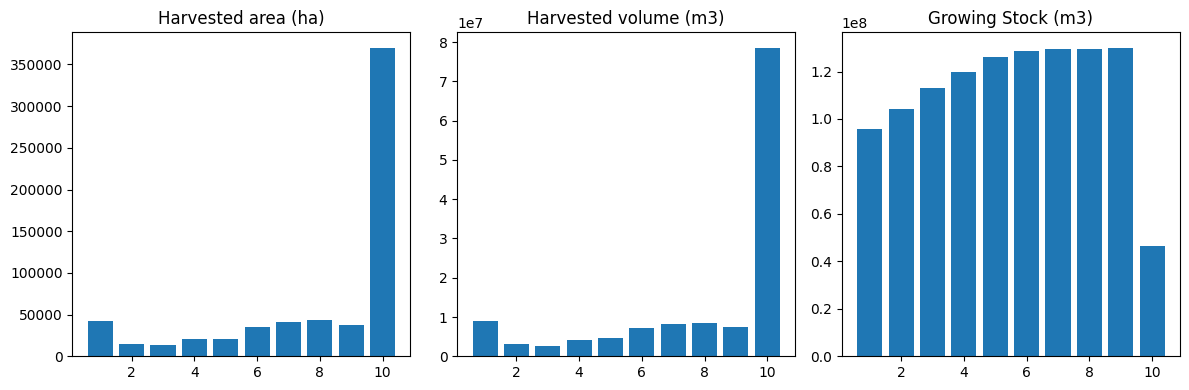

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_no_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  141080
The economic indicator (the provincial government revenues) is:  4811151
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


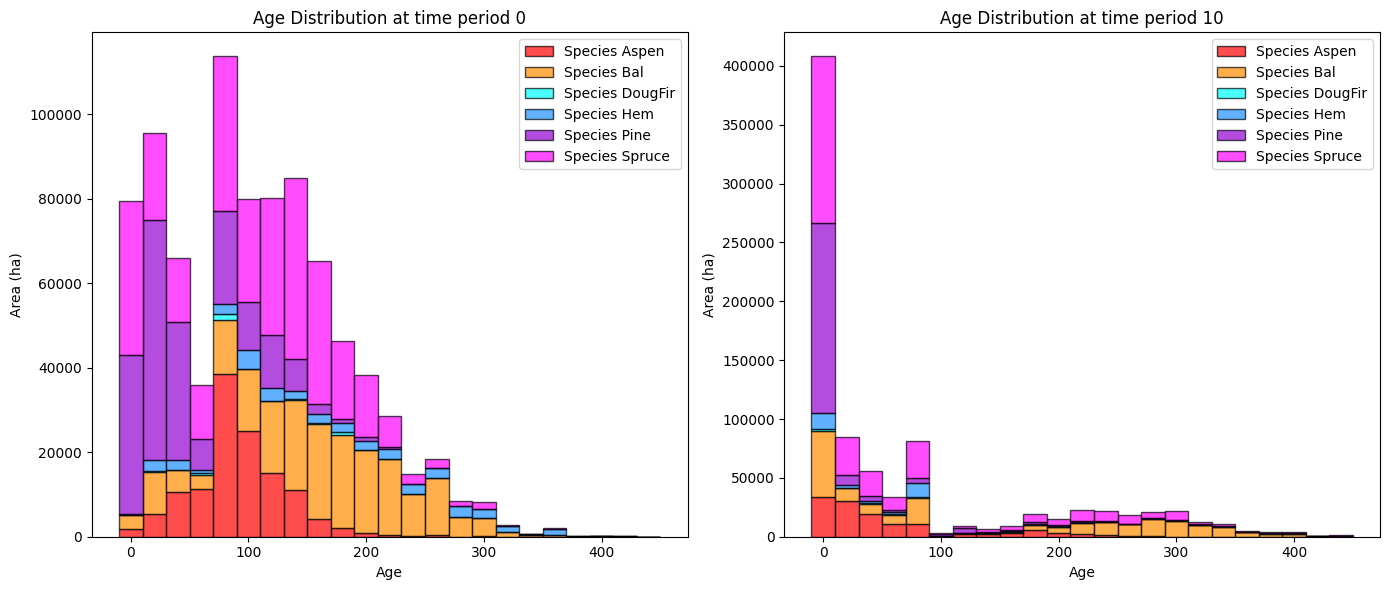

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   6126.874563 -13025.252666
DougFir    947.047810    387.176384   -559.871426
Bal      59315.970469  79882.187655  20566.217186
Spruce   36410.744598  52548.704990  16137.960392
Aspen    29632.731169  20660.292057  -8972.439112
Pine      7432.733686   6721.590051   -711.143635

Overall diversity has **increased** by 13435.47 hectares from time period 0 to time period 10.


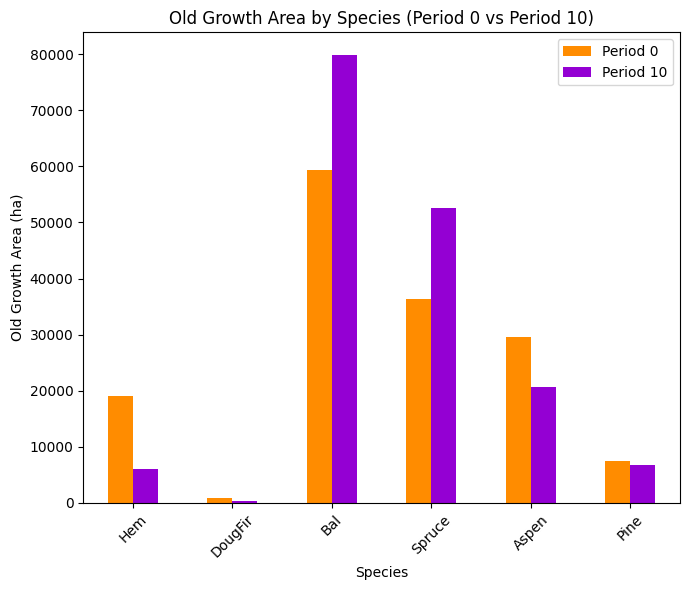

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7509

Diversity has **decreased** by 0.83% from time 0 to time 10.


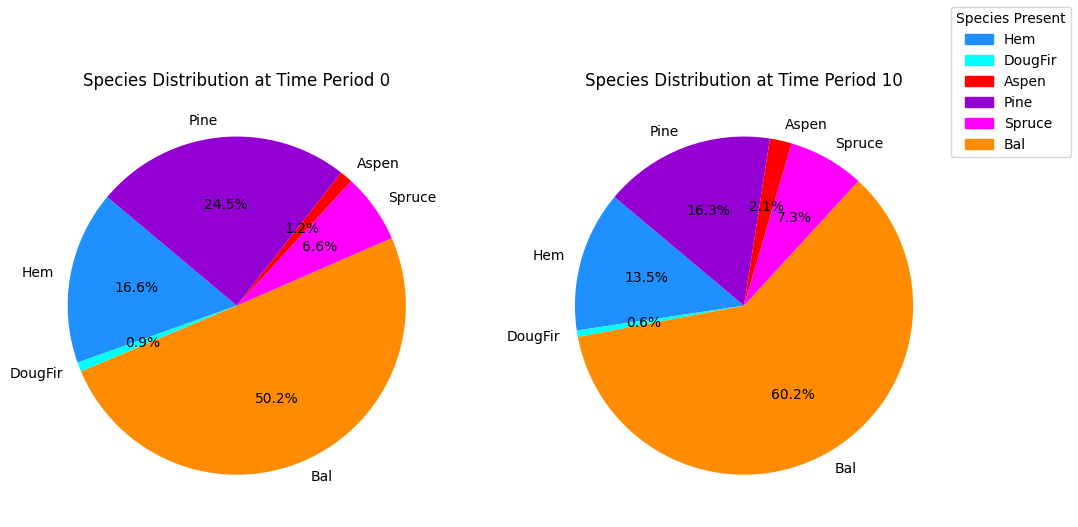

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_no_cons_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.40s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering t

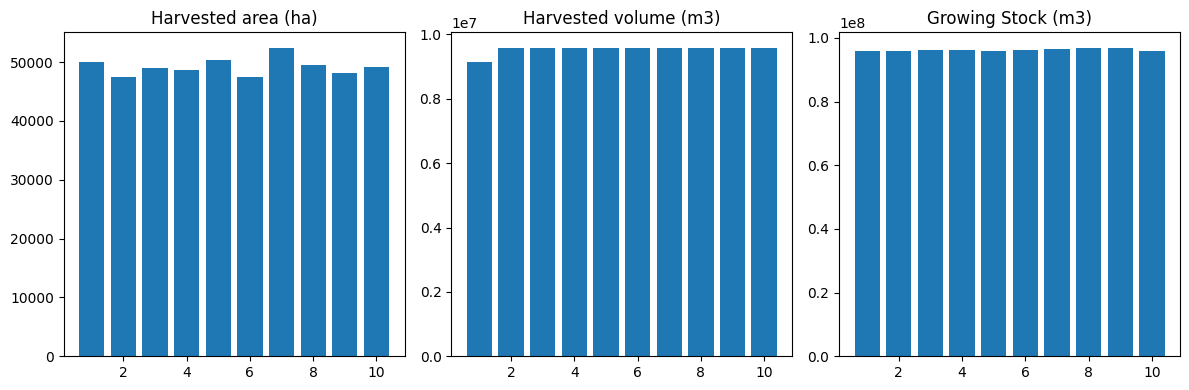

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


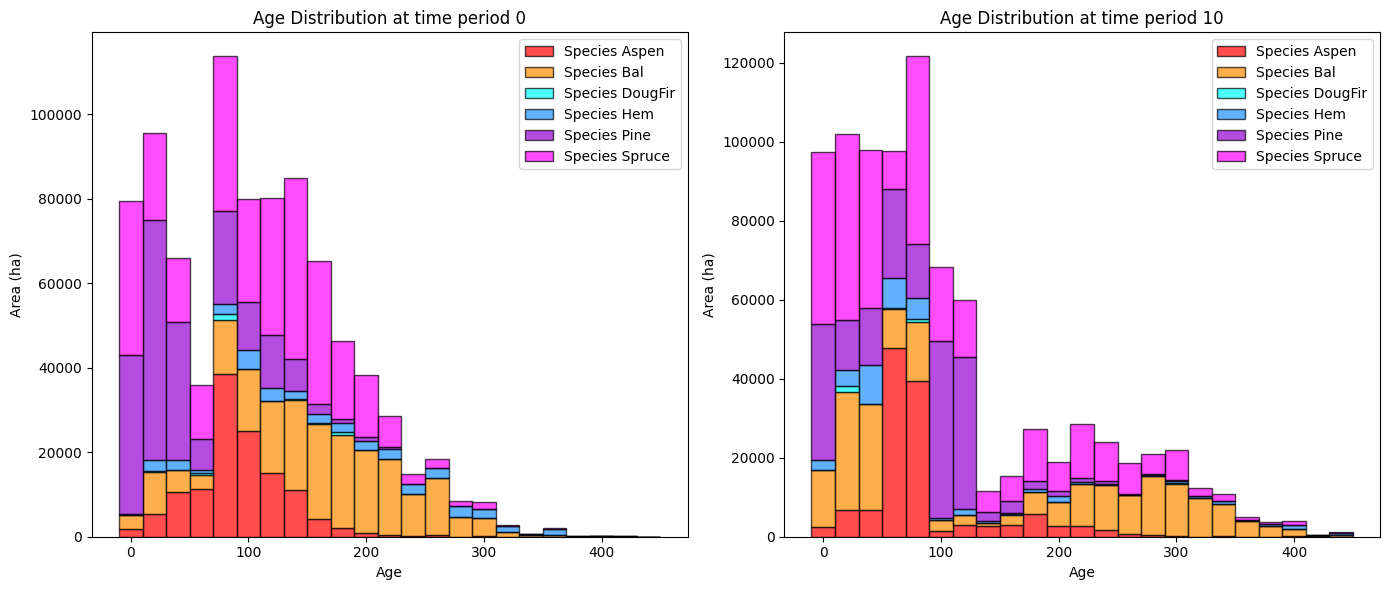

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7420.003864 -11732.123365
DougFir    947.047810    588.823746   -358.224064
Bal      59315.970469  83662.092085  24346.121617
Spruce   36410.744598  67222.186953  30811.442355
Aspen    29632.731169  21366.865973  -8265.865196
Pine      7432.733686  16124.525134   8691.791448

Overall diversity has **increased** by 43493.14 hectares from time period 0 to time period 10.


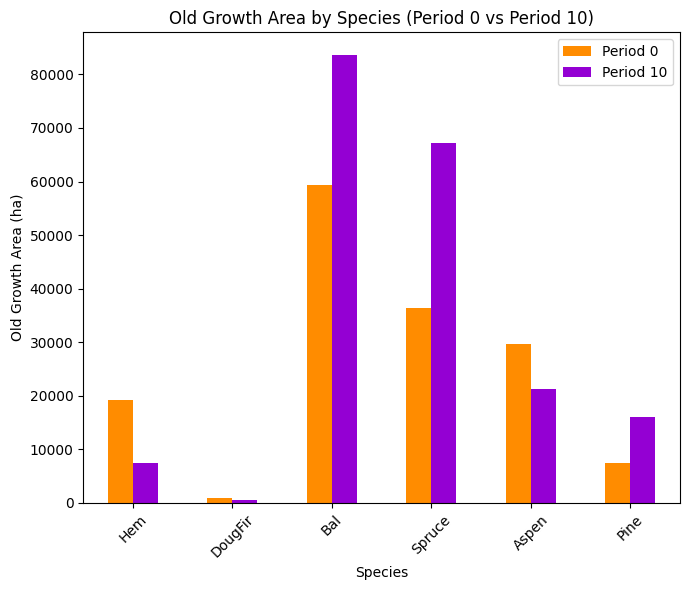

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7329

Diversity has **decreased** by 2.63% from time 0 to time 10.


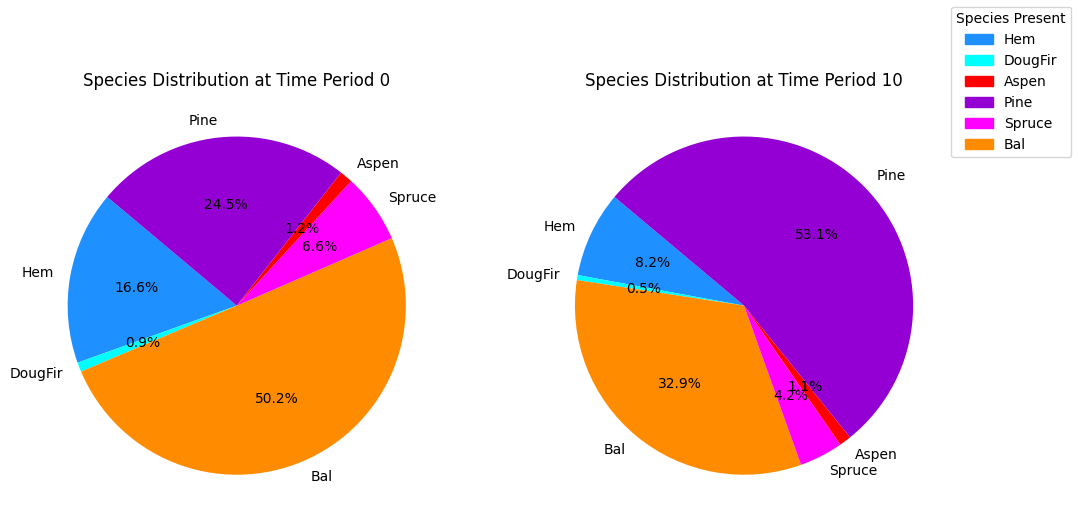

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


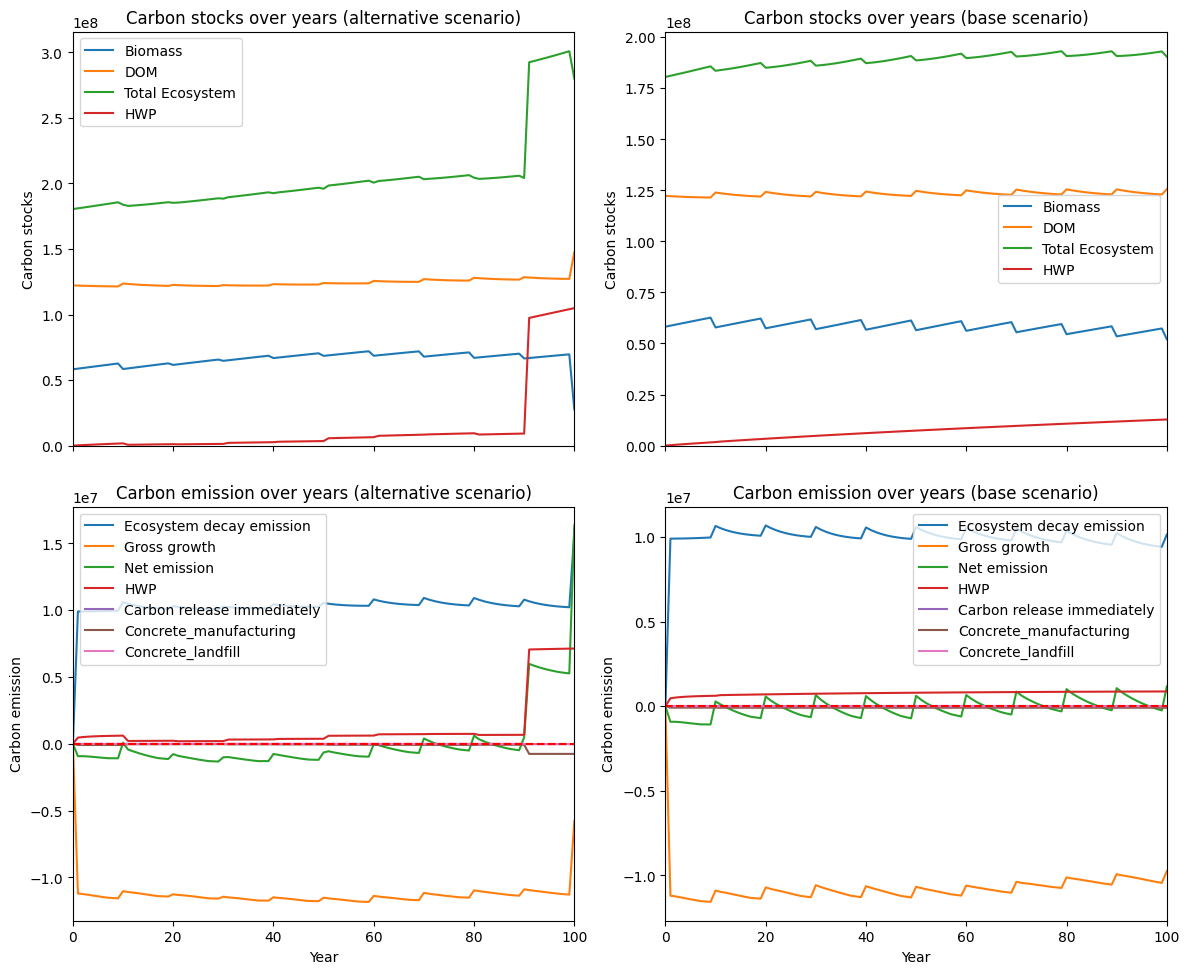

---------------------------------------------------------------------------------------
Net emission difference -10155731.670241633
Net emission base scenario -21482762.137930777
Net emission alternative scenario -11327030.467689143
dollar_per_ton is:  0.9846656375632729
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  -1293.129300  -1293.129300
DougFir  0.0   -201.647362   -201.647362
Bal      0.0  -3779.904430  -3779.904430
Spruce   0.0 -14673.481963 -14673.481963
Aspen    0.0   -706.573916   -706.573916
Pine     0.0  -9402.935083  -9402.935083

Overall, the old growth area has **decreased** by -30057.67 hectares in the alternative scenario compared to the base scenario.


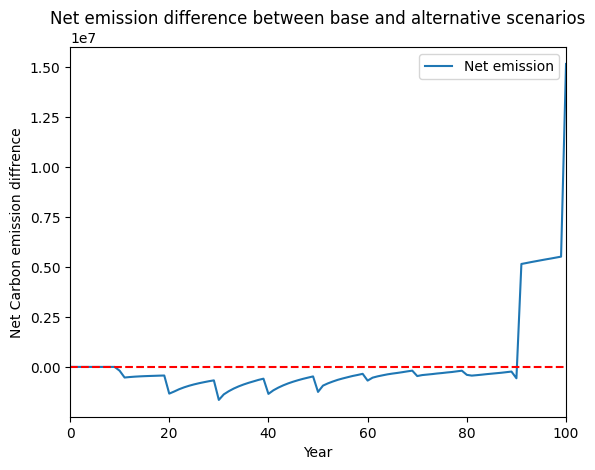

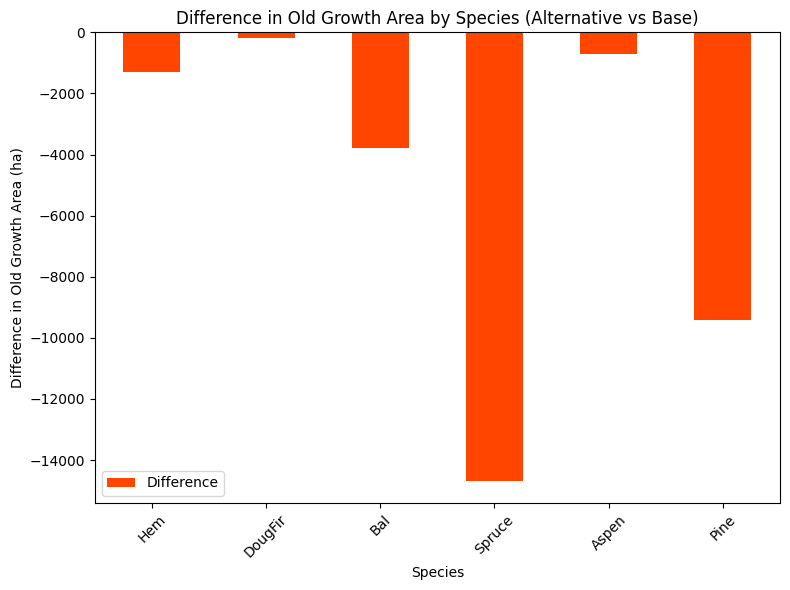

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


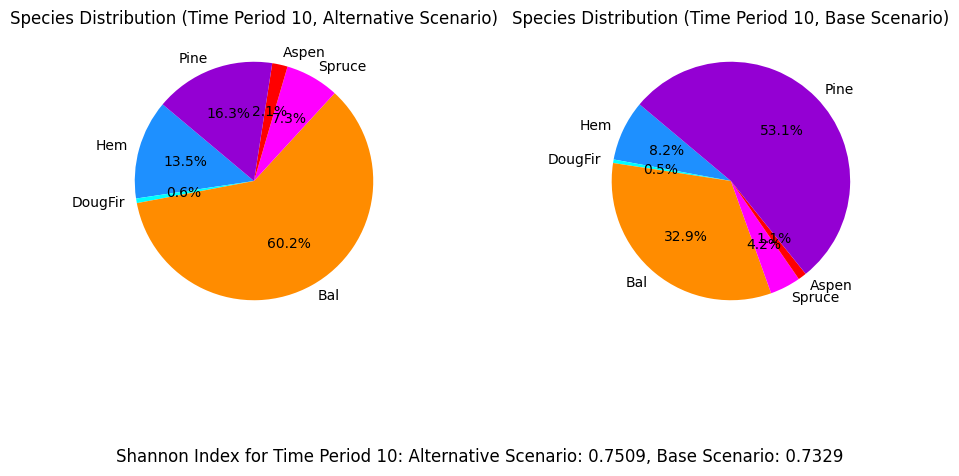

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17063 rows, 83258 columns and 514878 nonzeros
Model fingerprint: 0xca29d094
Coefficient statistics:
  Matrix range     [5e-03, 6e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 8690 rows and 17244 columns
Presolve time: 0.21s
Presolved: 8373 rows, 66014 columns, 477992 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ord

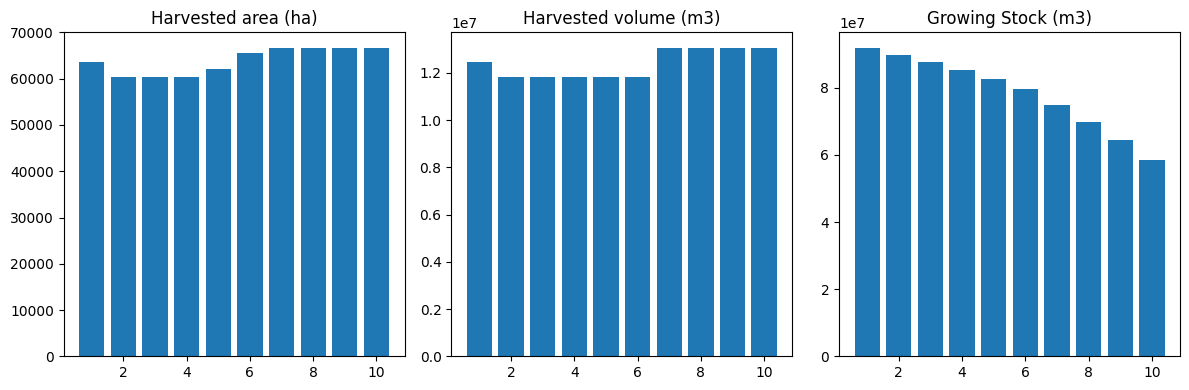

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_evenflow_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  130901
The economic indicator (the provincial government revenues) is:  4464020
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


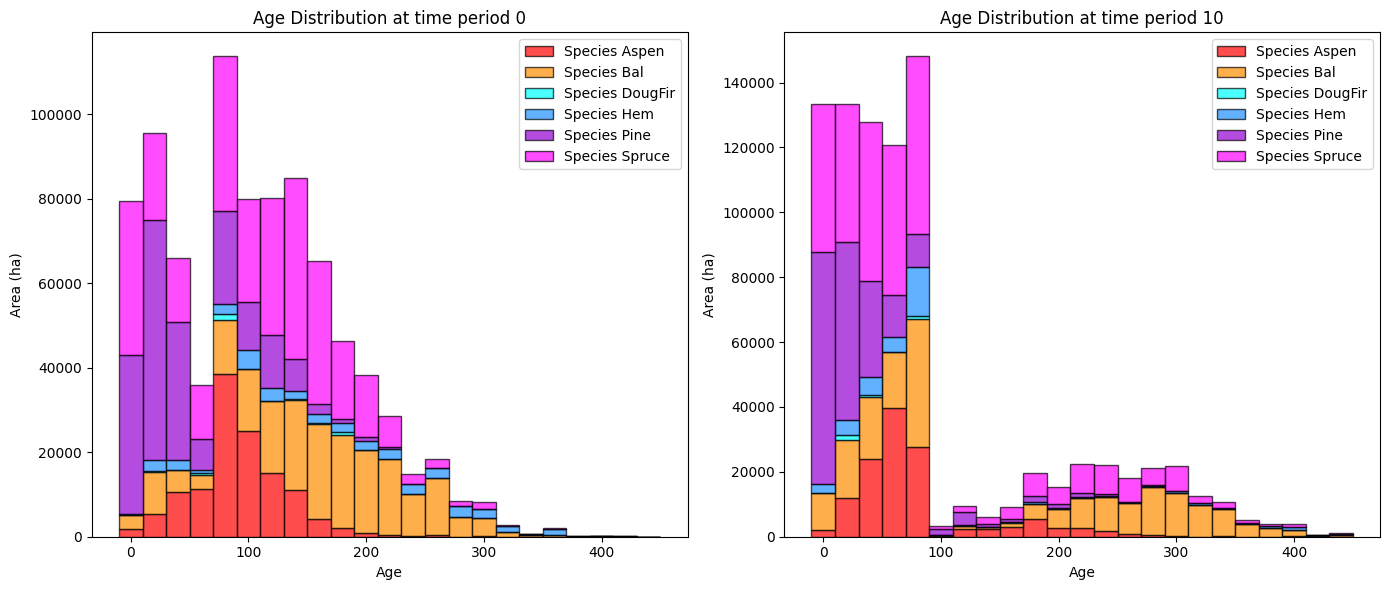

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   6126.874563 -13025.252666
DougFir    947.047810    387.176384   -559.871426
Bal      59315.970469  79882.187655  20566.217186
Spruce   36410.744598  52548.704990  16137.960392
Aspen    29632.731169  20673.275932  -8959.455237
Pine      7432.733686   6721.590051   -711.143635

Overall diversity has **increased** by 13448.45 hectares from time period 0 to time period 10.


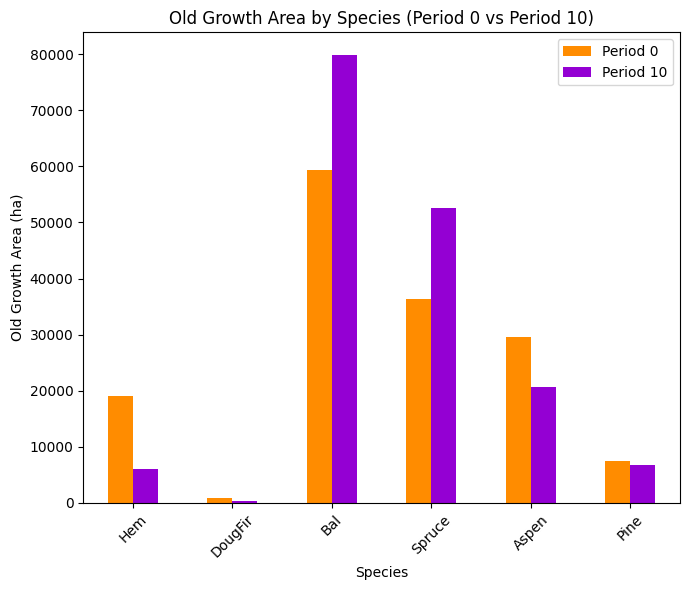

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7577

Diversity has **decreased** by 0.14% from time 0 to time 10.


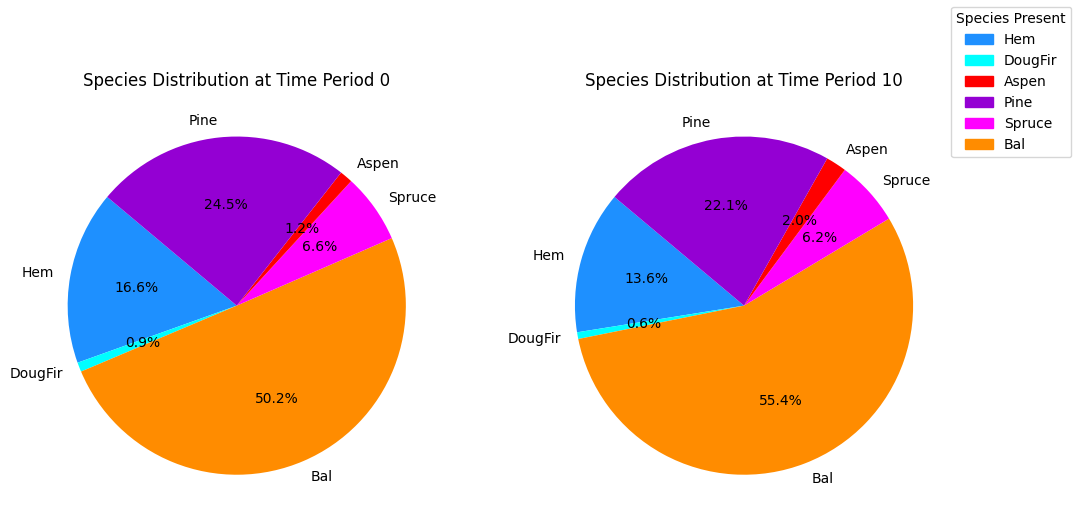

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_evenflow_cons_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.38s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Orde

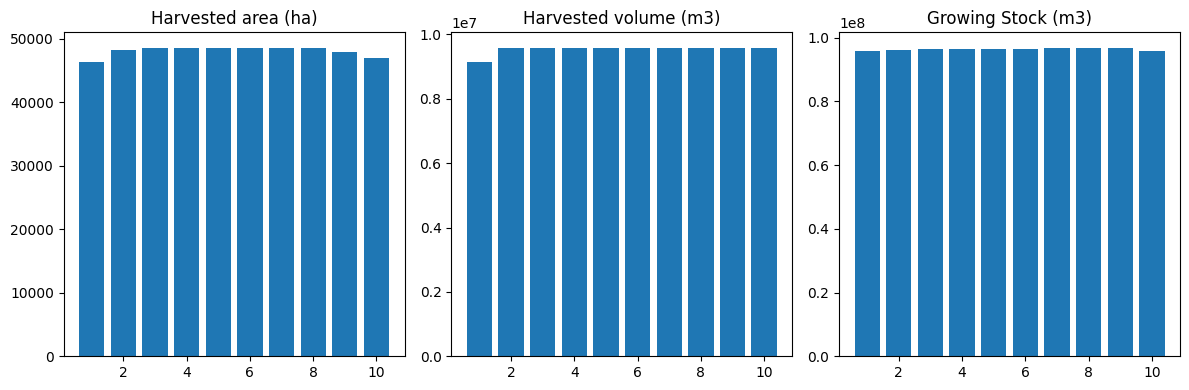

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


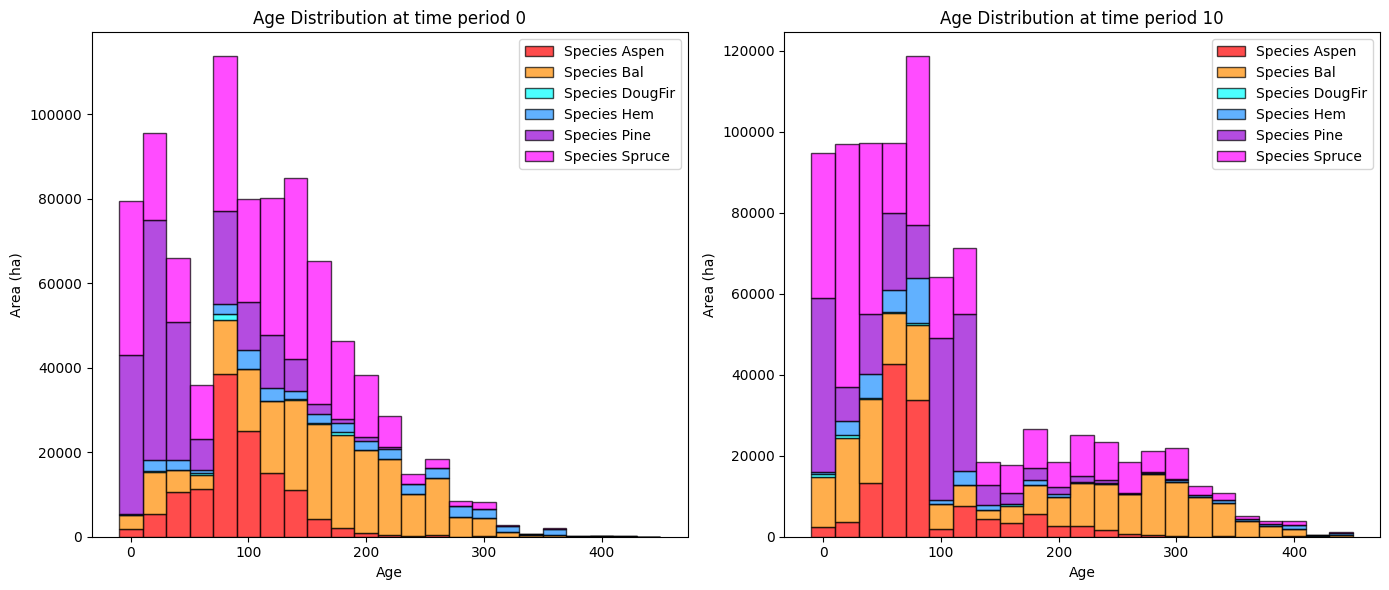

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7867.427610 -11284.699619
DougFir    947.047810    656.427461   -290.620349
Bal      59315.970469  85384.032361  26068.061892
Spruce   36410.744598  58541.140685  22130.396087
Aspen    29632.731169  25732.222254  -3900.508915
Pine      7432.733686  17416.131995   9983.398309

Overall diversity has **increased** by 42706.03 hectares from time period 0 to time period 10.


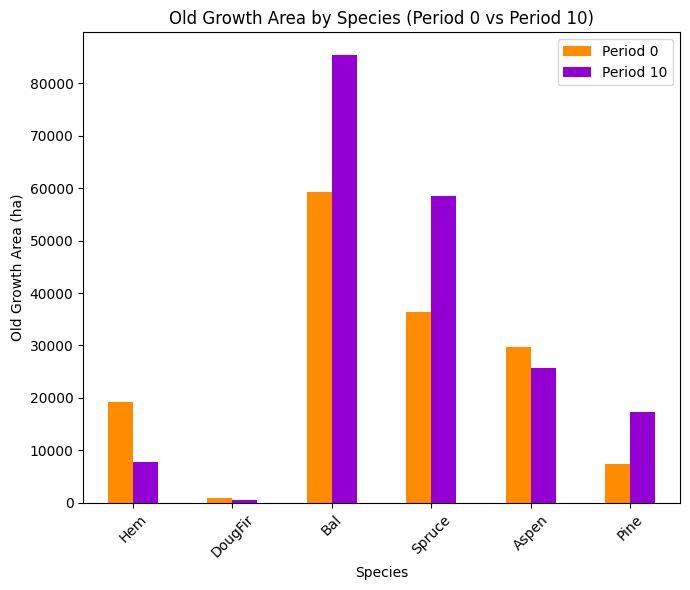

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7582

Diversity has **decreased** by 0.10% from time 0 to time 10.


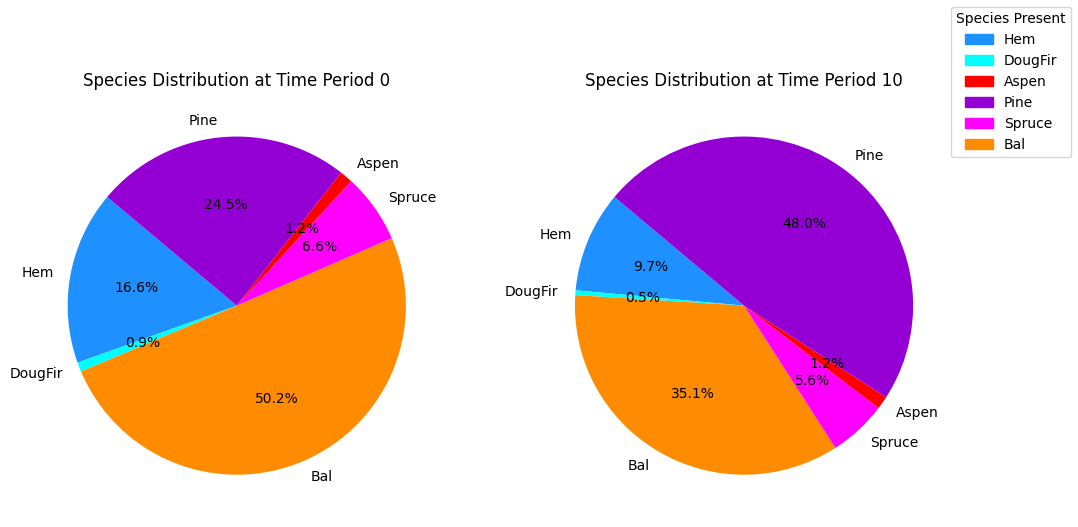

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


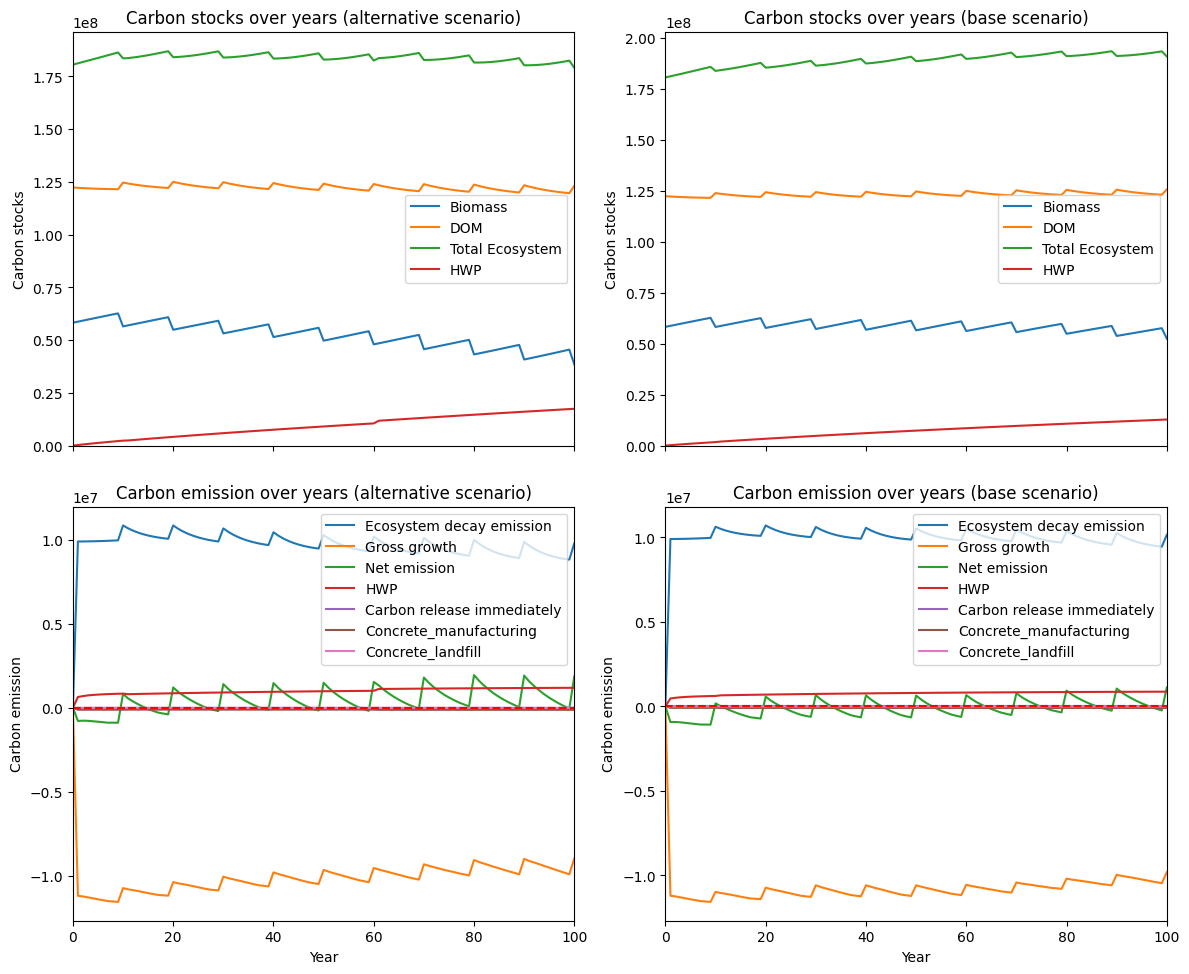

---------------------------------------------------------------------------------------
Net emission difference 8690350.824397966
Net emission base scenario -3032745.860741644
Net emission alternative scenario -11723096.685139613
dollar_per_ton is:  1.150701531165488
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  -1740.553047  -1740.553047
DougFir  0.0   -269.251077   -269.251077
Bal      0.0  -5501.844706  -5501.844706
Spruce   0.0  -5992.435695  -5992.435695
Aspen    0.0  -5058.946322  -5058.946322
Pine     0.0 -10694.541944 -10694.541944

Overall, the old growth area has **decreased** by -29257.57 hectares in the alternative scenario compared to the base scenario.


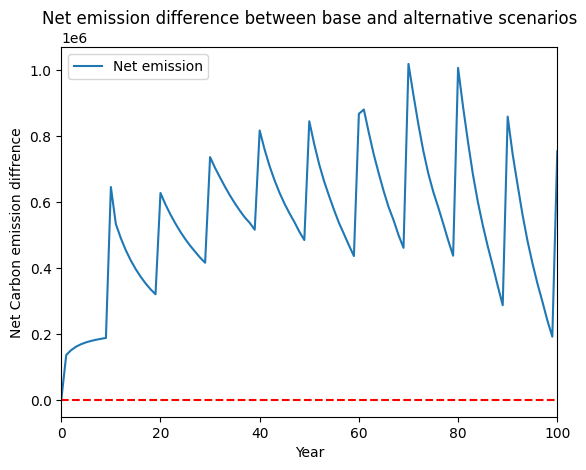

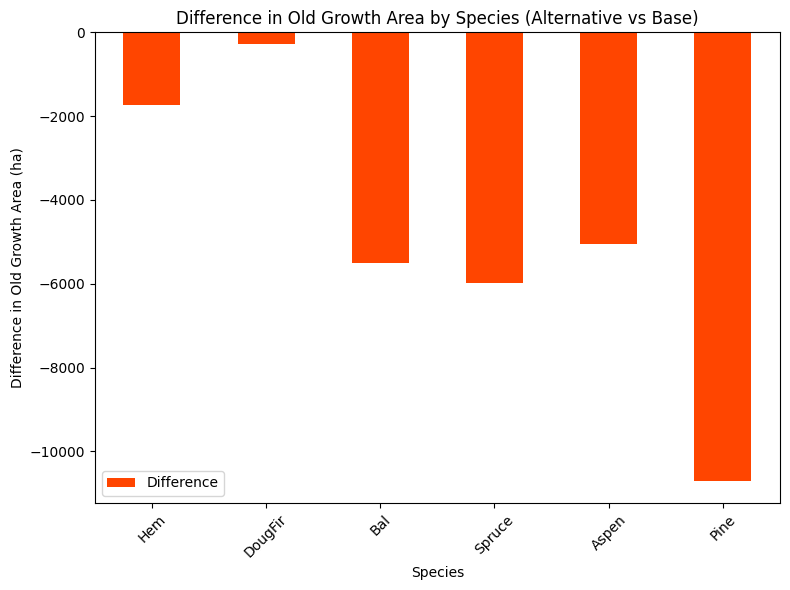

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


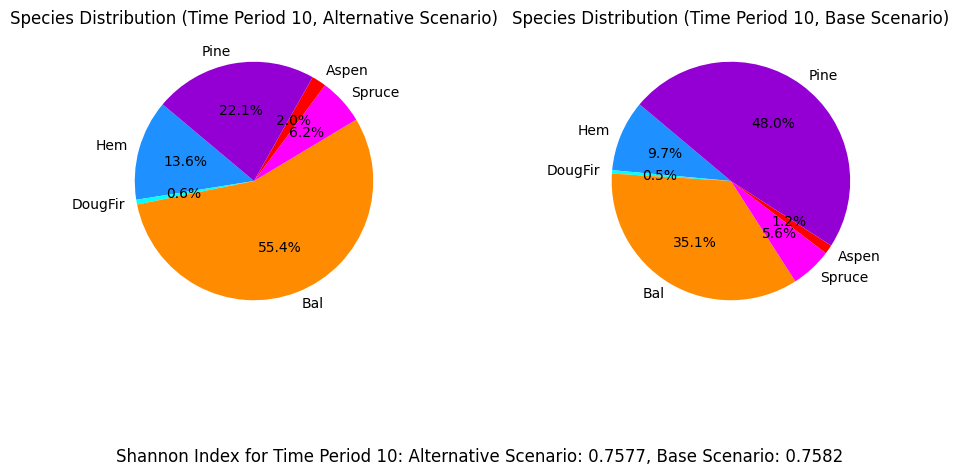

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_90%...
running the scenario for the Equity Silver mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xf69f1cc9
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.35s
Presolved: 8375 r

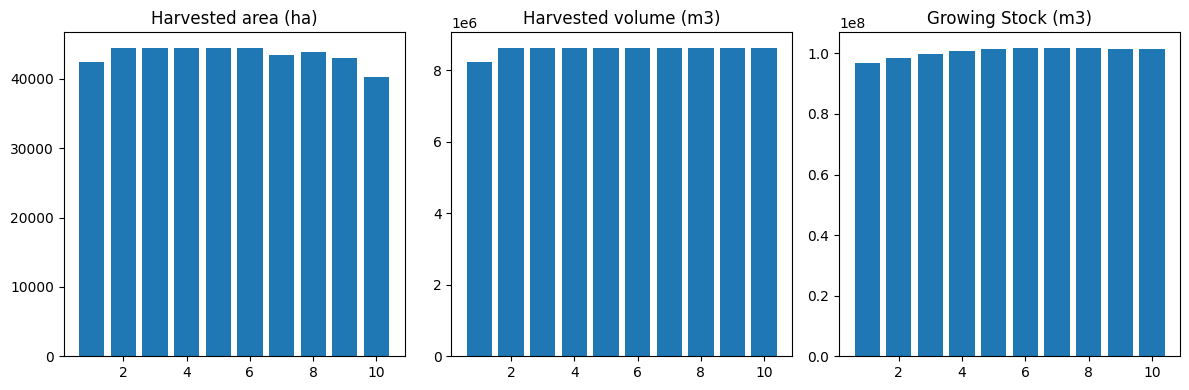

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_90%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  90757
The economic indicator (the provincial government revenues) is:  3095039
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


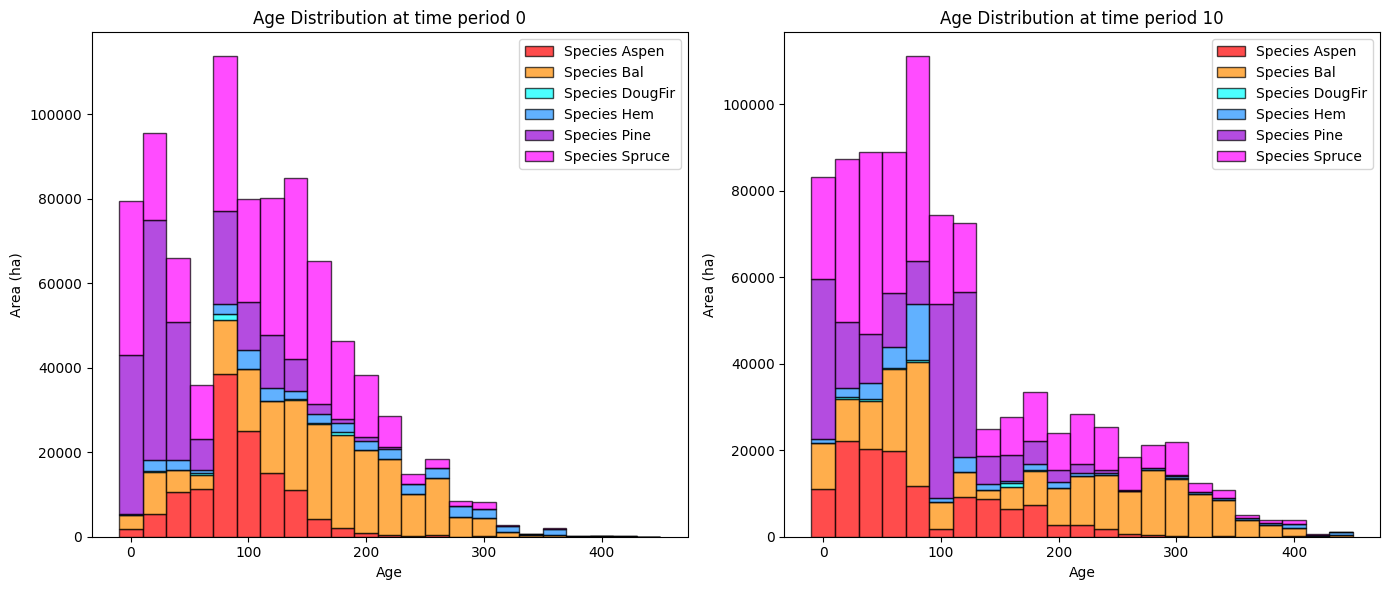

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   9100.780563 -10051.346666
DougFir    947.047810   1229.441069    282.393259
Bal      59315.970469  89453.984153  30138.013684
Spruce   36410.744598  64534.648011  28123.903413
Aspen    29632.731169  35002.690111   5369.958942
Pine      7432.733686  23601.059488  16168.325802

Overall diversity has **increased** by 70031.25 hectares from time period 0 to time period 10.


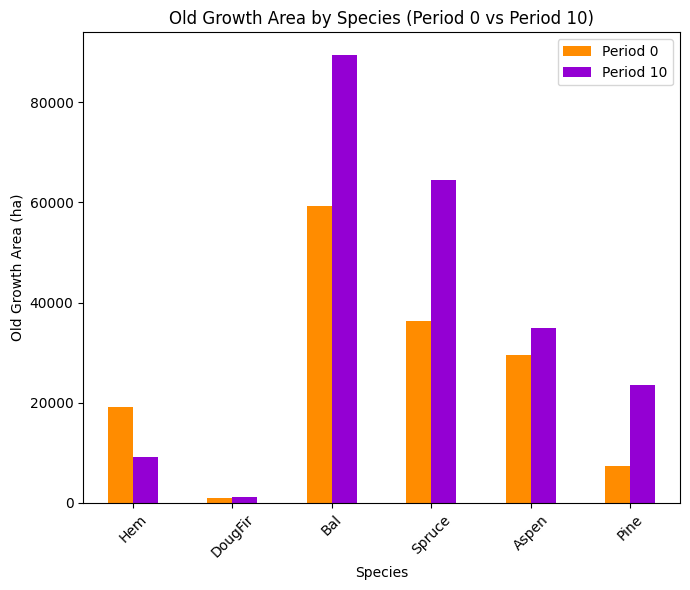

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7607

Diversity has **increased** by 0.15% from time 0 to time 10.


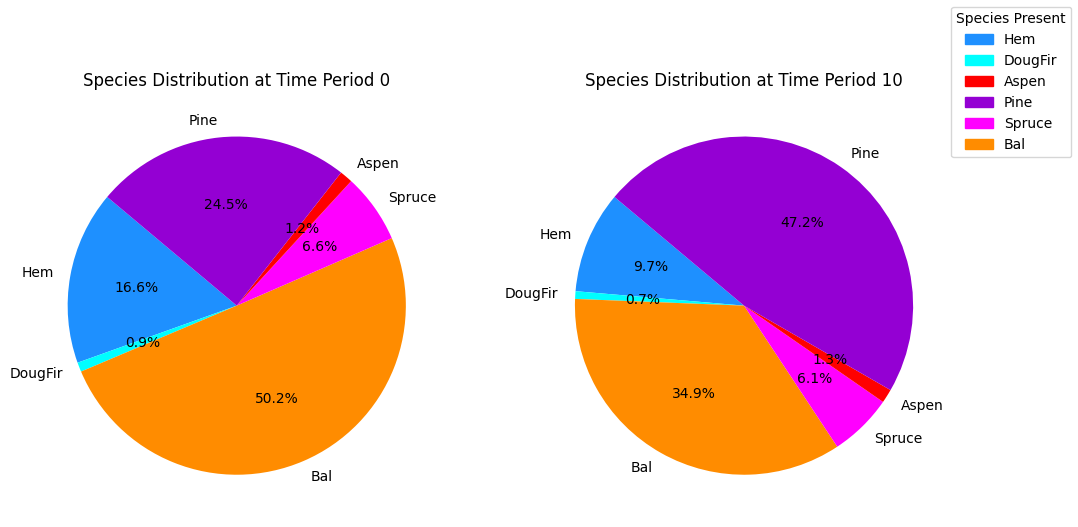

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_90%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.33s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

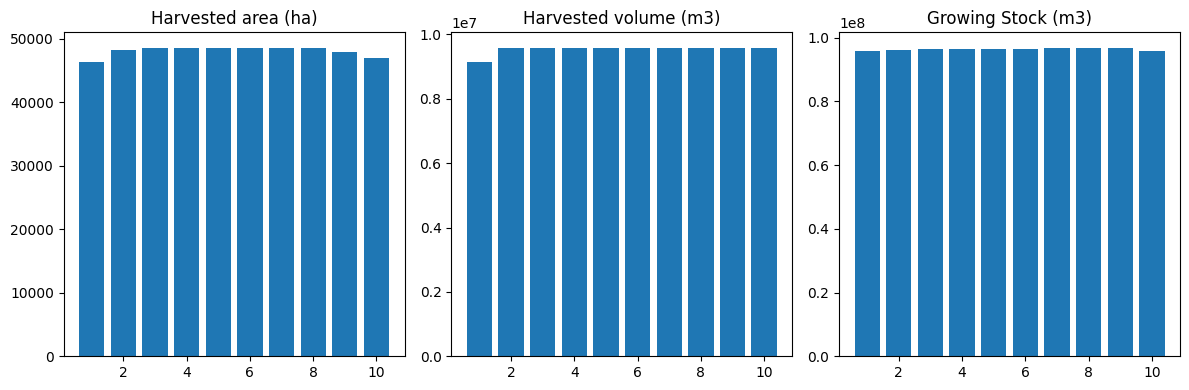

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


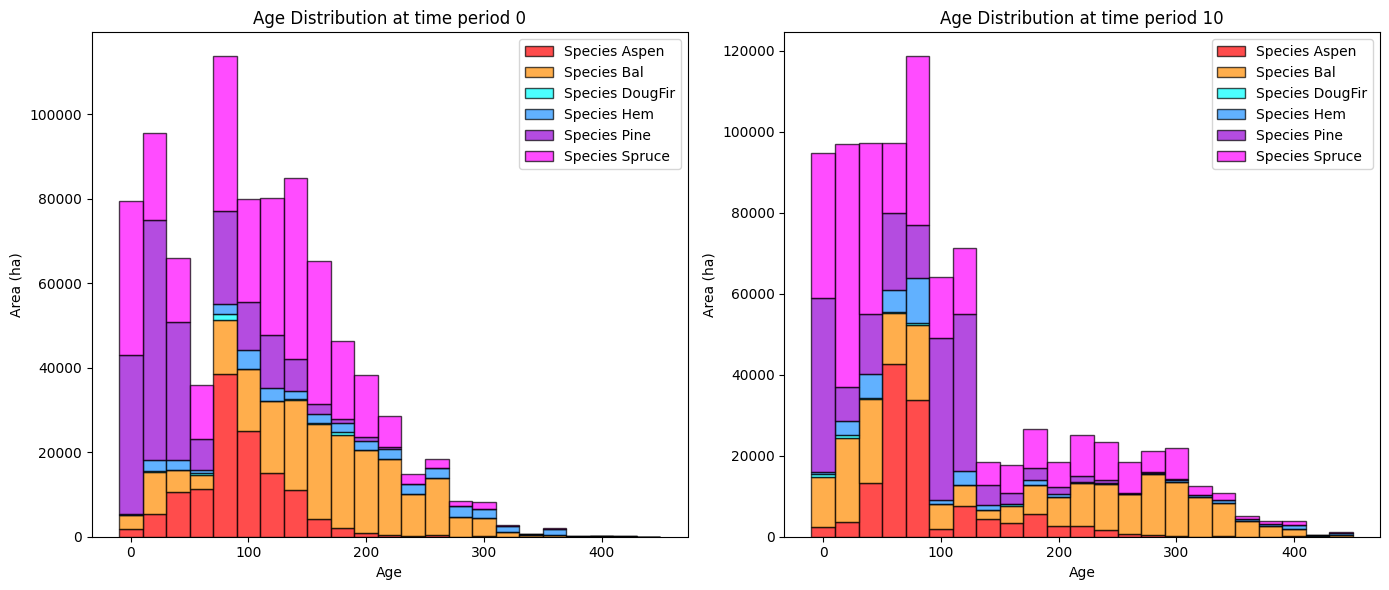

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7867.427610 -11284.699619
DougFir    947.047810    656.427461   -290.620349
Bal      59315.970469  85384.032361  26068.061892
Spruce   36410.744598  58541.140685  22130.396087
Aspen    29632.731169  25732.222254  -3900.508915
Pine      7432.733686  17416.131995   9983.398309

Overall diversity has **increased** by 42706.03 hectares from time period 0 to time period 10.


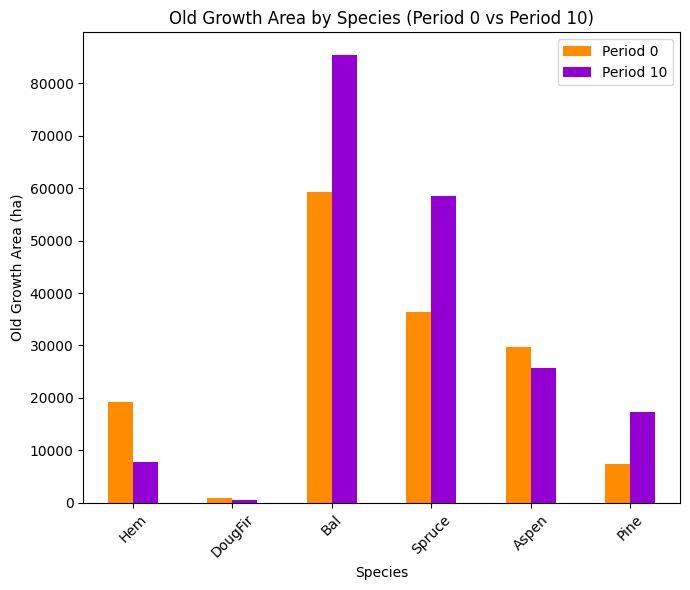

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7582

Diversity has **decreased** by 0.10% from time 0 to time 10.


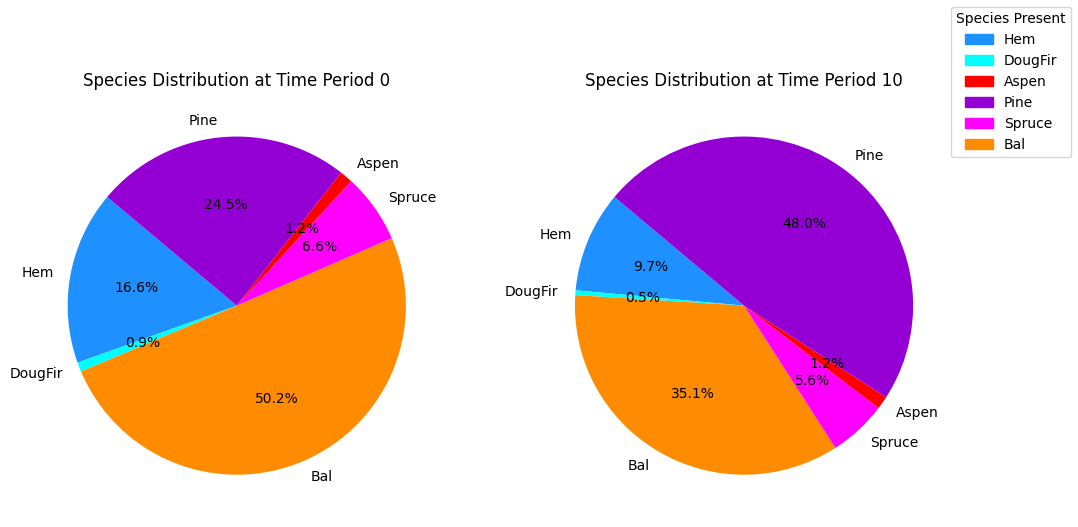

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


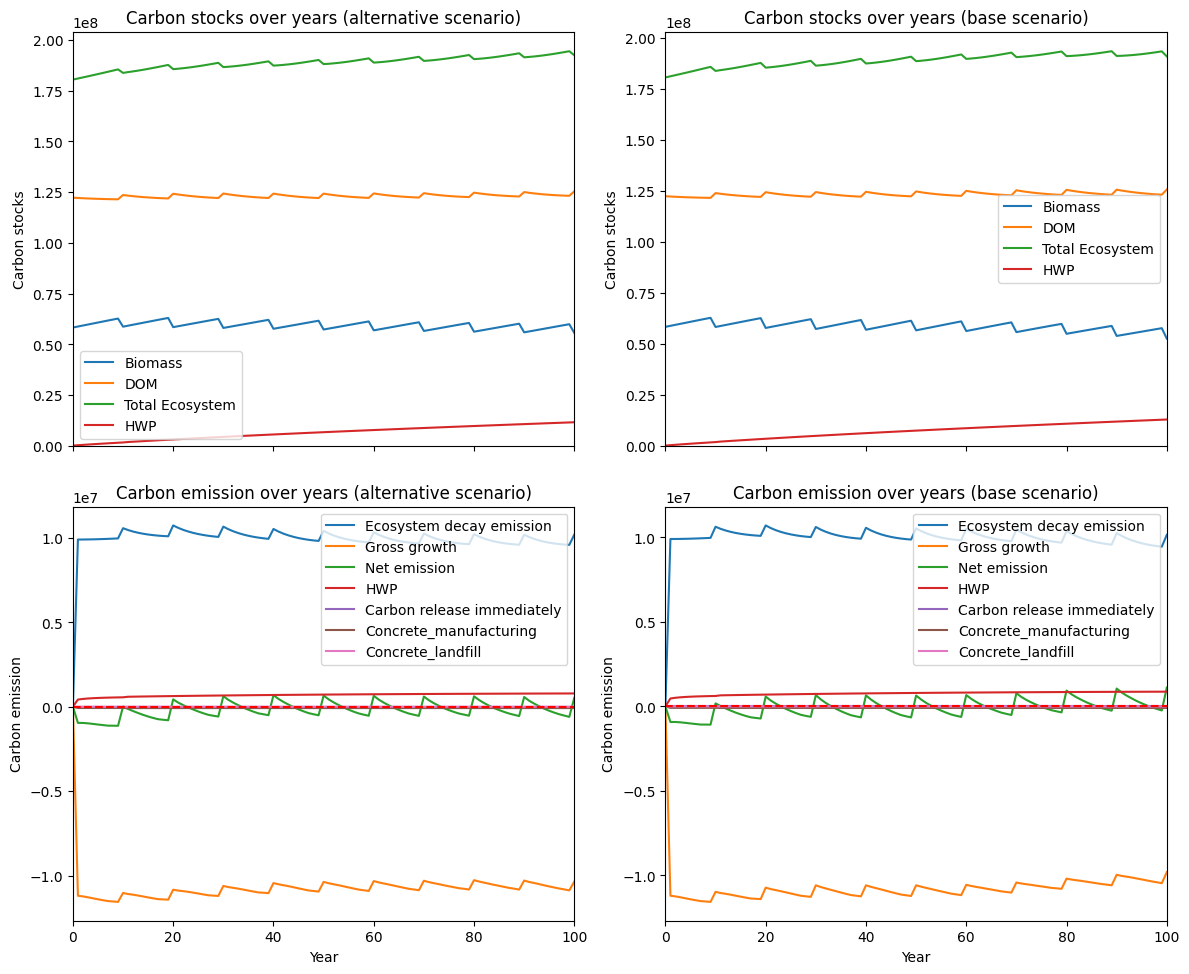

---------------------------------------------------------------------------------------
Net emission difference -2030542.825780888
Net emission base scenario -13753639.510920499
Net emission alternative scenario -11723096.685139613
dollar_per_ton is:  4.924791475971106
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Hem      0.0  1233.352953  1233.352953
DougFir  0.0   573.013608   573.013608
Bal      0.0  4069.951791  4069.951791
Spruce   0.0  5993.507326  5993.507326
Aspen    0.0  9270.467857  9270.467857
Pine     0.0  6184.927493  6184.927493

Overall, the old growth area has **increased** by 27325.22 hectares in the alternative scenario compared to the base scenario.


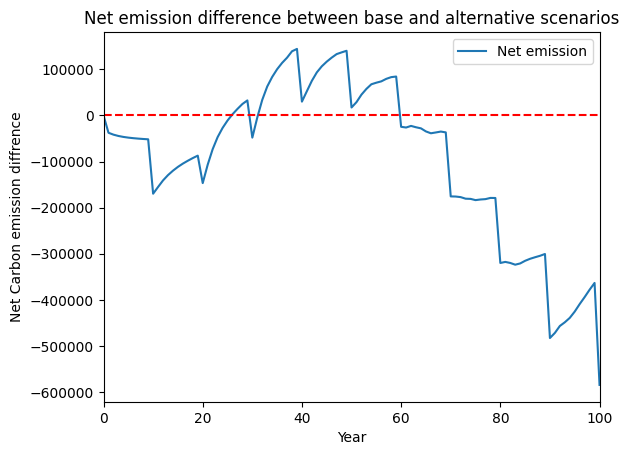

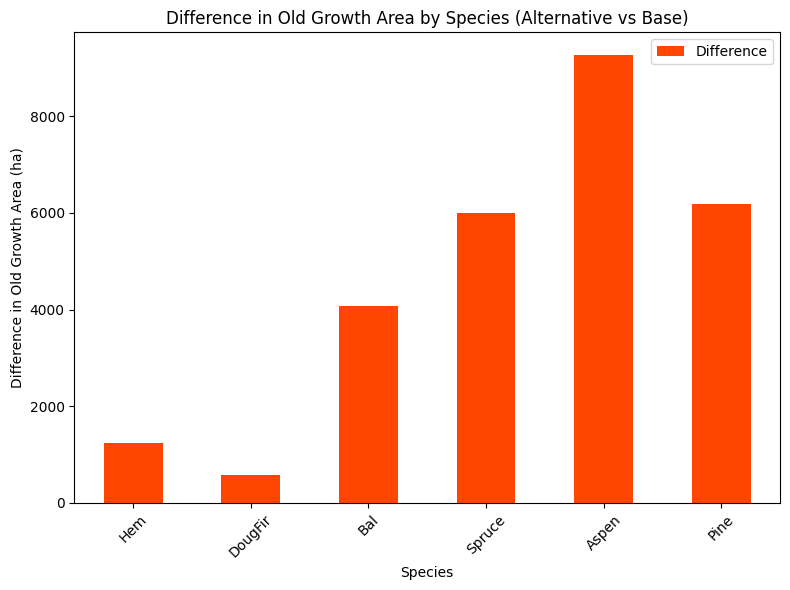

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


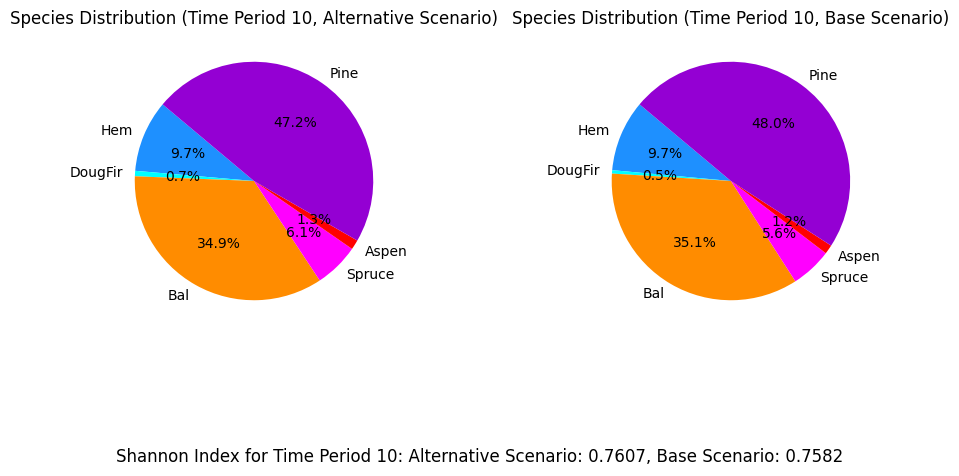

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_80%...
running the scenario for the Equity Silver mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xf03cc22f
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.35s
Presolved: 8375 r

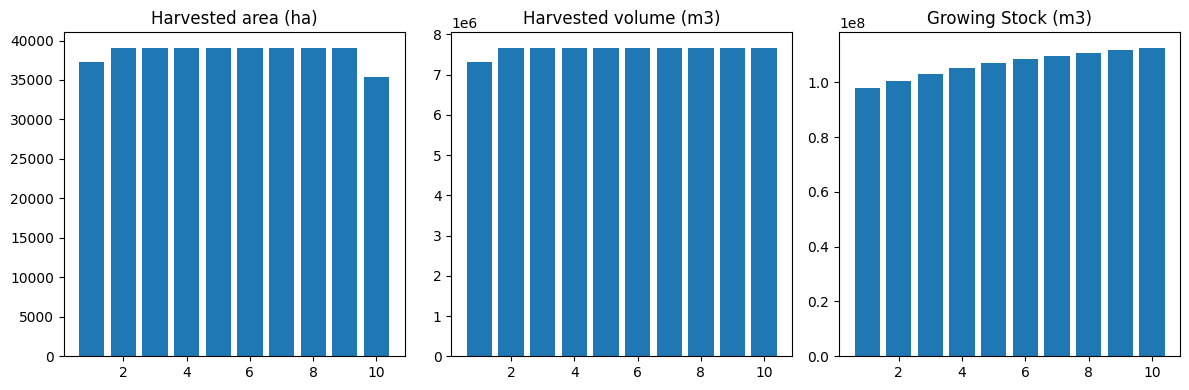

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_80%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  80673
The economic indicator (the provincial government revenues) is:  2751146
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


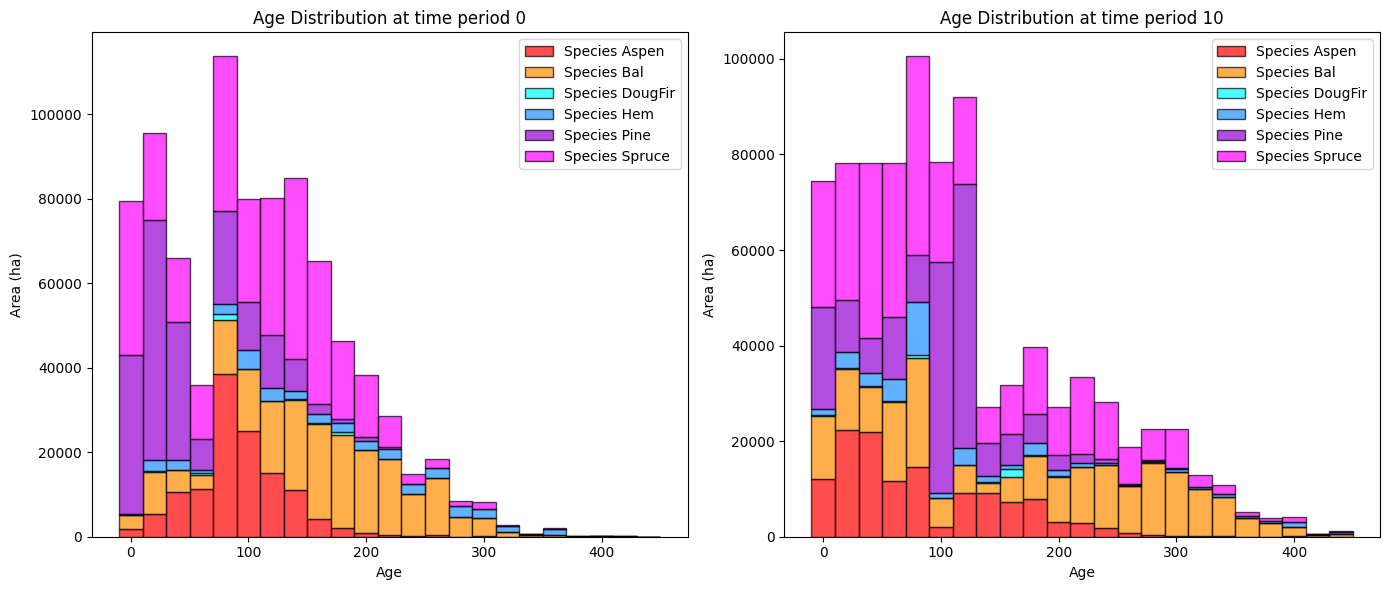

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   9961.792328  -9190.334901
DougFir    947.047810   1659.339296    712.291486
Bal      59315.970469  91921.303502  32605.333034
Spruce   36410.744598  77188.527958  40777.783360
Aspen    29632.731169  37361.027210   7728.296041
Pine      7432.733686  29357.953856  21925.220170

Overall diversity has **increased** by 94558.59 hectares from time period 0 to time period 10.


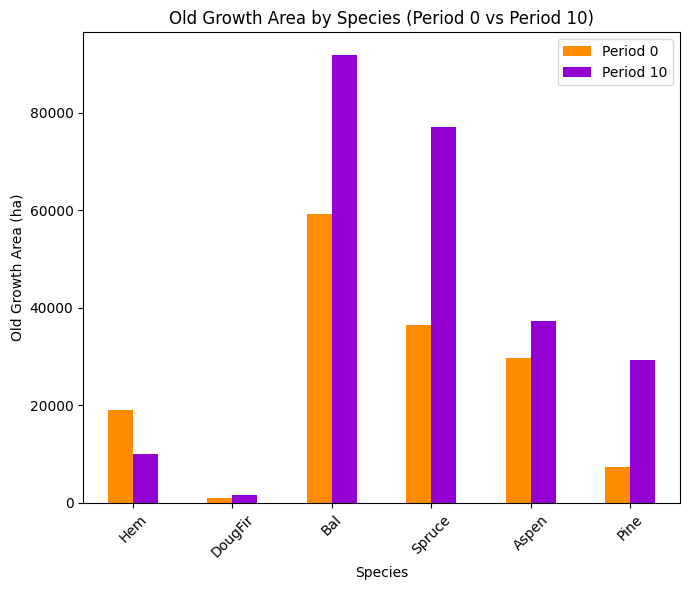

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7514

Diversity has **decreased** by 0.78% from time 0 to time 10.


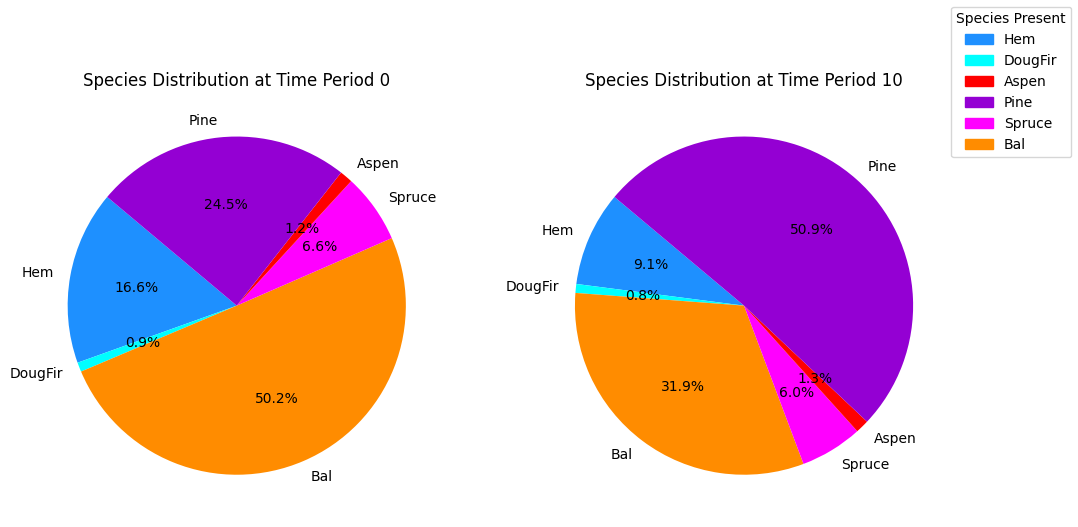

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_80%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.33s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

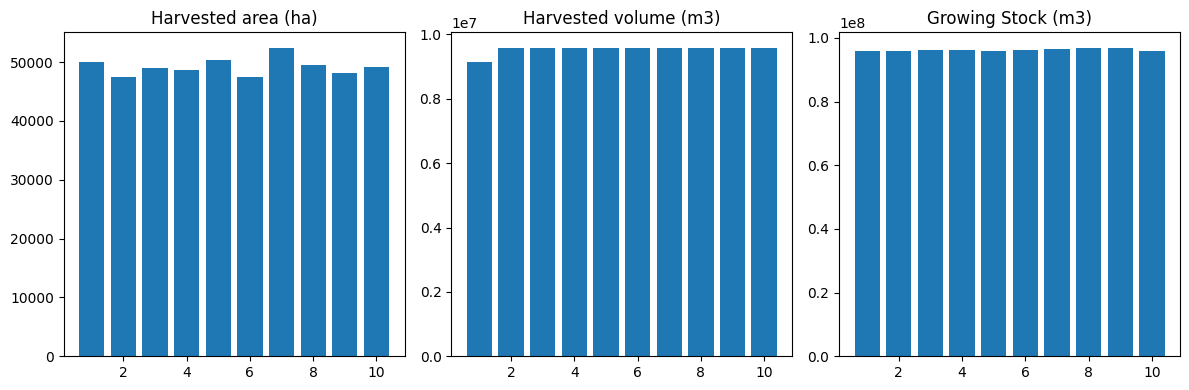

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


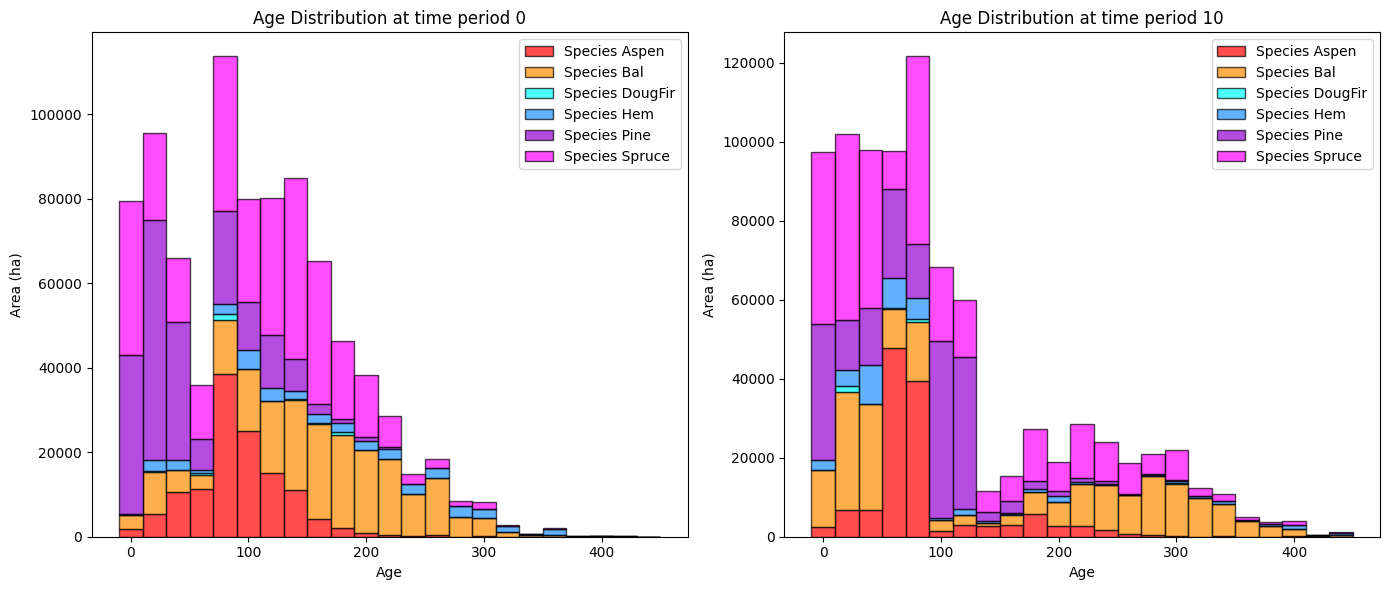

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7420.003864 -11732.123365
DougFir    947.047810    588.823746   -358.224064
Bal      59315.970469  83662.092085  24346.121617
Spruce   36410.744598  67222.186953  30811.442355
Aspen    29632.731169  21366.865973  -8265.865196
Pine      7432.733686  16124.525134   8691.791448

Overall diversity has **increased** by 43493.14 hectares from time period 0 to time period 10.


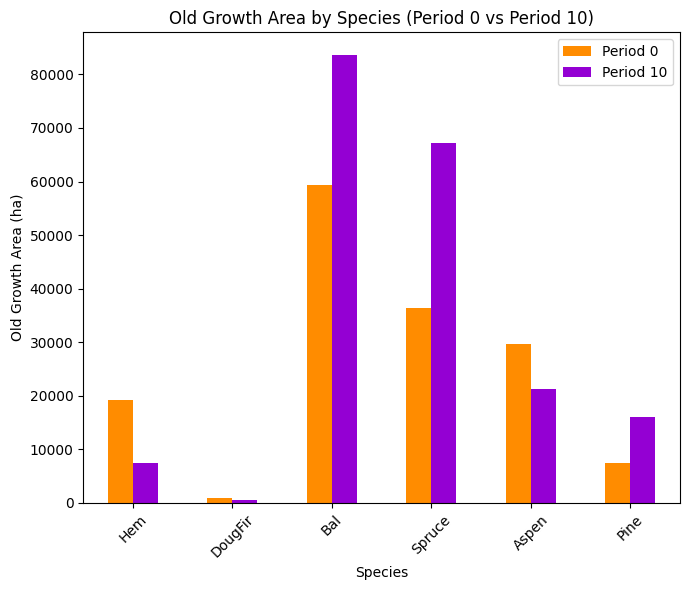

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7329

Diversity has **decreased** by 2.63% from time 0 to time 10.


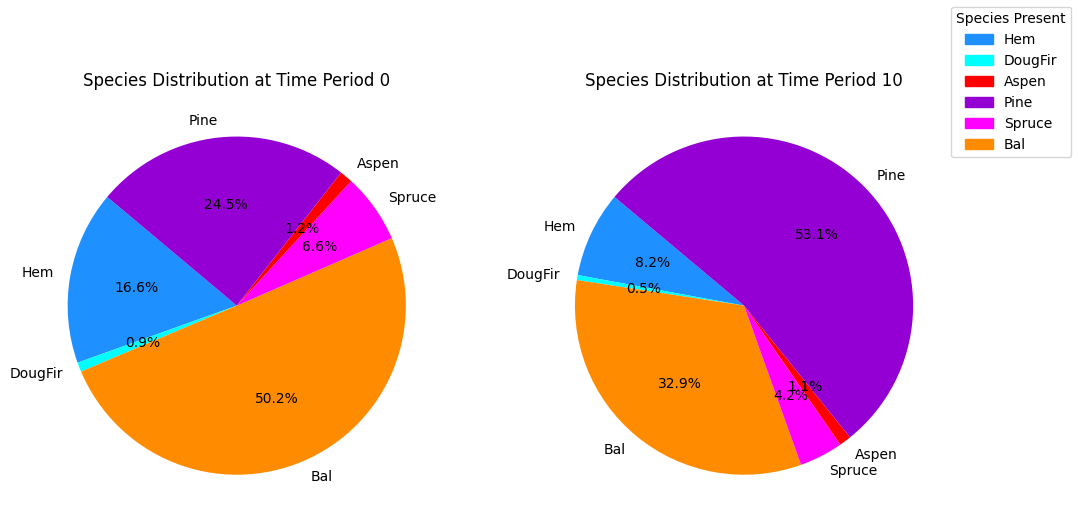

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


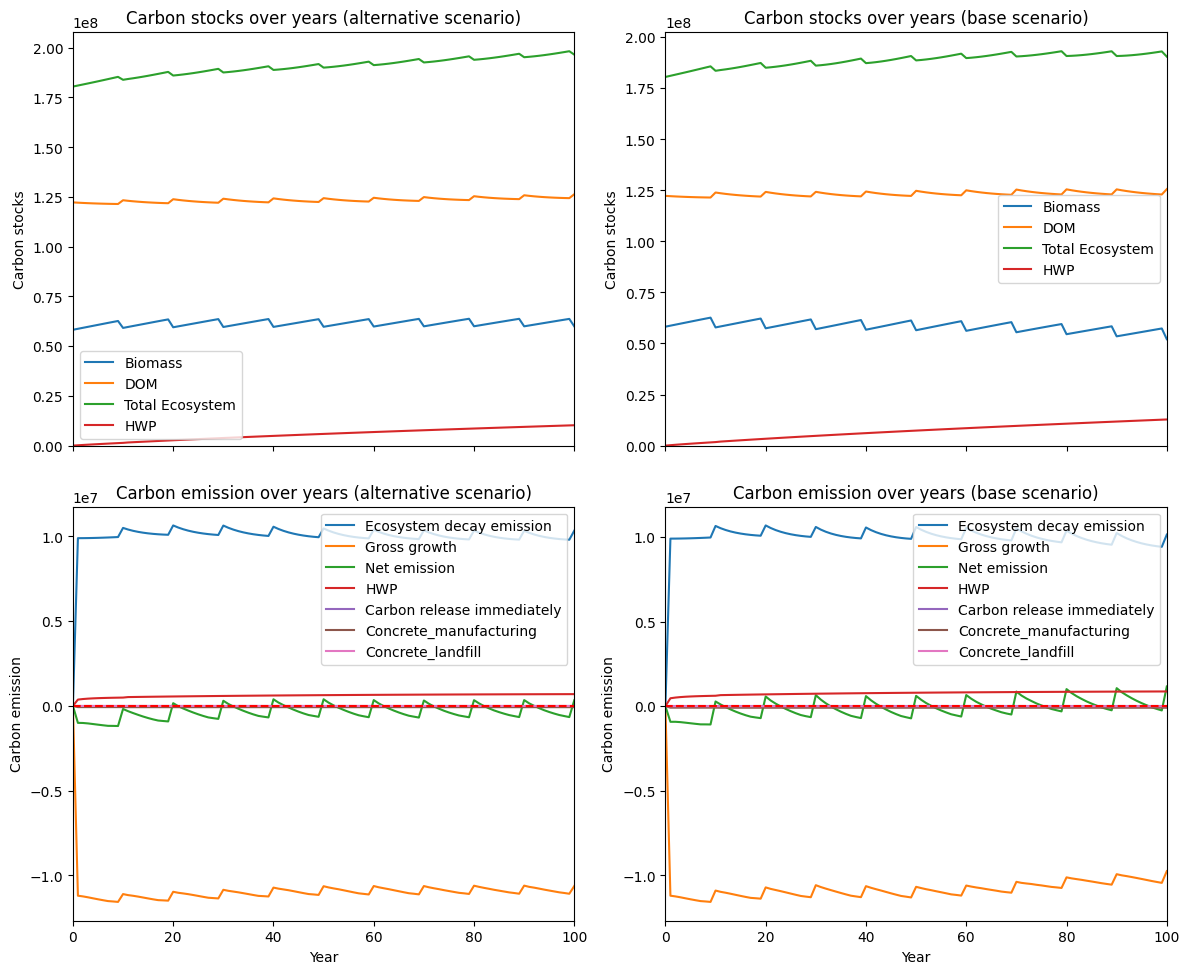

---------------------------------------------------------------------------------------
Net emission difference -5477496.625590283
Net emission base scenario -16804527.09327943
Net emission alternative scenario -11327030.467689143
dollar_per_ton is:  1.8256515126419357
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   2541.788464   2541.788464
DougFir  0.0   1070.515550   1070.515550
Bal      0.0   8259.211417   8259.211417
Spruce   0.0   9966.341005   9966.341005
Aspen    0.0  15994.161237  15994.161237
Pine     0.0  13233.428722  13233.428722

Overall, the old growth area has **increased** by 51065.45 hectares in the alternative scenario compared to the base scenario.


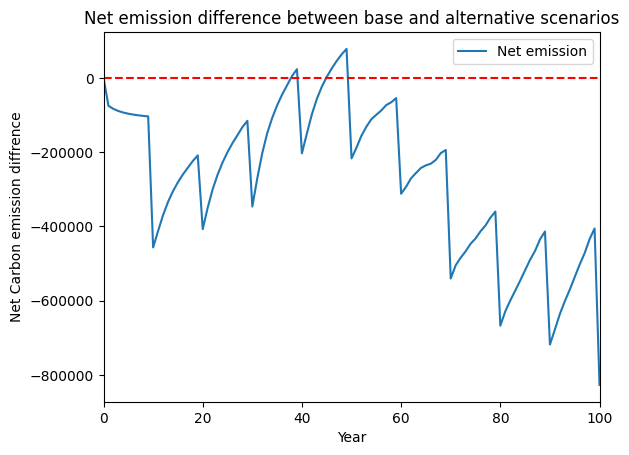

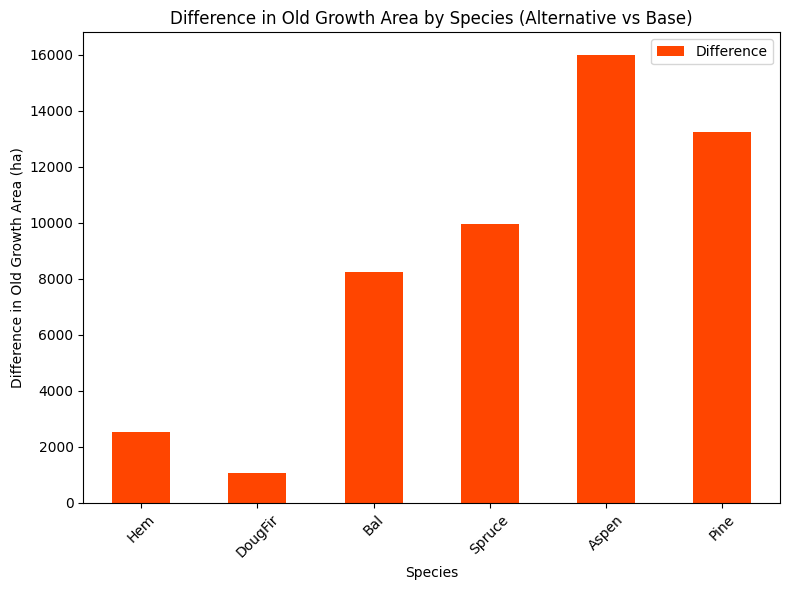

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


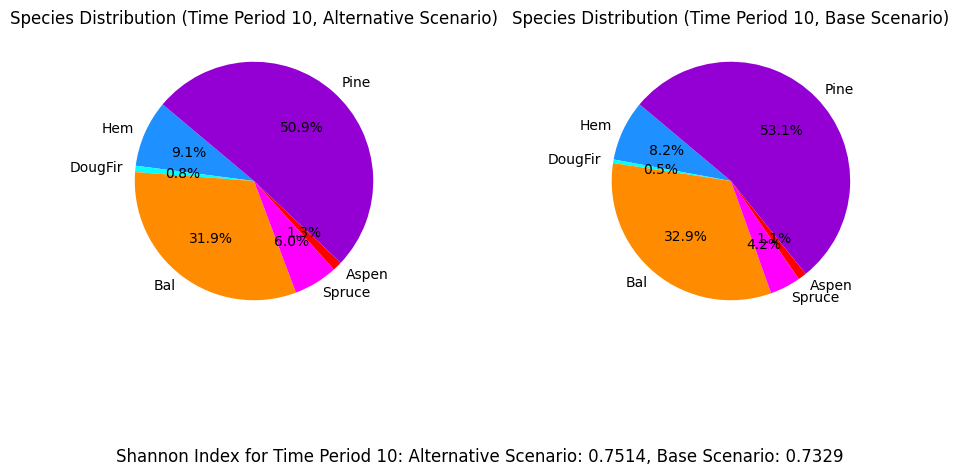

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_70%...
running the scenario for the Equity Silver mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x3c50dc23
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.32s
Presolved: 8375 r

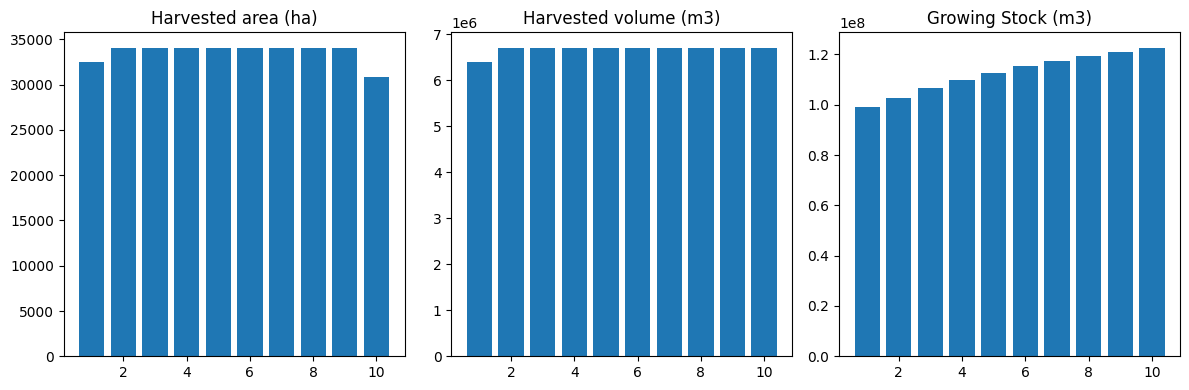

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_70%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  70589
The economic indicator (the provincial government revenues) is:  2407253
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


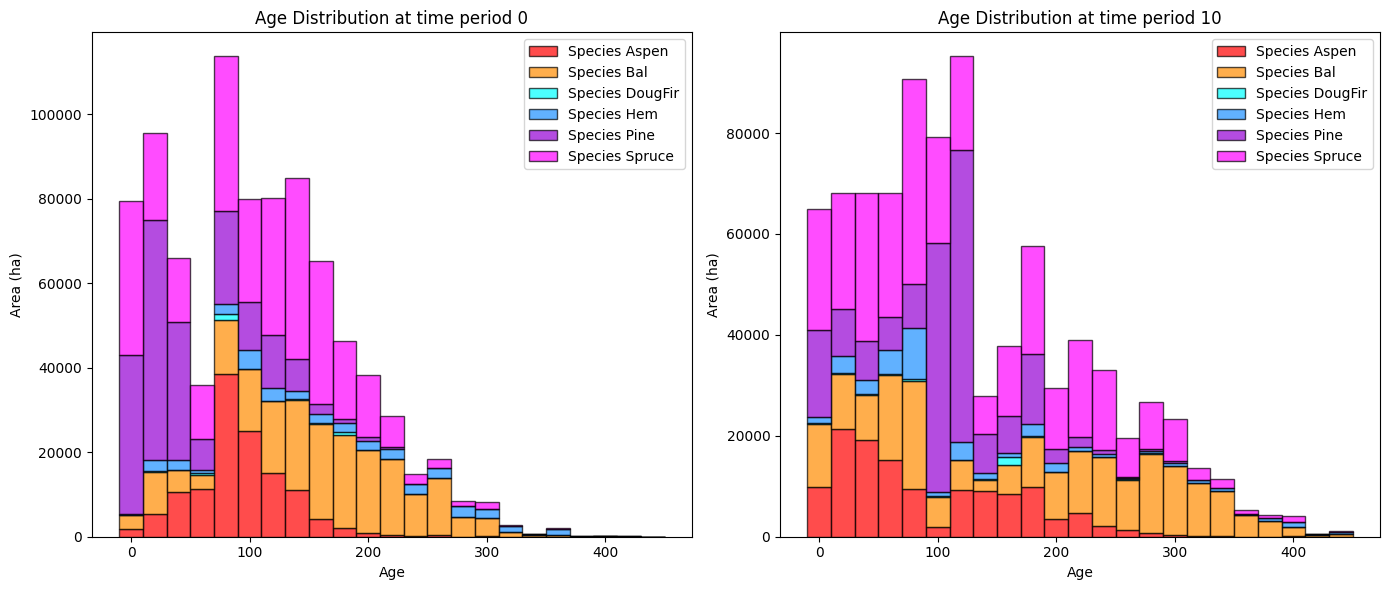

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229  10637.313019  -8514.814210
DougFir    947.047810   1821.364164    874.316354
Bal      59315.970469  96251.851968  36935.881499
Spruce   36410.744598  96471.441868  60060.697270
Aspen    29632.731169  44515.931355  14883.200186
Pine      7432.733686  37180.539833  29747.806147

Overall diversity has **increased** by 133987.09 hectares from time period 0 to time period 10.


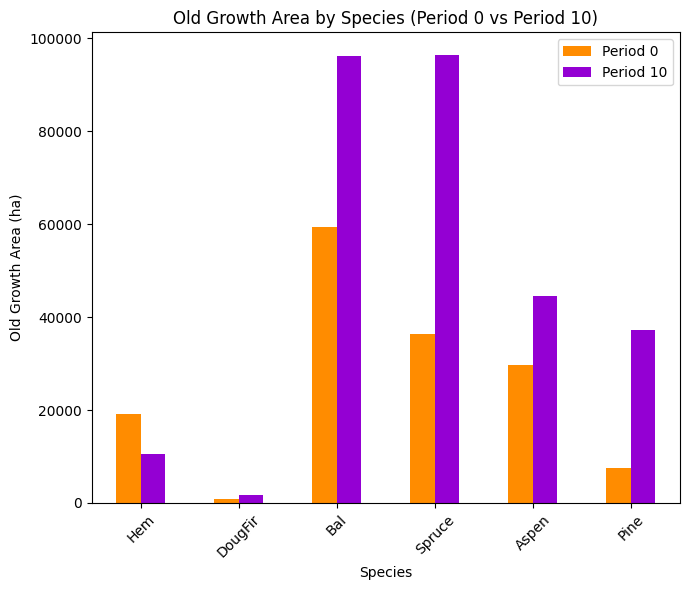

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7445

Diversity has **decreased** by 1.46% from time 0 to time 10.


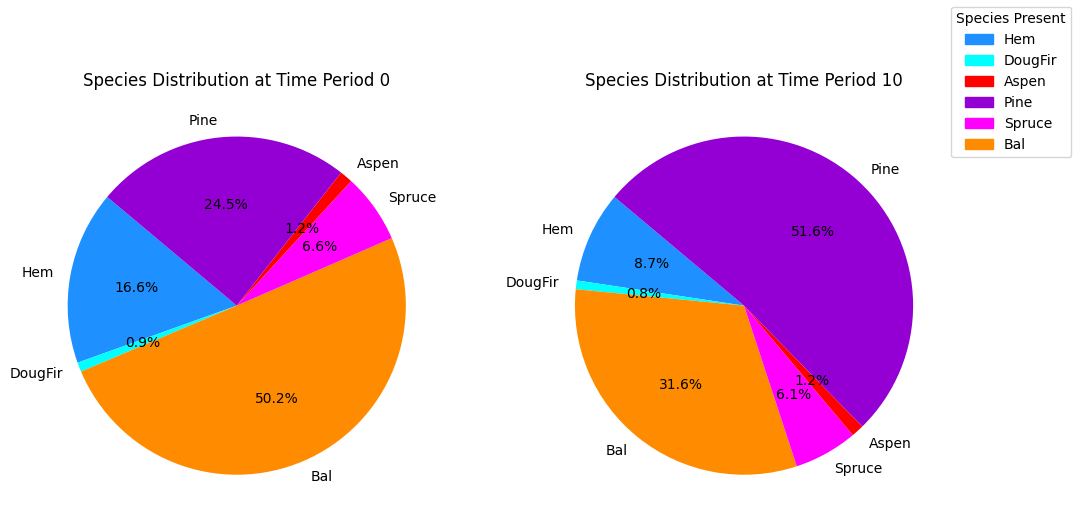

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_70%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.35s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

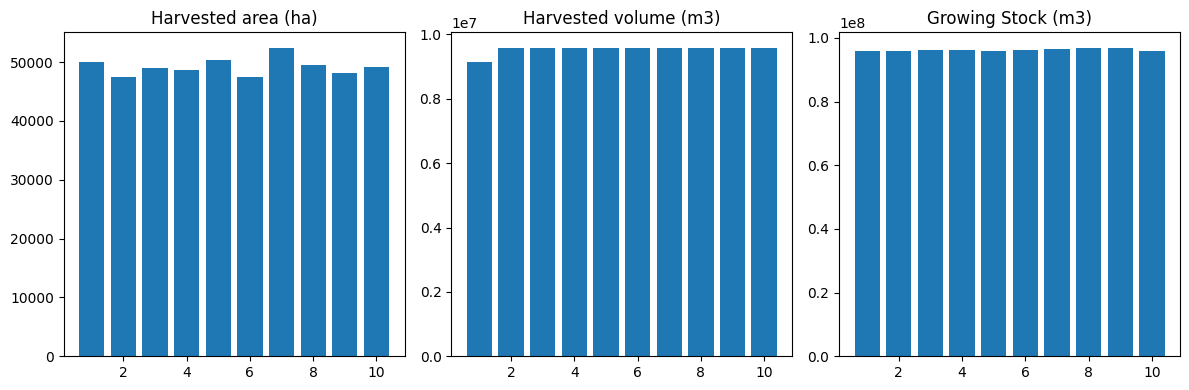

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


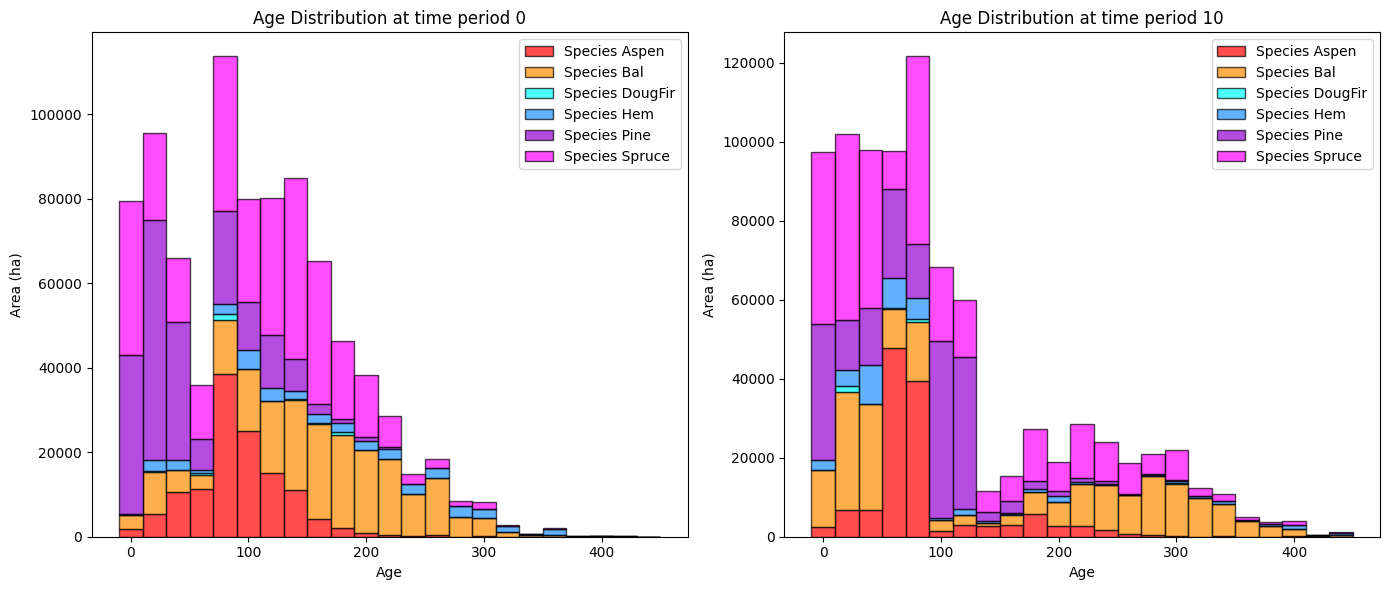

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7420.003864 -11732.123365
DougFir    947.047810    588.823746   -358.224064
Bal      59315.970469  83662.092085  24346.121617
Spruce   36410.744598  67222.186953  30811.442355
Aspen    29632.731169  21366.865973  -8265.865196
Pine      7432.733686  16124.525134   8691.791448

Overall diversity has **increased** by 43493.14 hectares from time period 0 to time period 10.


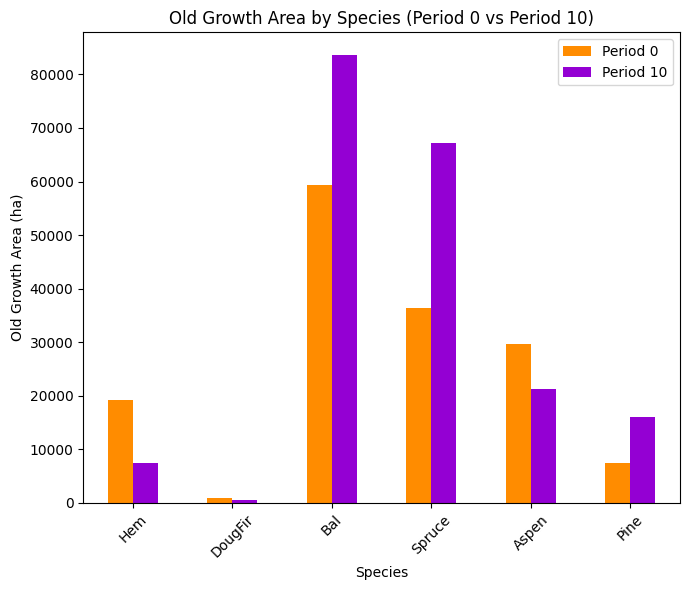

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7329

Diversity has **decreased** by 2.63% from time 0 to time 10.


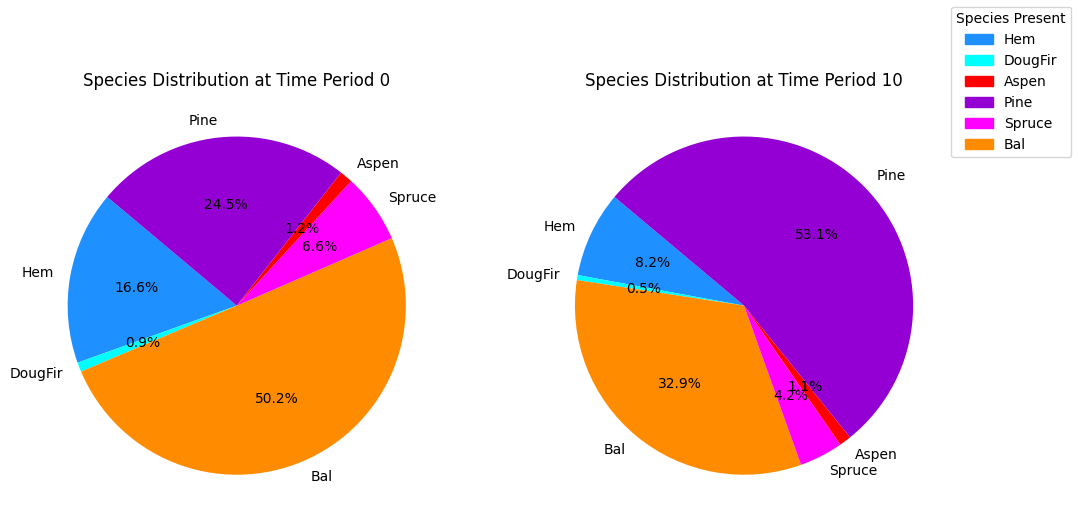

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


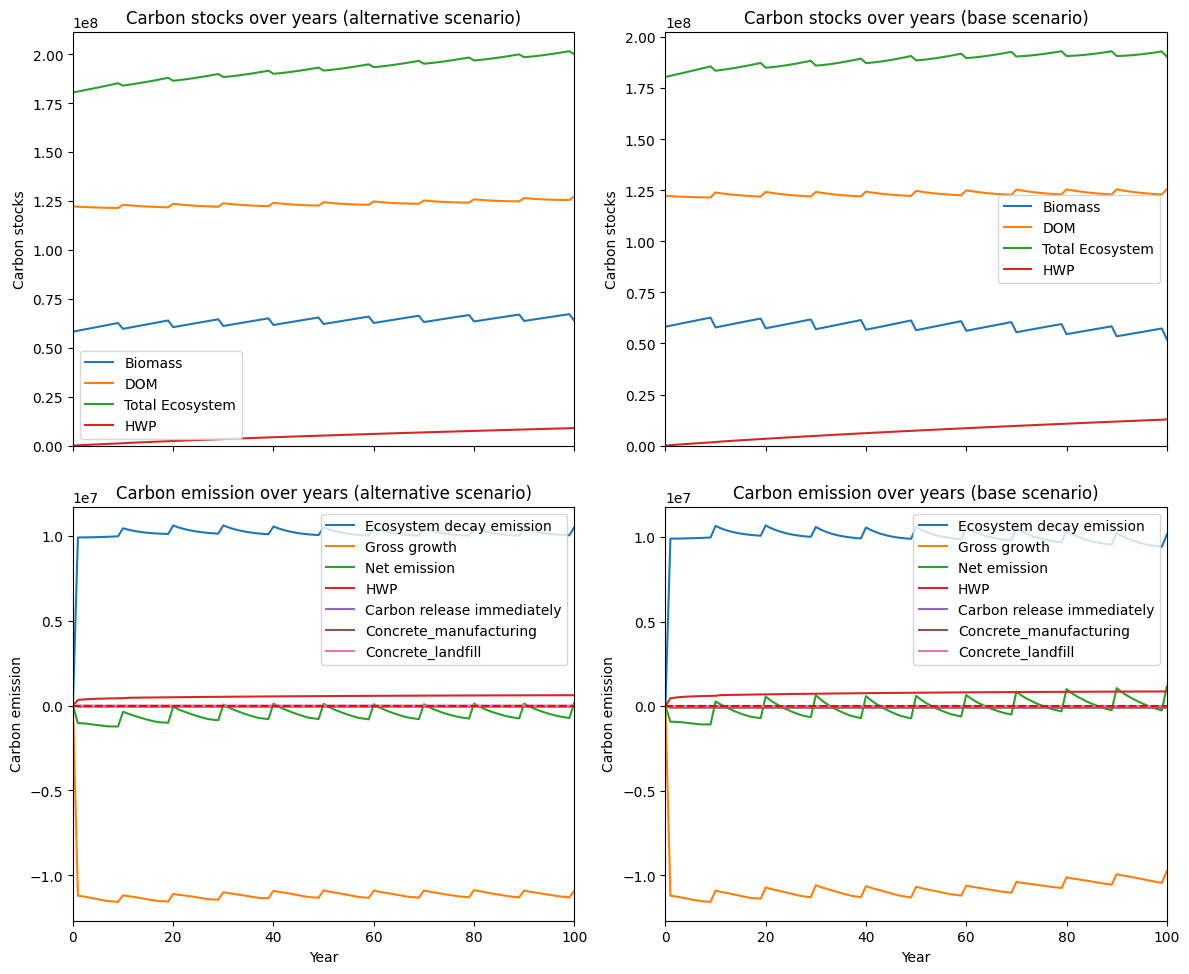

---------------------------------------------------------------------------------------
Net emission difference -8224170.491766579
Net emission base scenario -19551200.959455725
Net emission alternative scenario -11327030.467689143
dollar_per_ton is:  1.215928099984217
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   3217.309155   3217.309155
DougFir  0.0   1232.540418   1232.540418
Bal      0.0  12589.759882  12589.759882
Spruce   0.0  29249.254915  29249.254915
Aspen    0.0  23149.065382  23149.065382
Pine     0.0  21056.014699  21056.014699

Overall, the old growth area has **increased** by 90493.94 hectares in the alternative scenario compared to the base scenario.


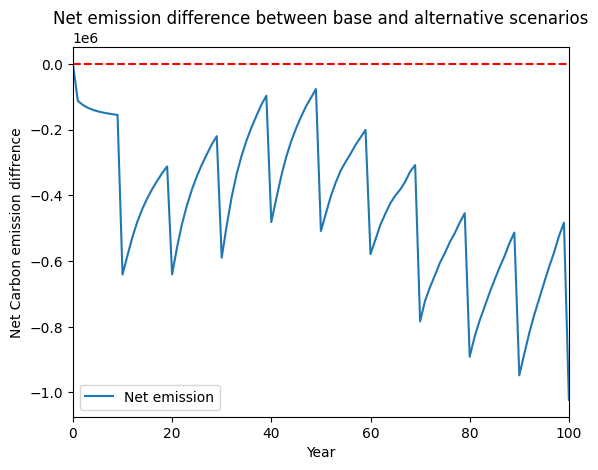

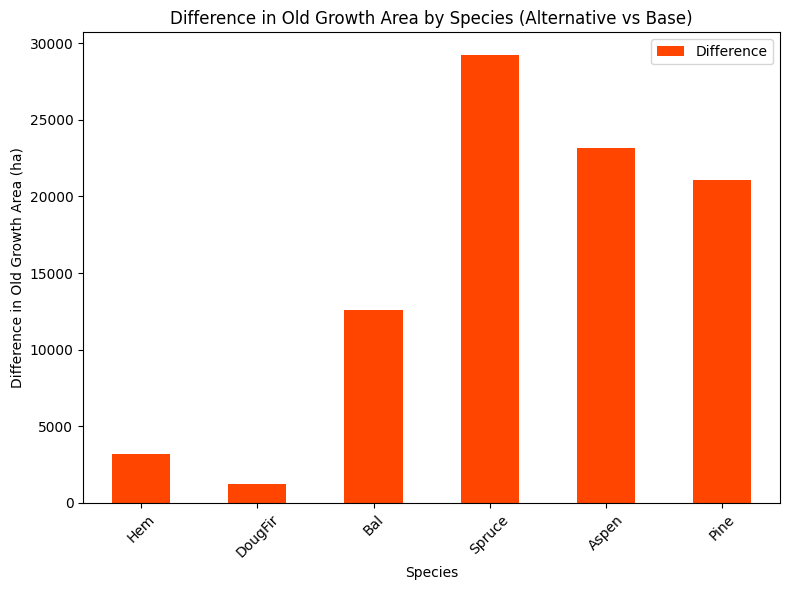

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


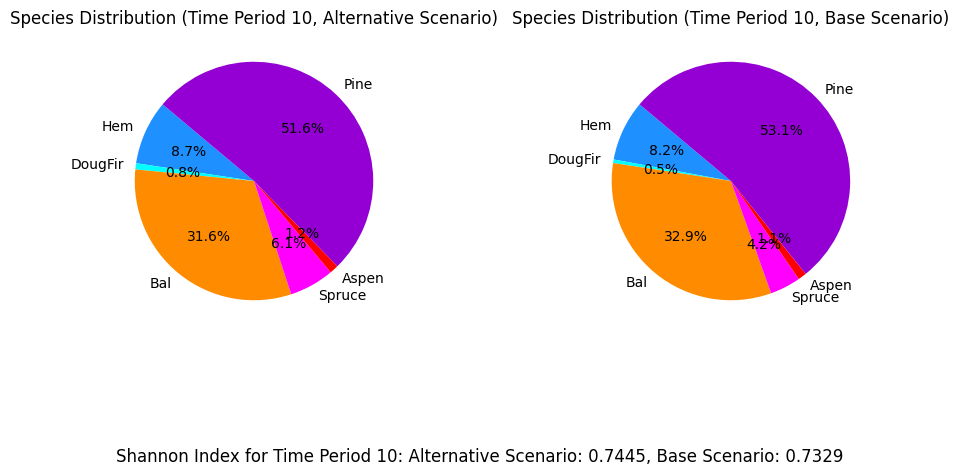

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_60%...
running the scenario for the Equity Silver mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xc30f4a9f
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.30s
Presolved: 8375 r

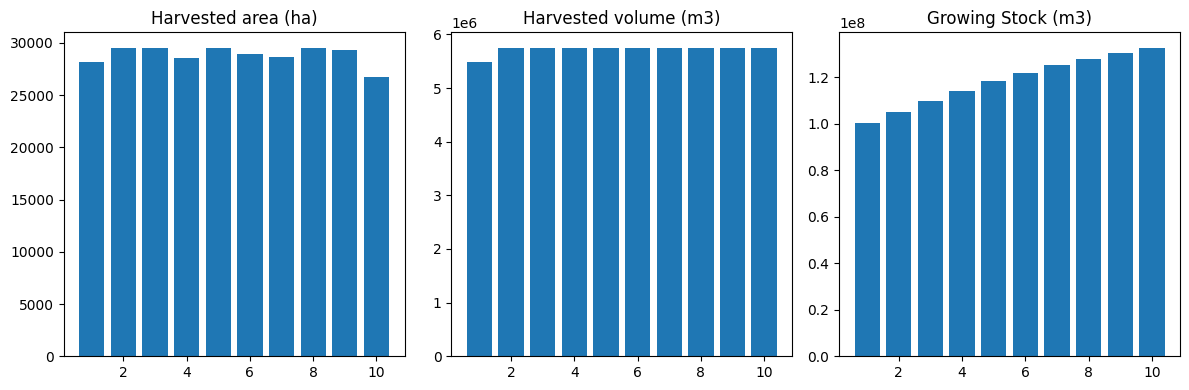

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_60%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  60505
The economic indicator (the provincial government revenues) is:  2063360
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


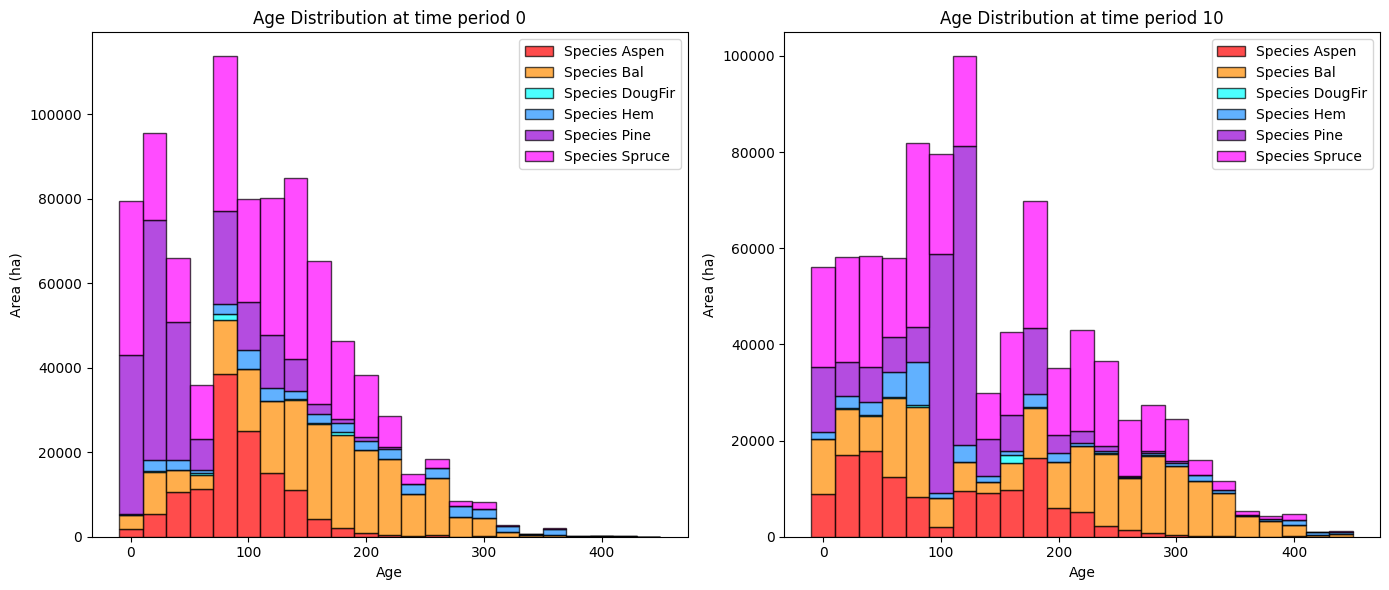

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10    Difference
Hem      19152.127229   12283.932343  -6868.194886
DougFir    947.047810    1846.575789    899.527978
Bal      59315.970469  102670.157199  43354.186731
Spruce   36410.744598  112910.368464  76499.623866
Aspen    29632.731169   55210.039972  25577.308803
Pine      7432.733686   39961.471829  32528.738143

Overall diversity has **increased** by 171991.19 hectares from time period 0 to time period 10.


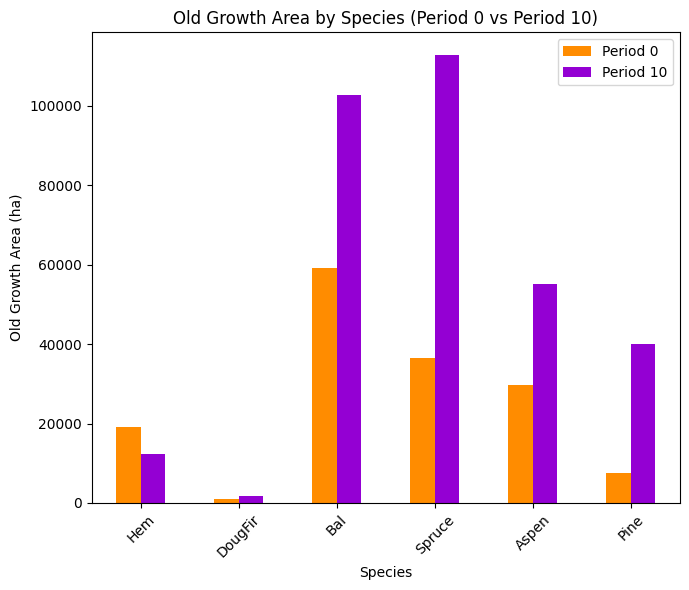

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7401

Diversity has **decreased** by 1.91% from time 0 to time 10.


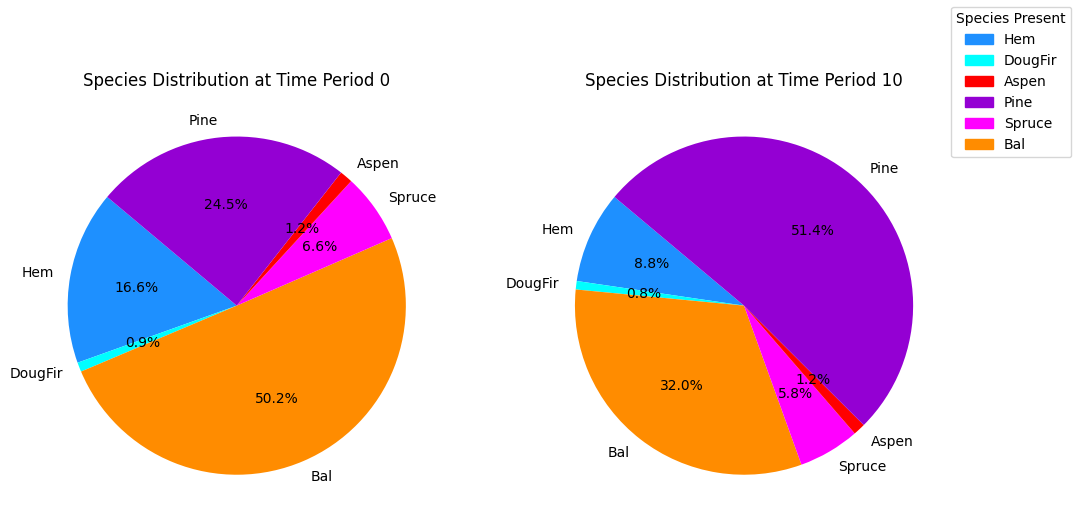

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_60%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.29s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

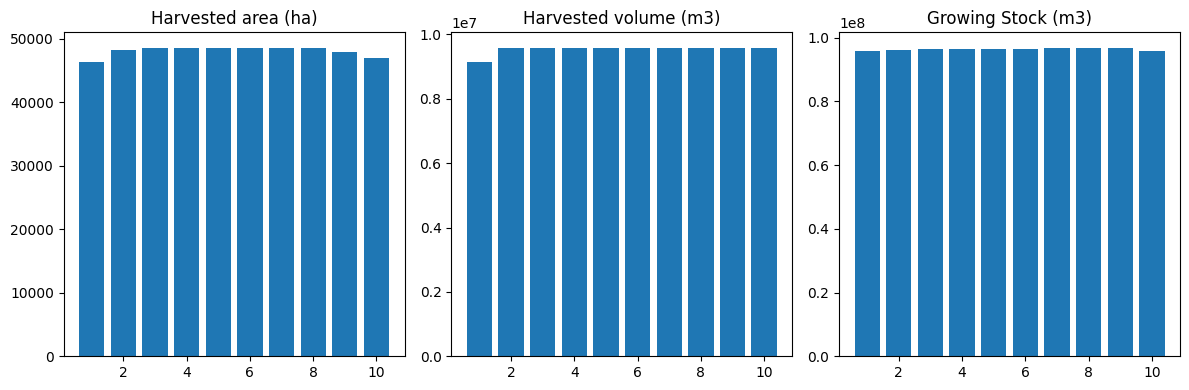

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


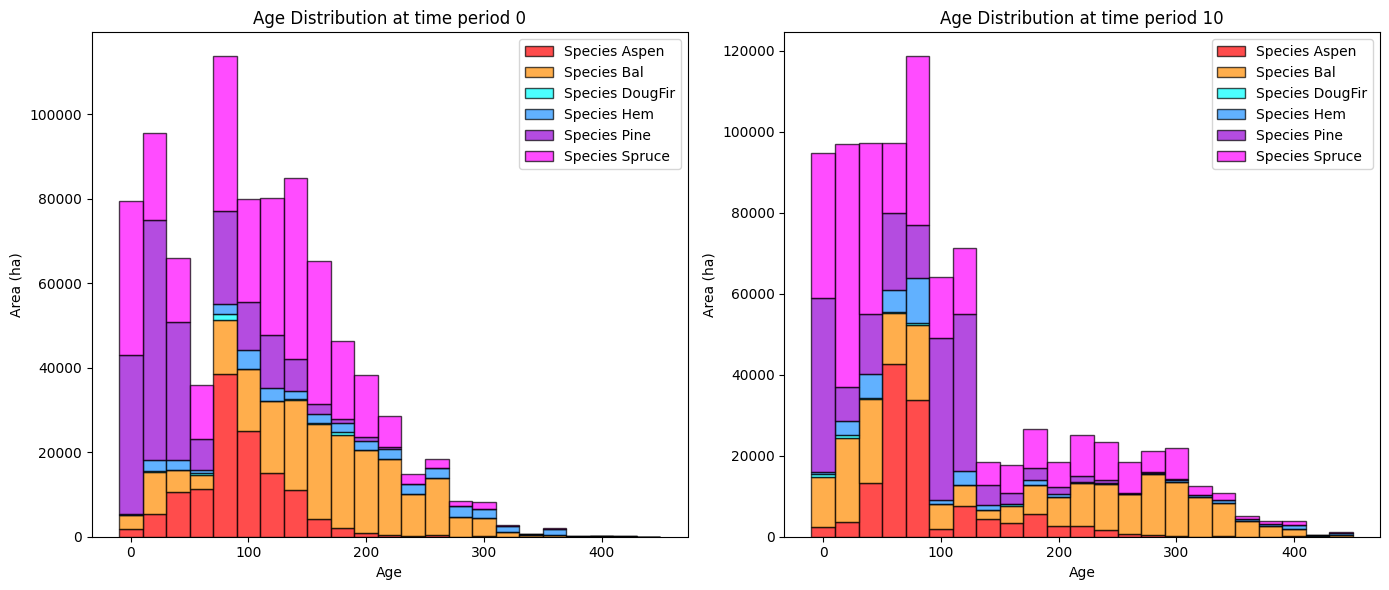

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7867.427610 -11284.699619
DougFir    947.047810    656.427461   -290.620349
Bal      59315.970469  85384.032361  26068.061892
Spruce   36410.744598  58541.140685  22130.396087
Aspen    29632.731169  25732.222254  -3900.508915
Pine      7432.733686  17416.131995   9983.398309

Overall diversity has **increased** by 42706.03 hectares from time period 0 to time period 10.


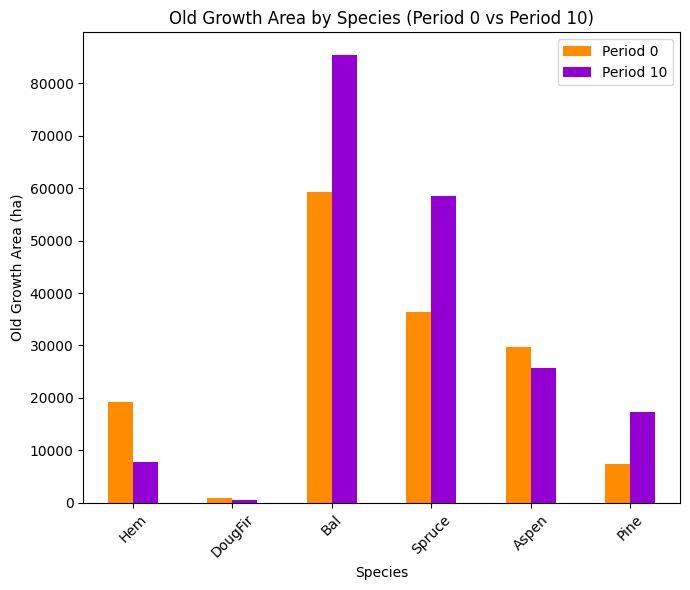

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7582

Diversity has **decreased** by 0.10% from time 0 to time 10.


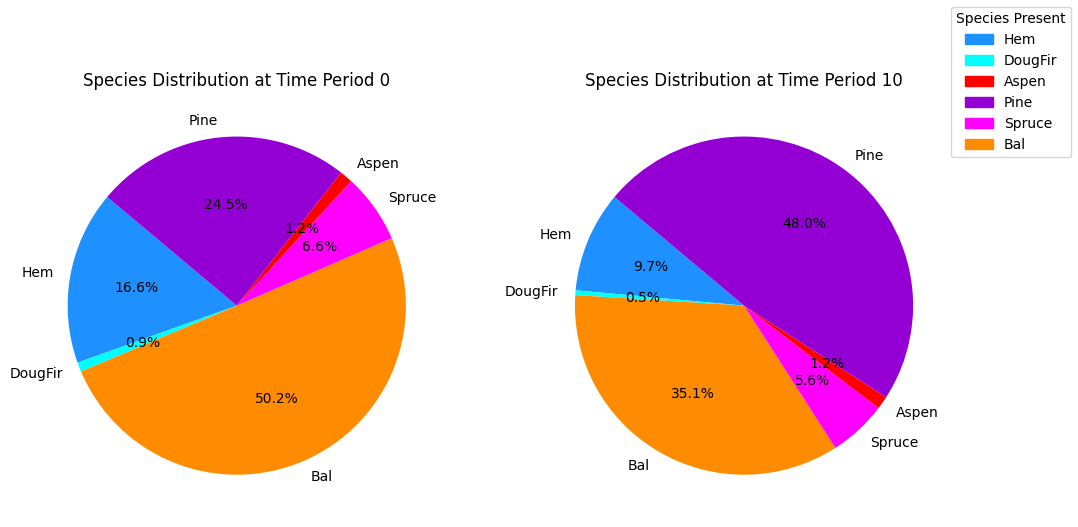

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


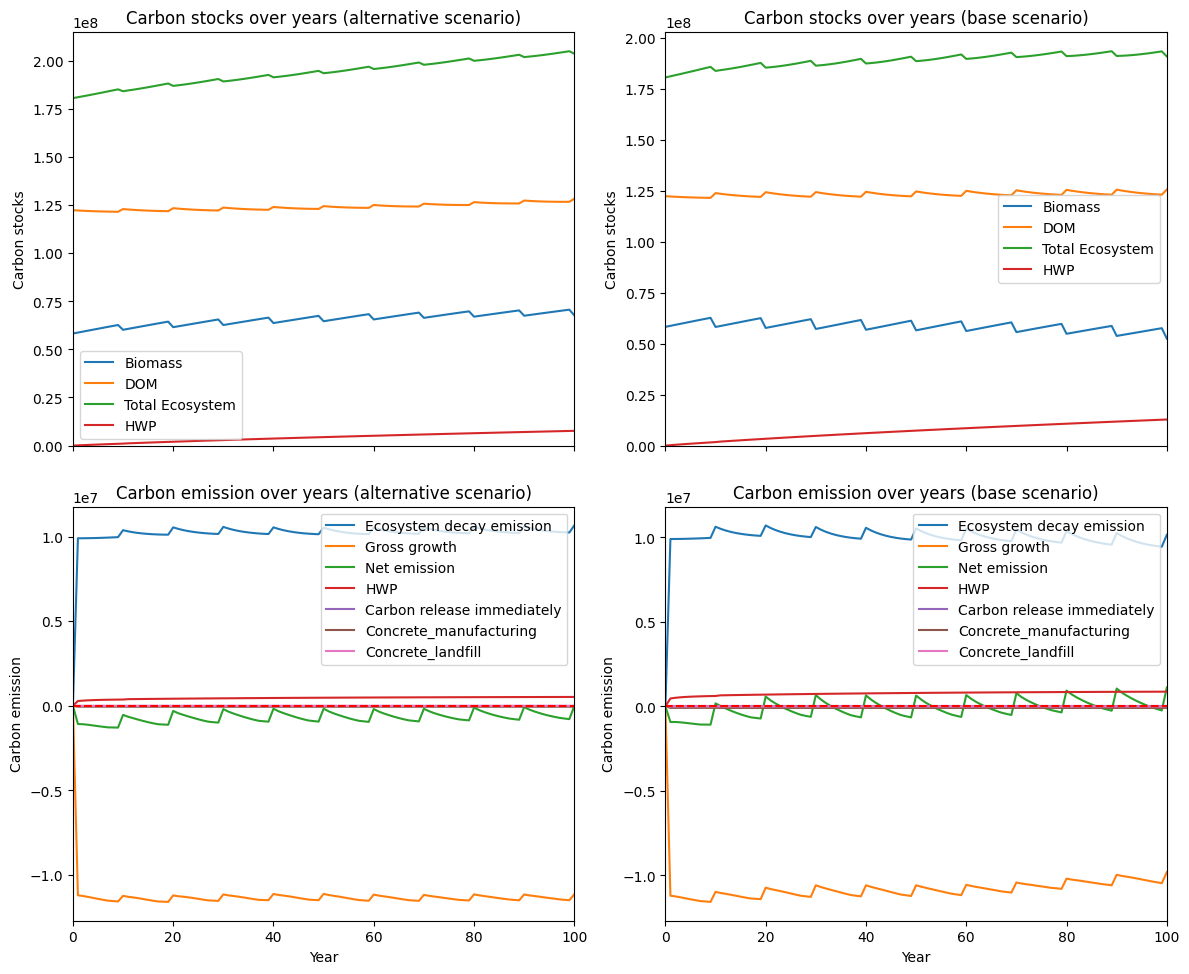

---------------------------------------------------------------------------------------
Net emission difference -10582057.421284733
Net emission base scenario -22305154.106424347
Net emission alternative scenario -11723096.685139613
dollar_per_ton is:  0.9449958171542346
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   4416.504733   4416.504733
DougFir  0.0   1190.148327   1190.148327
Bal      0.0  17286.124838  17286.124838
Spruce   0.0  54369.227779  54369.227779
Aspen    0.0  29477.817718  29477.817718
Pine     0.0  22545.339833  22545.339833

Overall, the old growth area has **increased** by 129285.16 hectares in the alternative scenario compared to the base scenario.


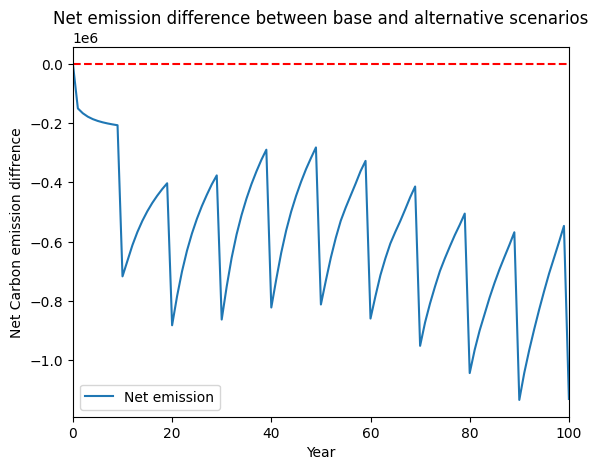

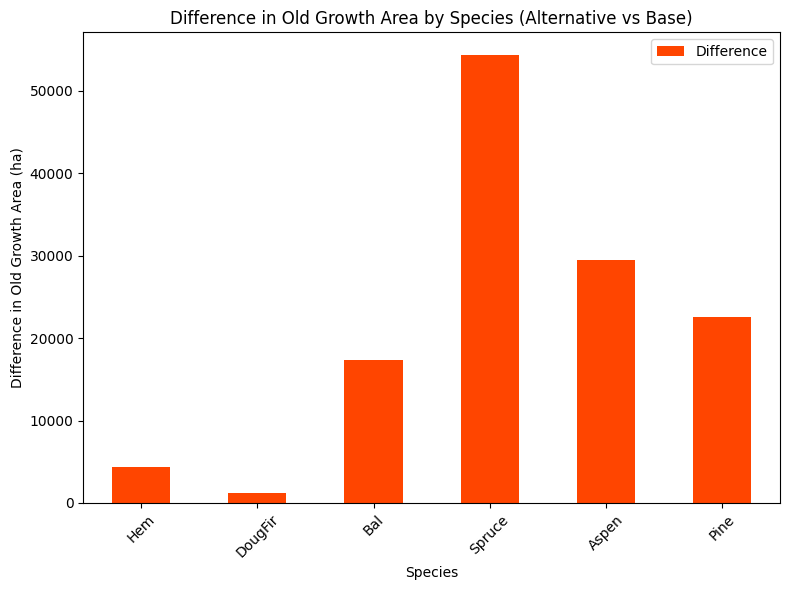

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


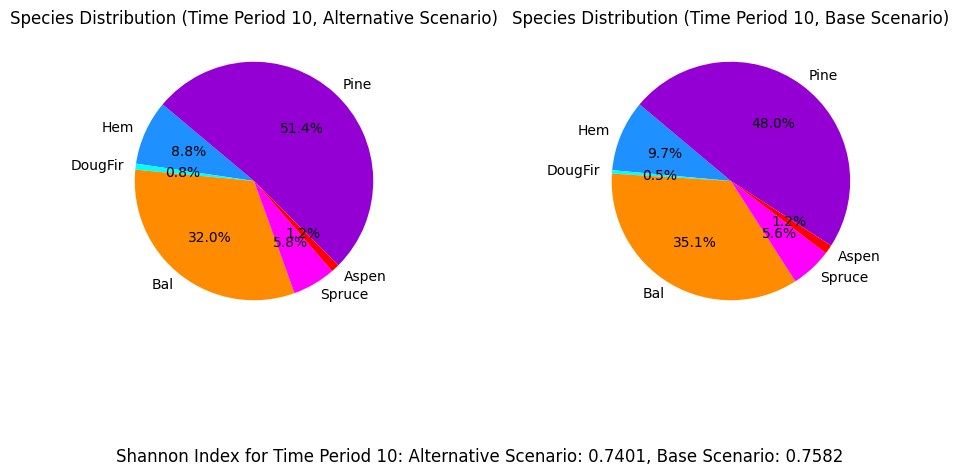

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_50%...
running the scenario for the Equity Silver mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x03a599d1
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8231 rows and 8227 columns
Presolve time: 0.09s

Solved in 0 iter

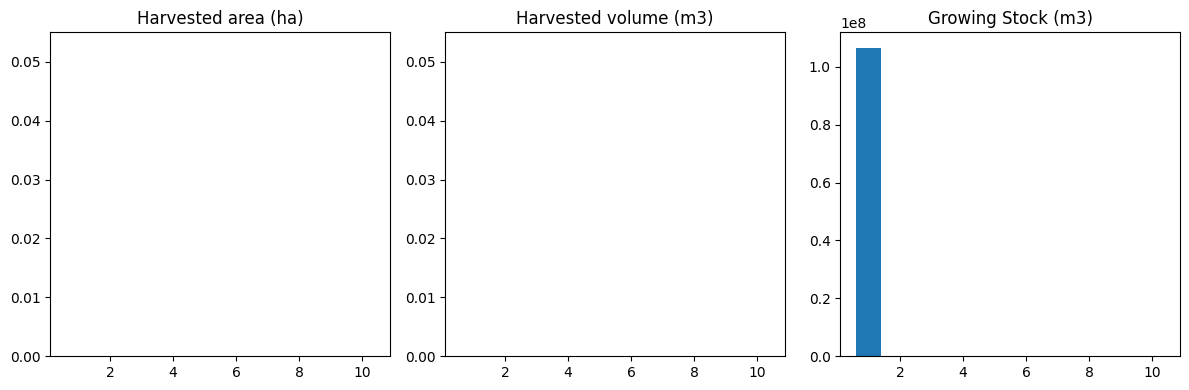

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_50%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------


UnboundLocalError: local variable 'sch' referenced before assignment

In [12]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for equitysilver_max_hv_eqtslvr_AAC_50%...
running the scenario for the Equity Silver mining site (50%_AAC),
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xe37462b6
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.33s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier l

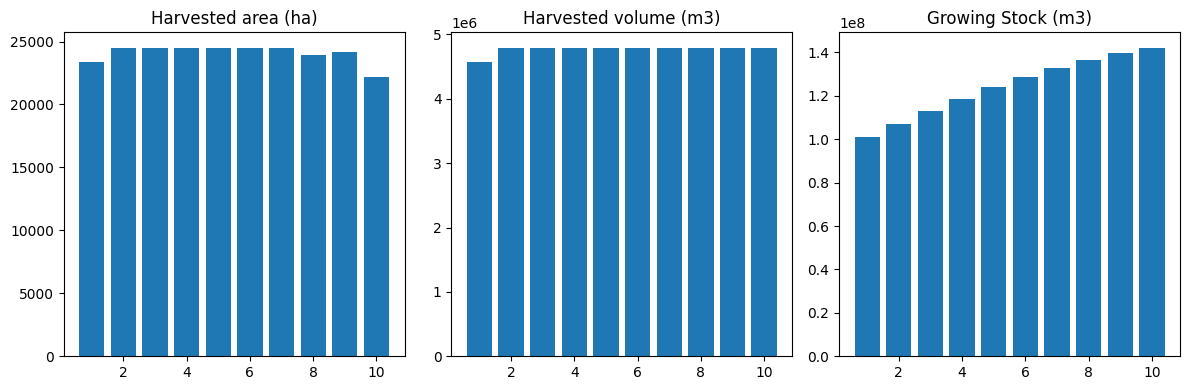

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_50%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  50421
The economic indicator (the provincial government revenues) is:  1719466
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


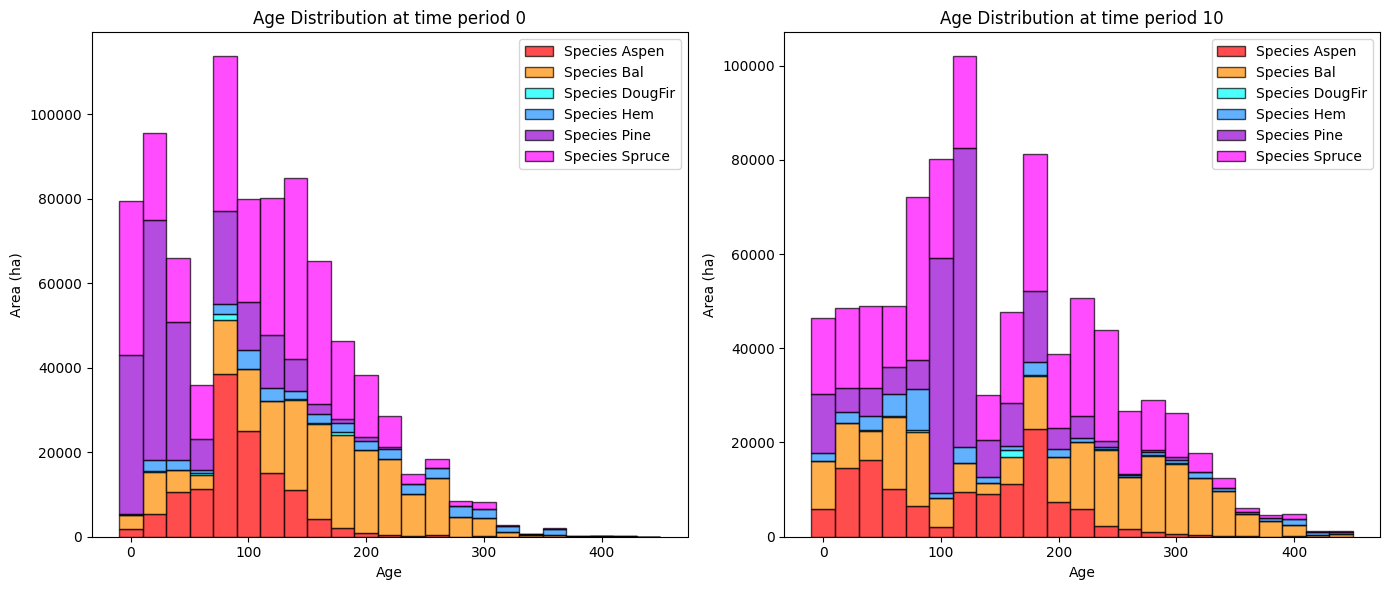

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10    Difference
Hem      19152.127229   13033.672870  -6118.454359
DougFir    947.047810    1931.586851    984.539041
Bal      59315.970469  108251.166011  48935.195542
Spruce   36410.744598  132502.505889  96091.761291
Aspen    29632.731169   66246.428825  36613.697655
Pine      7432.733686   45454.627343  38021.893657

Overall diversity has **increased** by 214528.63 hectares from time period 0 to time period 10.


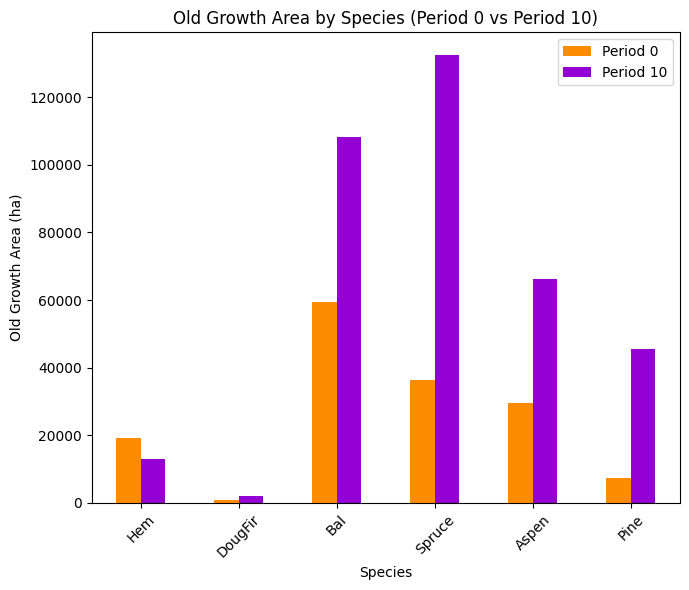

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7375

Diversity has **decreased** by 2.17% from time 0 to time 10.


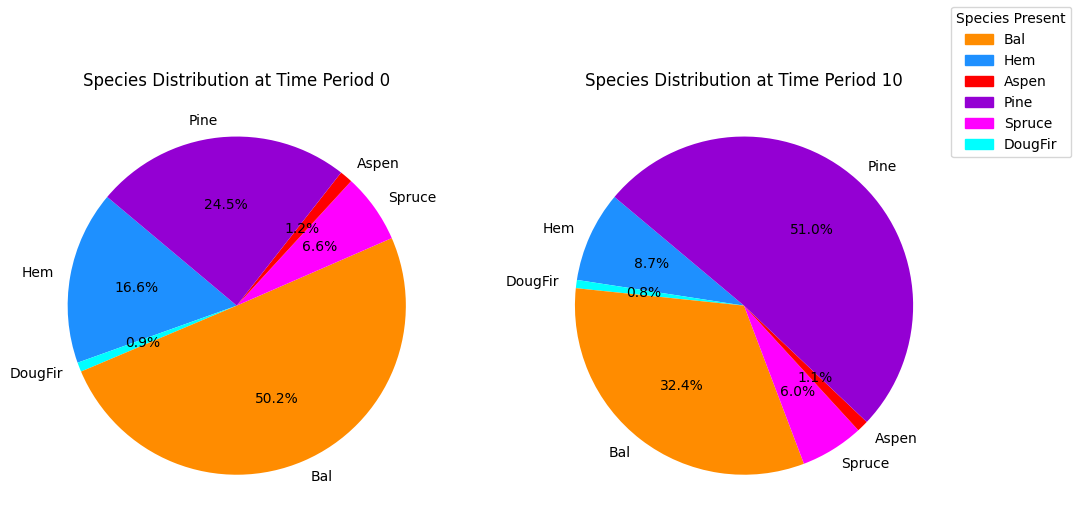

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_50%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.39s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

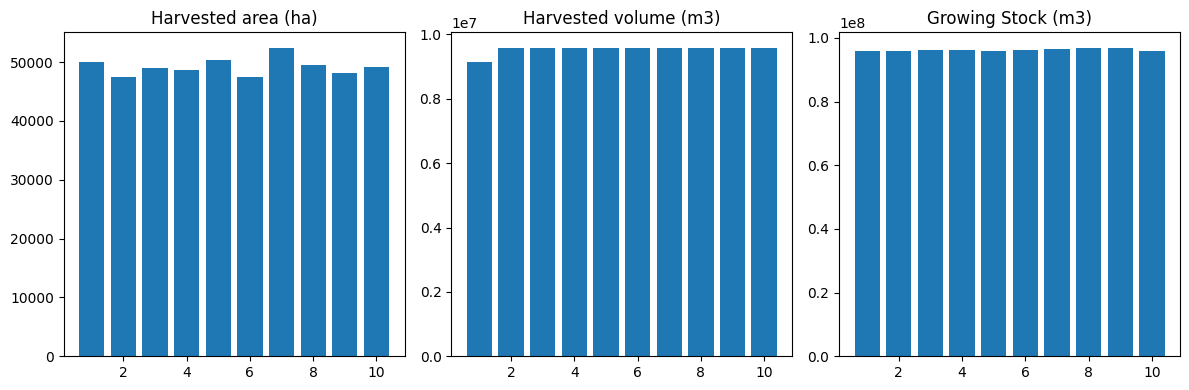

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


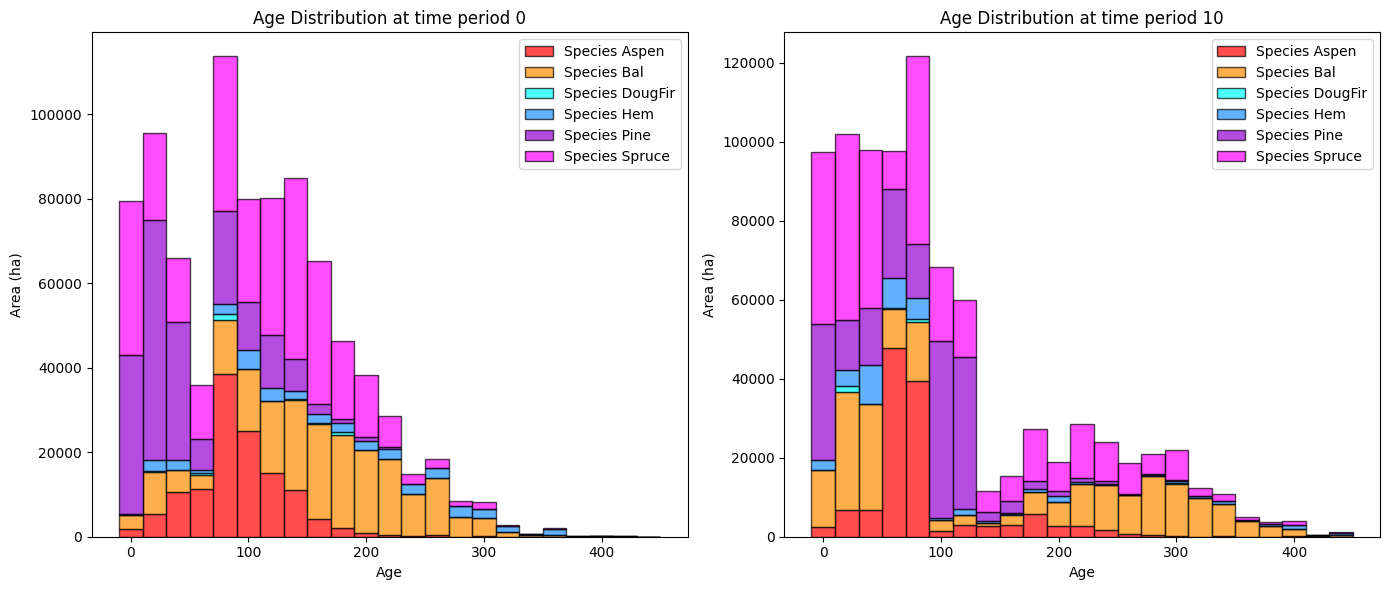

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7420.003864 -11732.123365
DougFir    947.047810    588.823746   -358.224064
Bal      59315.970469  83662.092085  24346.121617
Spruce   36410.744598  67222.186953  30811.442355
Aspen    29632.731169  21366.865973  -8265.865196
Pine      7432.733686  16124.525134   8691.791448

Overall diversity has **increased** by 43493.14 hectares from time period 0 to time period 10.


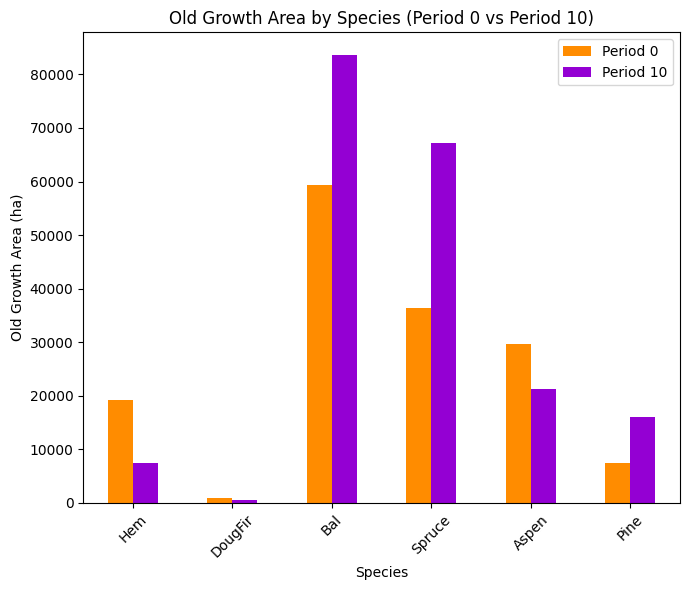

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7329

Diversity has **decreased** by 2.63% from time 0 to time 10.


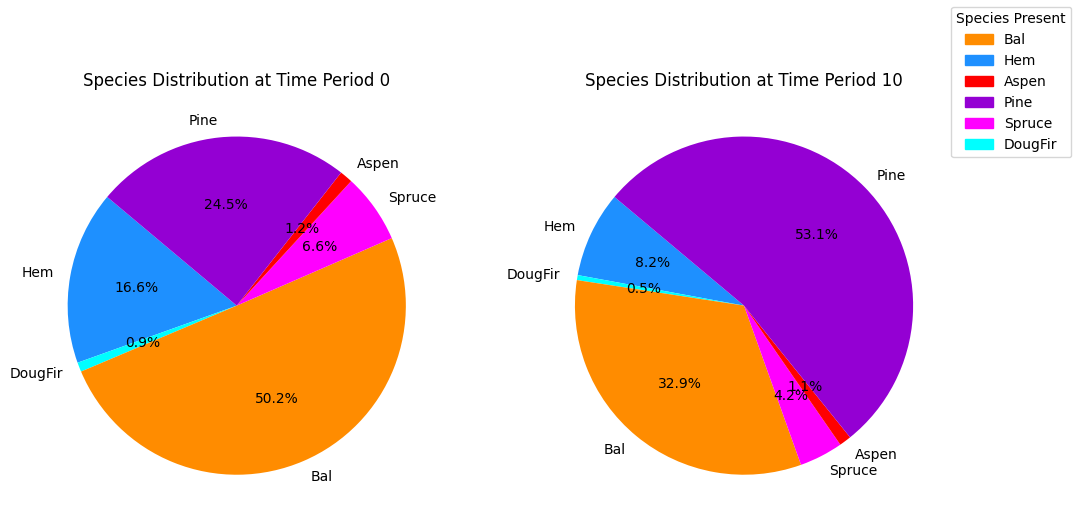

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


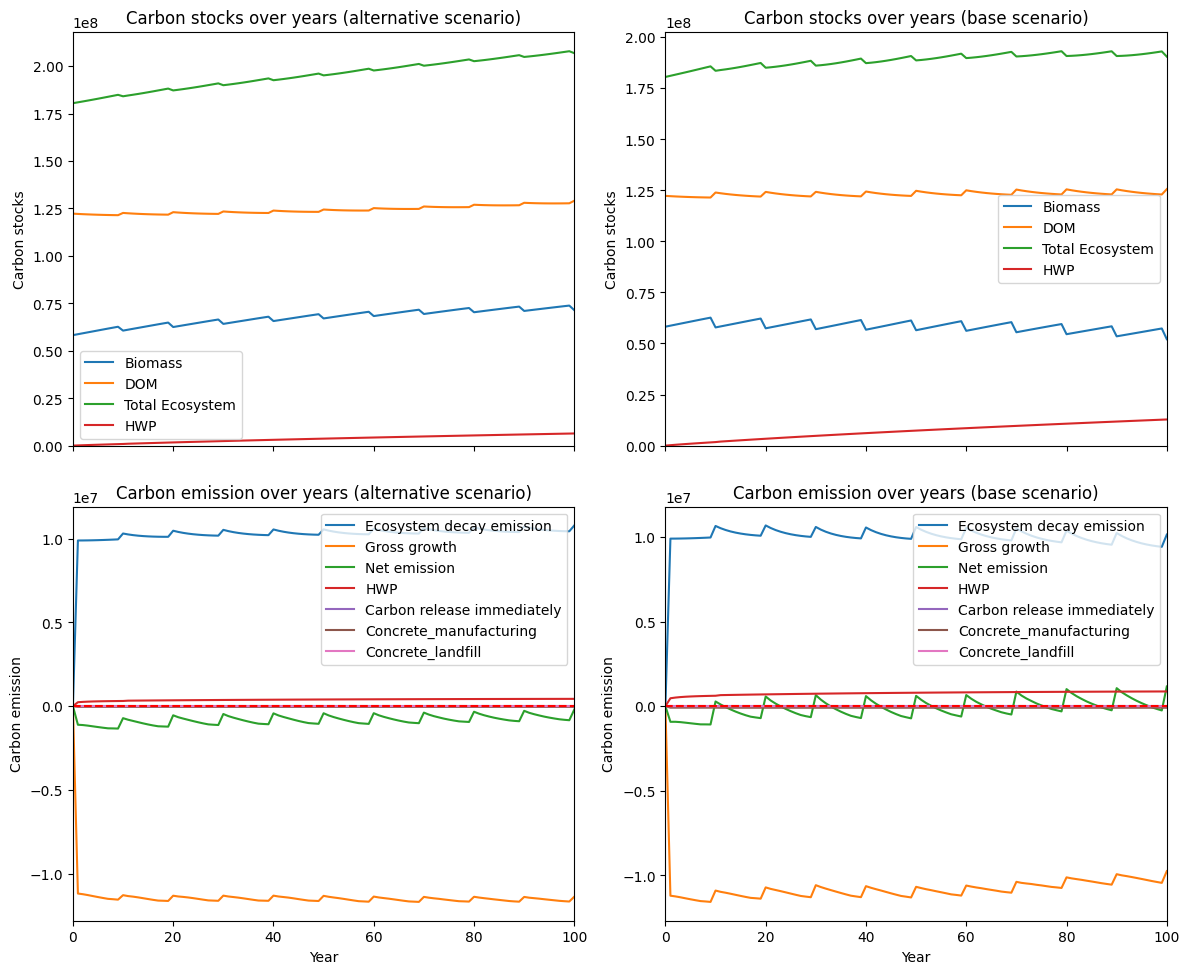

---------------------------------------------------------------------------------------
Net emission difference -13796836.643316137
Net emission base scenario -25123867.111005276
Net emission alternative scenario -11327030.467689143
dollar_per_ton is:  0.7248038270312123
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   5613.669006   5613.669006
DougFir  0.0   1342.763105   1342.763105
Bal      0.0  24589.073926  24589.073926
Spruce   0.0  65280.318936  65280.318936
Aspen    0.0  44879.562852  44879.562852
Pine     0.0  29330.102209  29330.102209

Overall, the old growth area has **increased** by 171035.49 hectares in the alternative scenario compared to the base scenario.


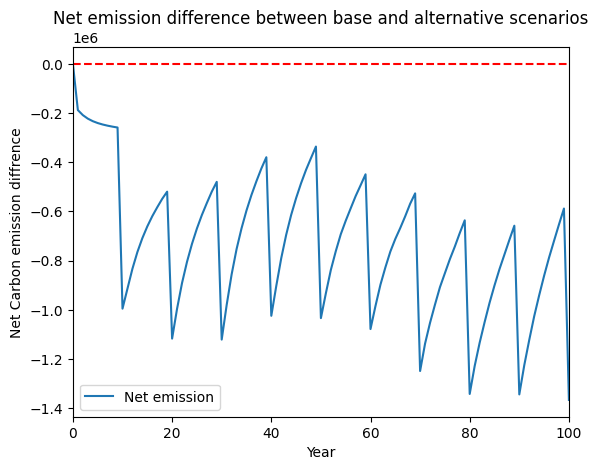

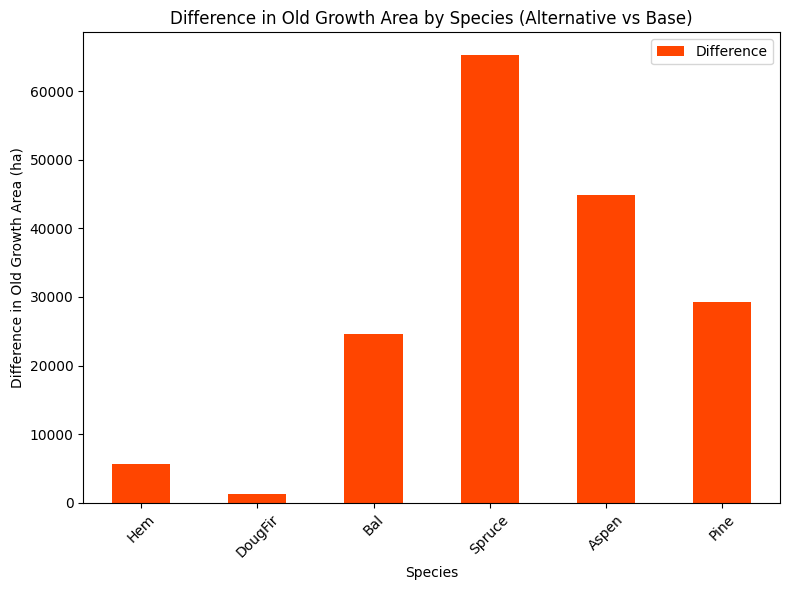

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


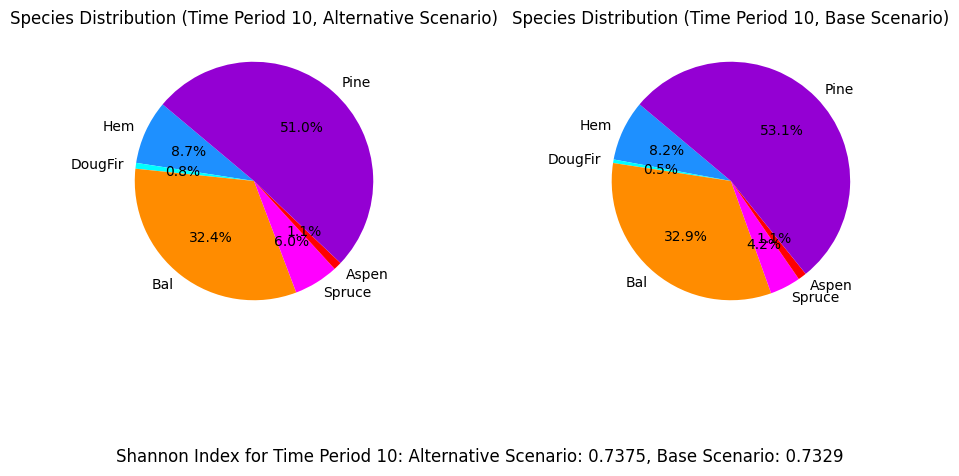

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_40%...
running the scenario for the Equity Silver mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x814cc1bc
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.36s
Presolved: 8375 r

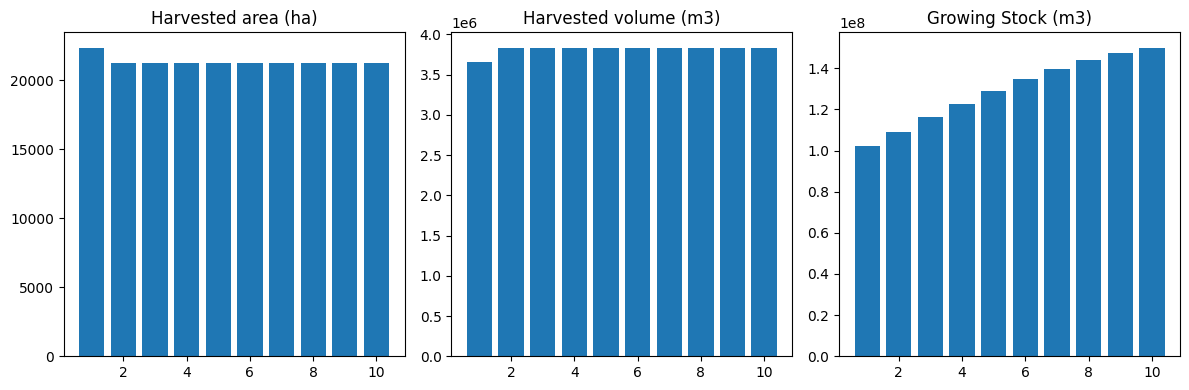

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_40%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  40336
The economic indicator (the provincial government revenues) is:  1375573
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


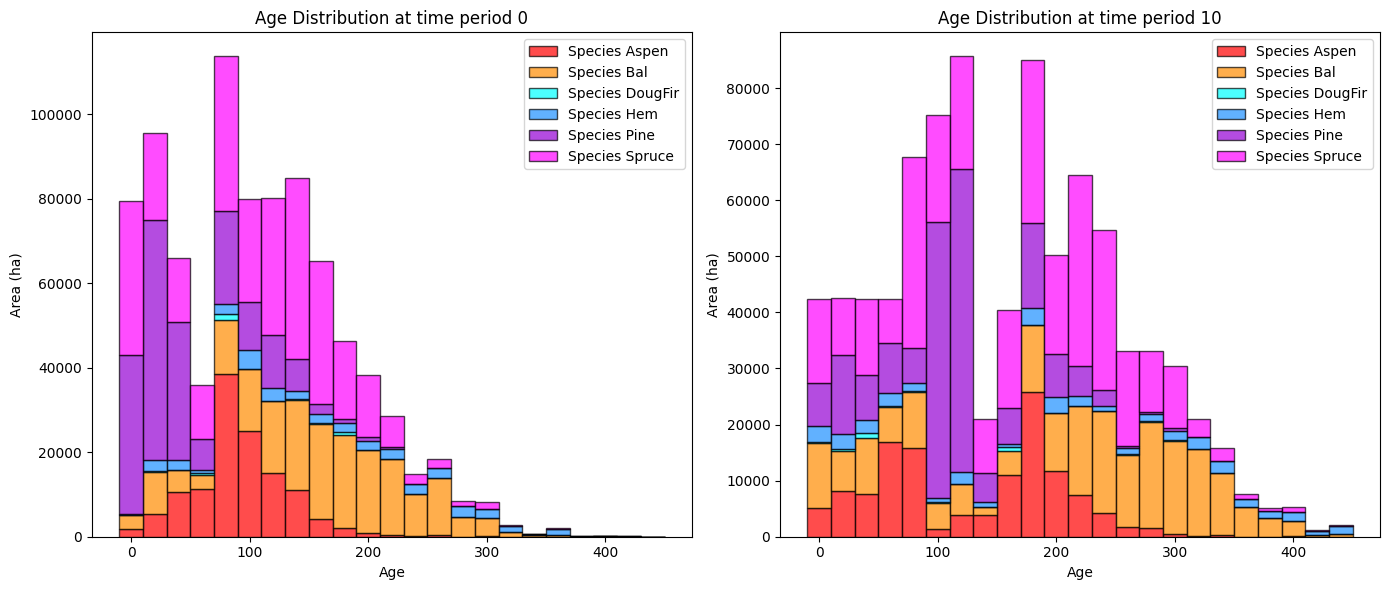

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   23668.194173    4516.066944
DougFir    947.047810    1050.524378     103.476568
Bal      59315.970469  124597.626771   65281.656302
Spruce   36410.744598  153084.354107  116673.609509
Aspen    29632.731169   70287.002747   40654.271578
Pine      7432.733686   47533.640057   40100.906371

Overall diversity has **increased** by 267329.99 hectares from time period 0 to time period 10.


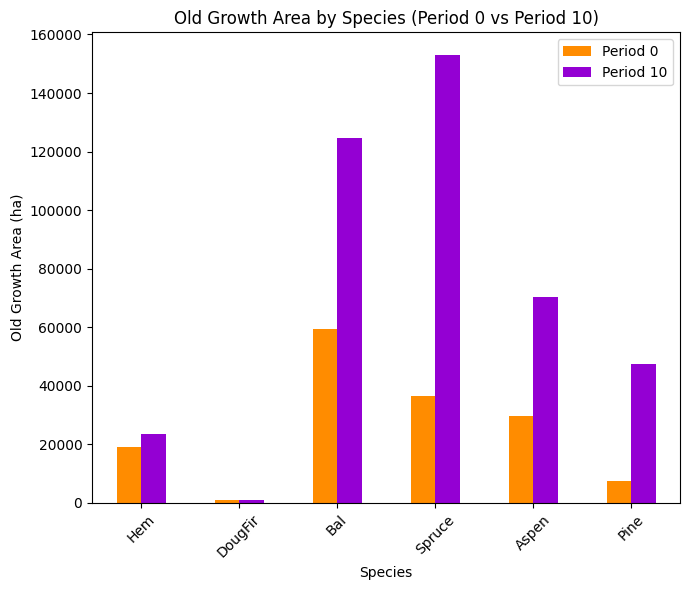

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7275

Diversity has **decreased** by 3.17% from time 0 to time 10.


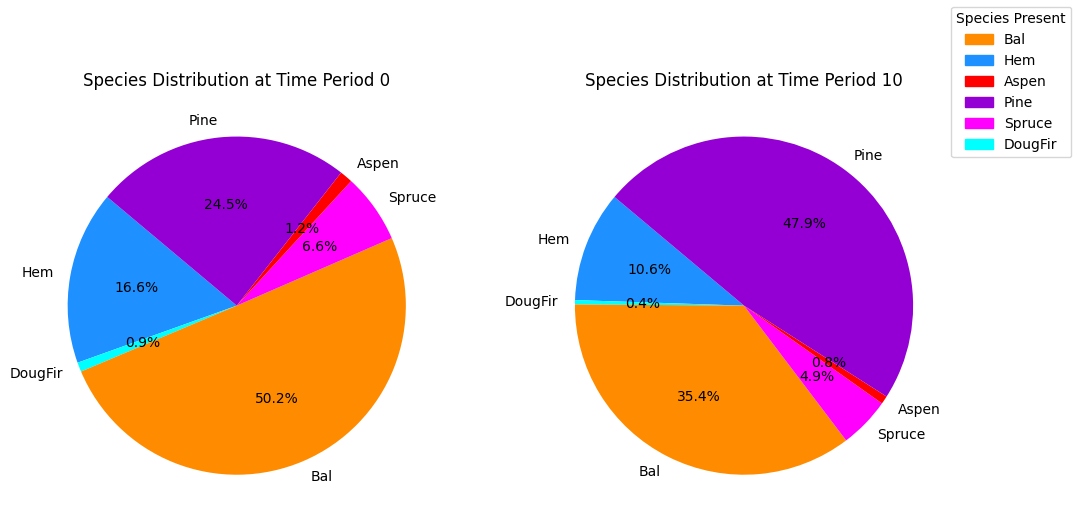

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_40%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.31s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

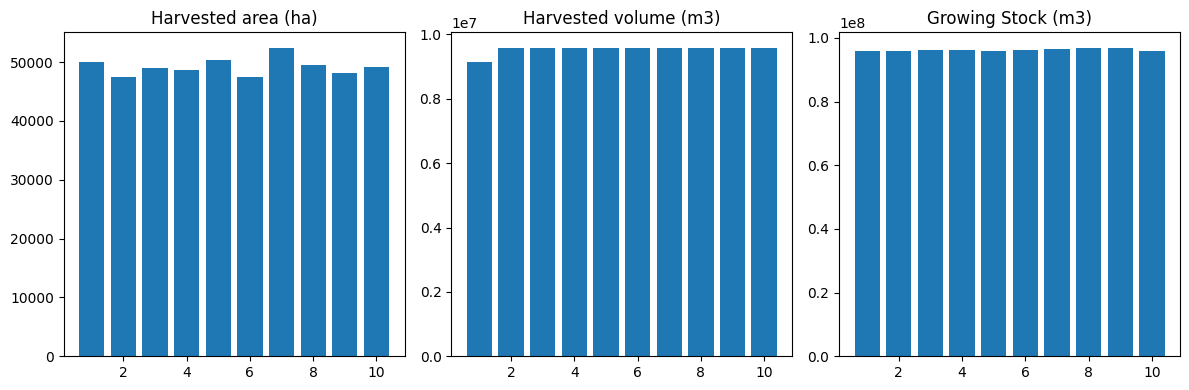

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


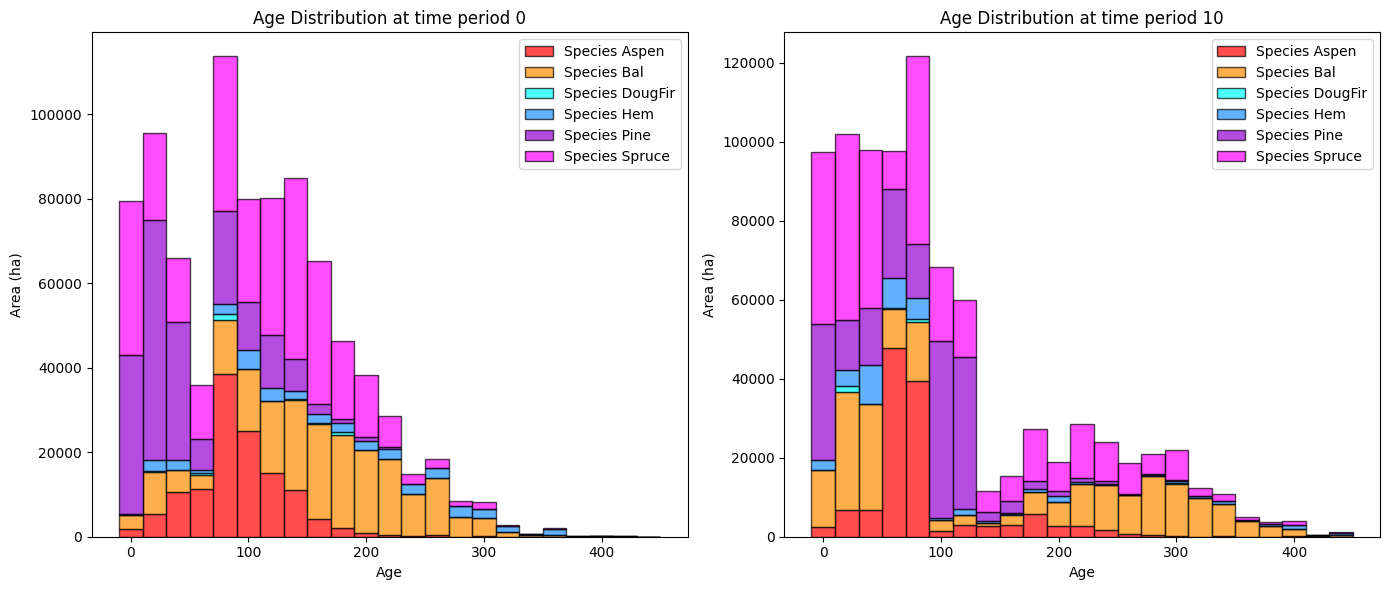

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7420.003864 -11732.123365
DougFir    947.047810    588.823746   -358.224064
Bal      59315.970469  83662.092085  24346.121617
Spruce   36410.744598  67222.186953  30811.442355
Aspen    29632.731169  21366.865973  -8265.865196
Pine      7432.733686  16124.525134   8691.791448

Overall diversity has **increased** by 43493.14 hectares from time period 0 to time period 10.


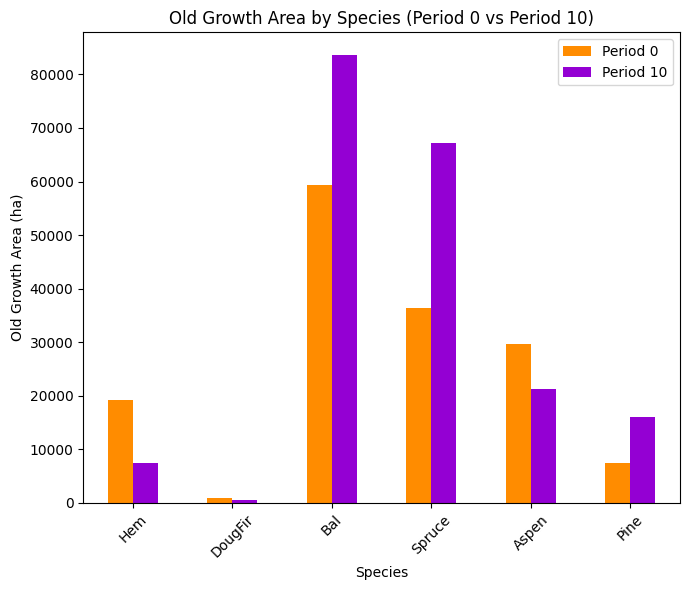

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7329

Diversity has **decreased** by 2.63% from time 0 to time 10.


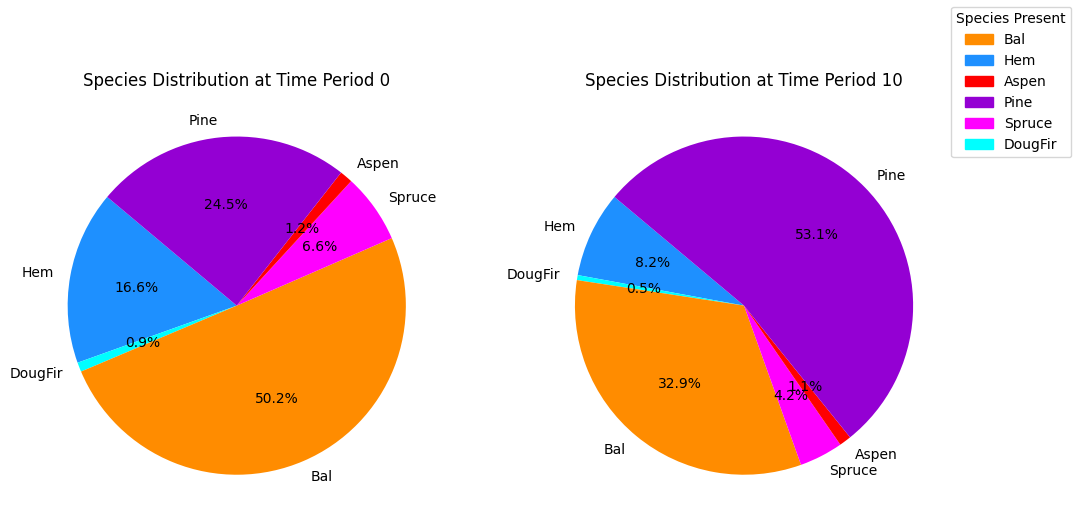

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


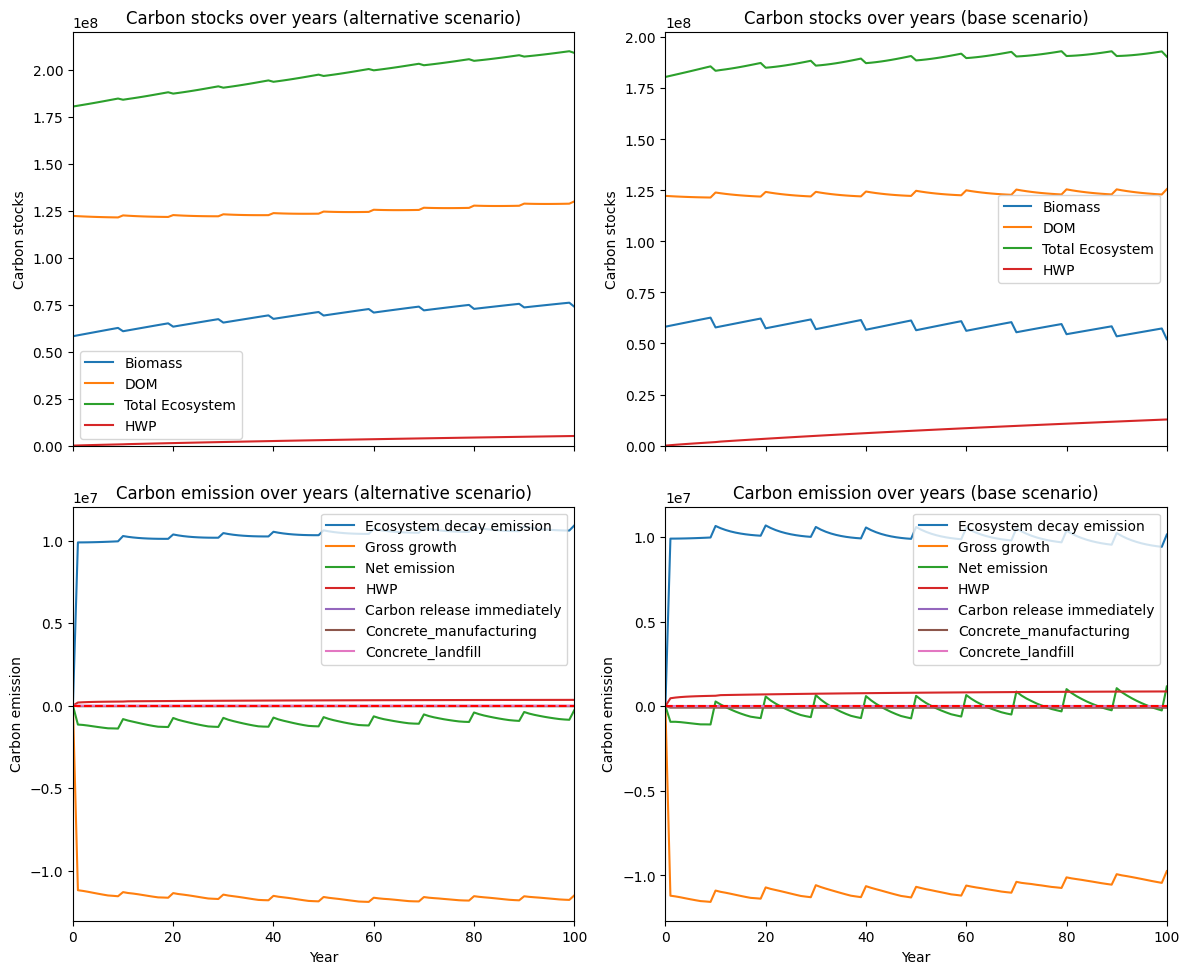

---------------------------------------------------------------------------------------
Net emission difference -16041434.373017928
Net emission base scenario -27368464.840707075
Net emission alternative scenario -11327030.467689143
dollar_per_ton is:  0.623385650401702
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  16248.190310  16248.190310
DougFir  0.0    461.700632    461.700632
Bal      0.0  40935.534686  40935.534686
Spruce   0.0  85862.167153  85862.167153
Aspen    0.0  48920.136774  48920.136774
Pine     0.0  31409.114923  31409.114923

Overall, the old growth area has **increased** by 223836.84 hectares in the alternative scenario compared to the base scenario.


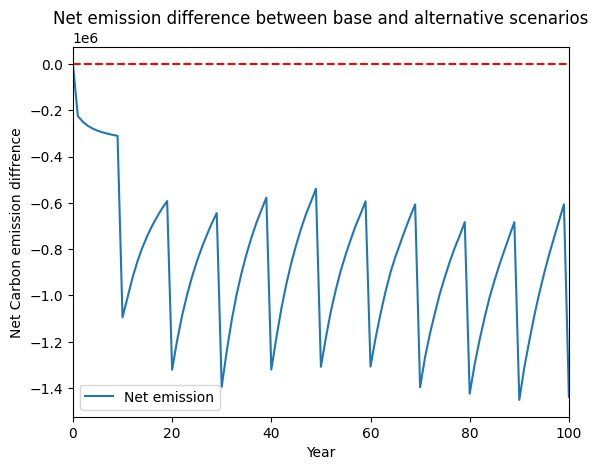

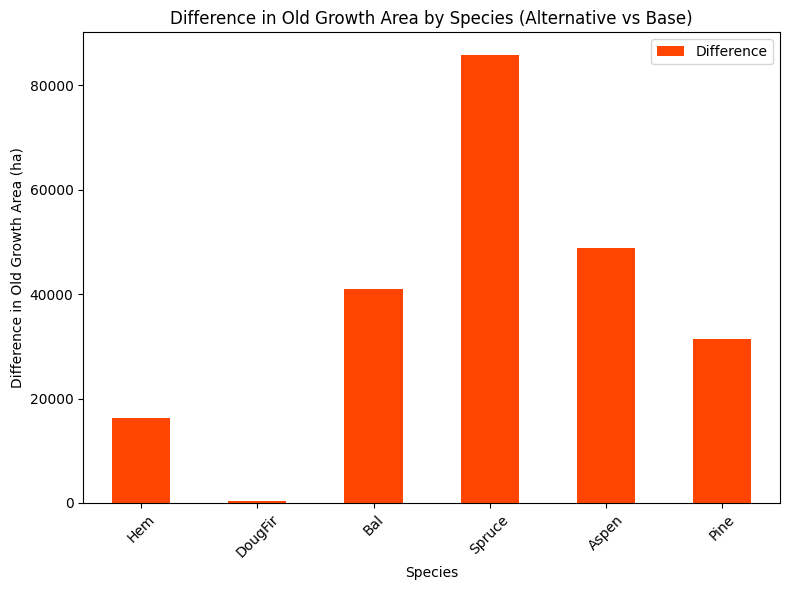

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


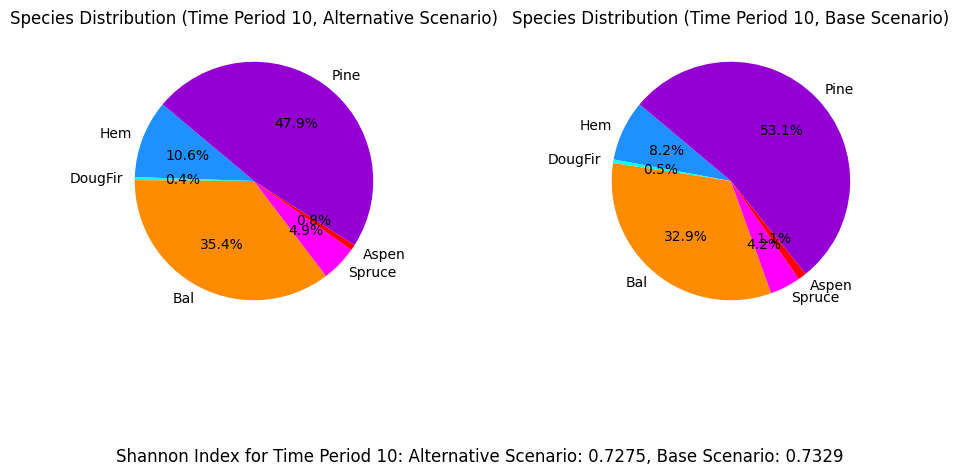

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_30%...
running the scenario for the Equity Silver mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xaad88cc4
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.38s
Presolved: 8375 r

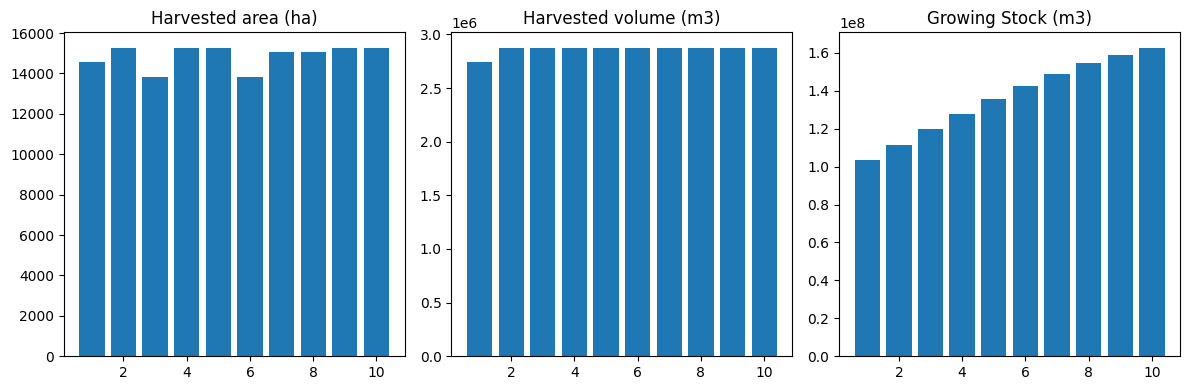

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_30%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  30252
The economic indicator (the provincial government revenues) is:  1031680
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


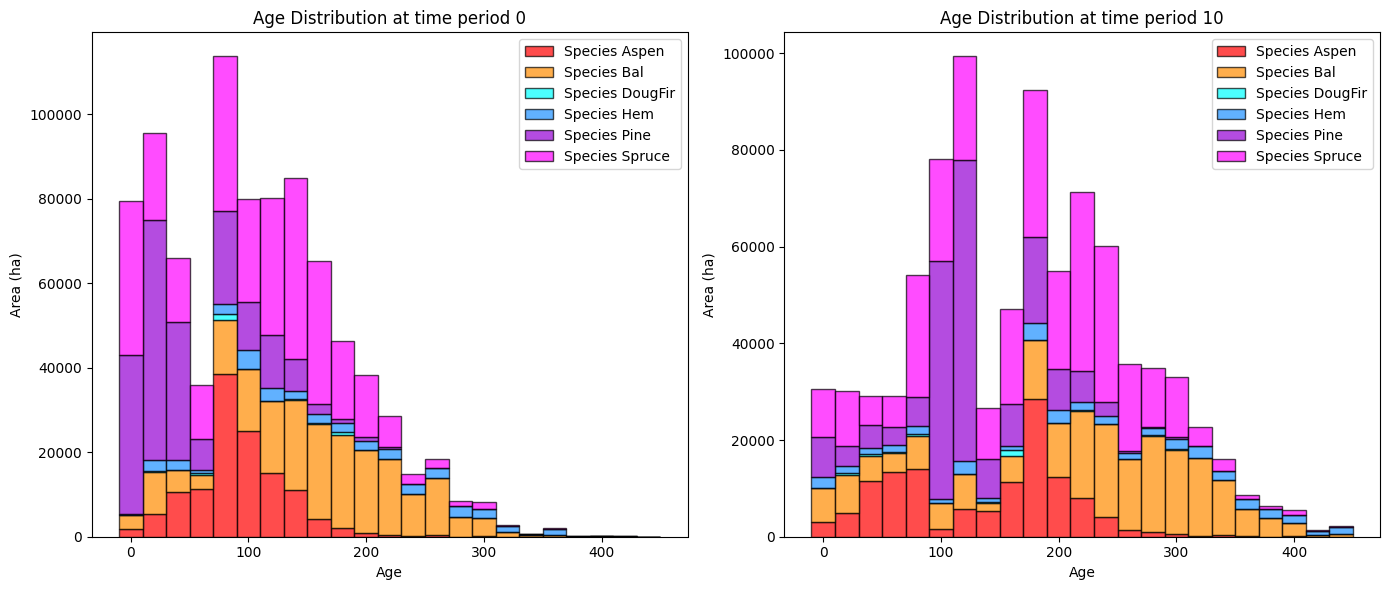

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   26300.600864    7148.473635
DougFir    947.047810    1449.078481     502.030671
Bal      59315.970469  134792.148136   75476.177667
Spruce   36410.744598  168920.047832  132509.303234
Aspen    29632.731169   75731.027758   46098.296588
Pine      7432.733686   55561.821005   48129.087319

Overall diversity has **increased** by 309863.37 hectares from time period 0 to time period 10.


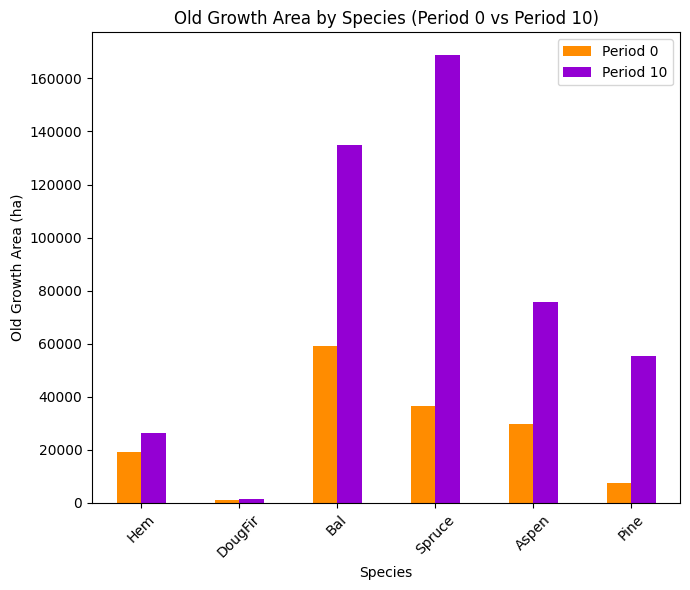

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7328

Diversity has **decreased** by 2.64% from time 0 to time 10.


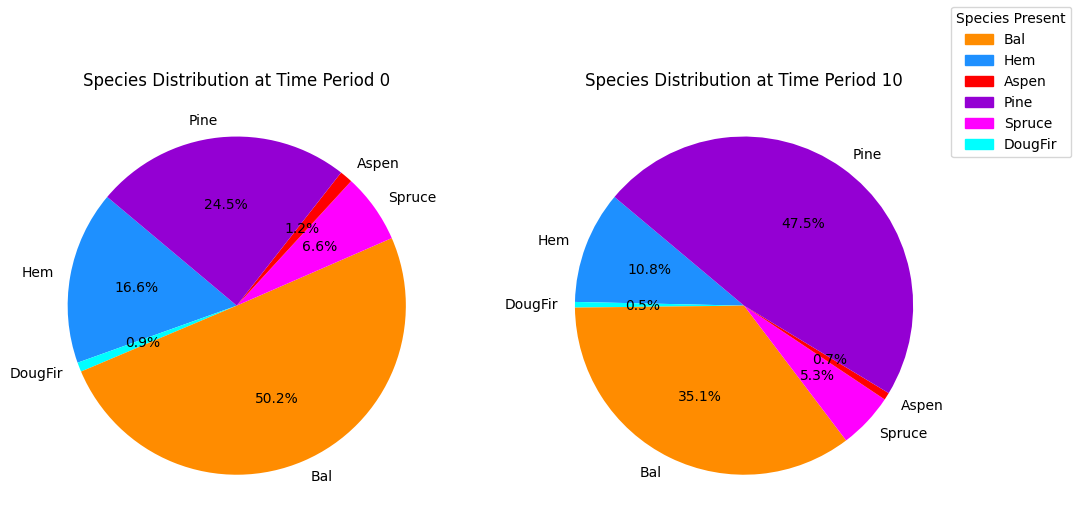

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_30%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.34s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

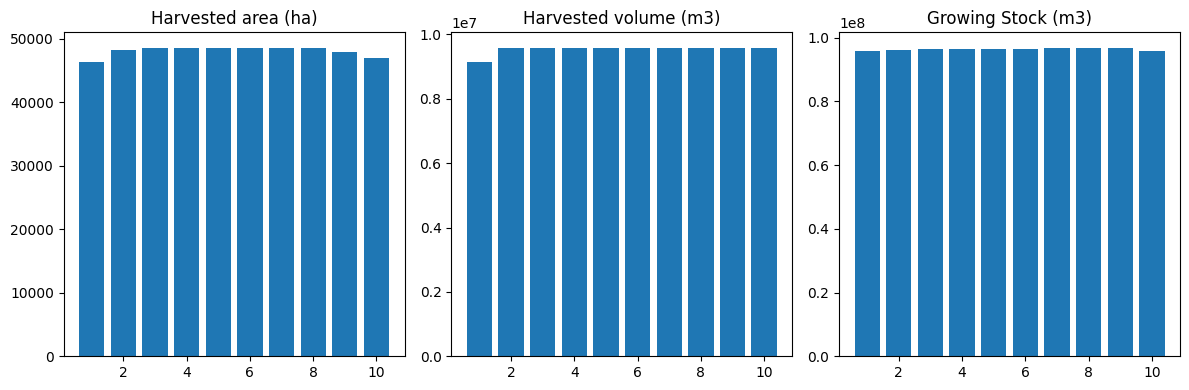

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


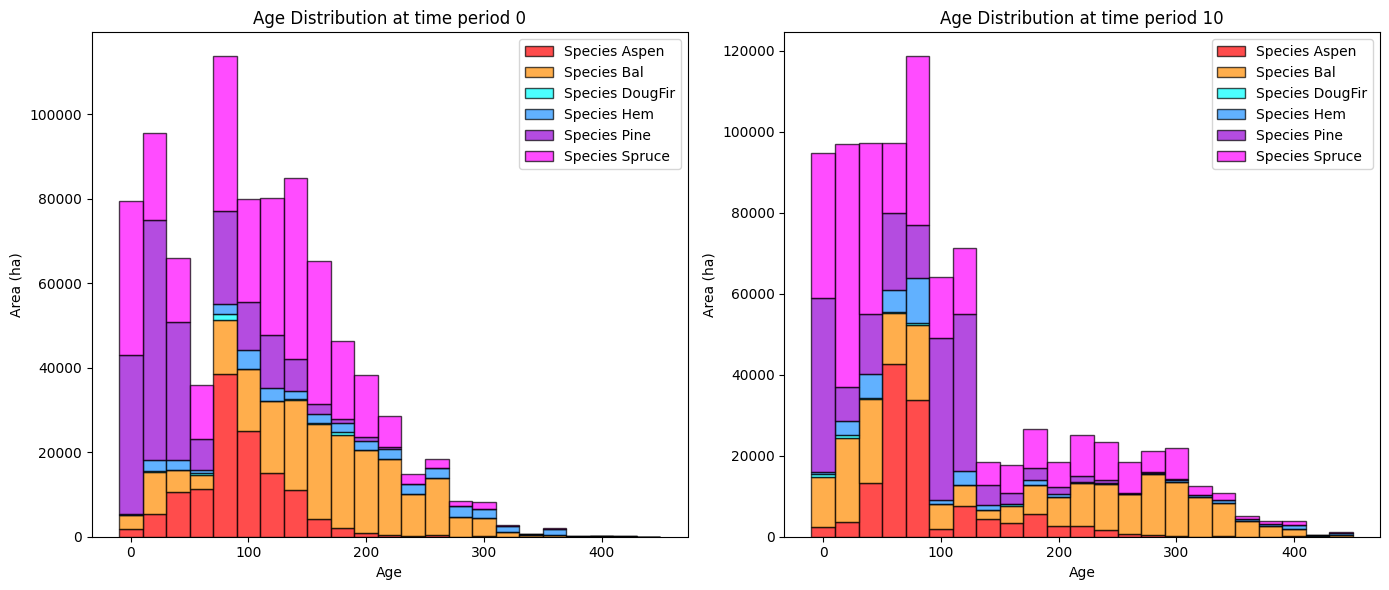

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7867.427610 -11284.699619
DougFir    947.047810    656.427461   -290.620349
Bal      59315.970469  85384.032361  26068.061892
Spruce   36410.744598  58541.140685  22130.396087
Aspen    29632.731169  25732.222254  -3900.508915
Pine      7432.733686  17416.131995   9983.398309

Overall diversity has **increased** by 42706.03 hectares from time period 0 to time period 10.


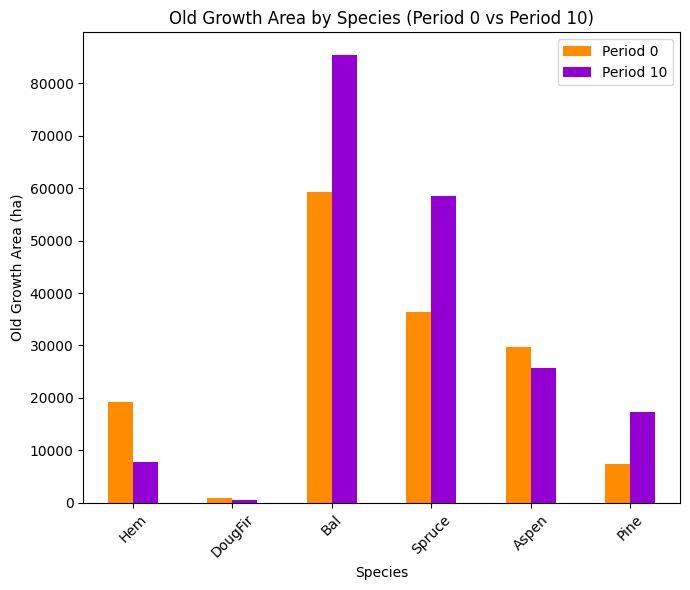

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7582

Diversity has **decreased** by 0.10% from time 0 to time 10.


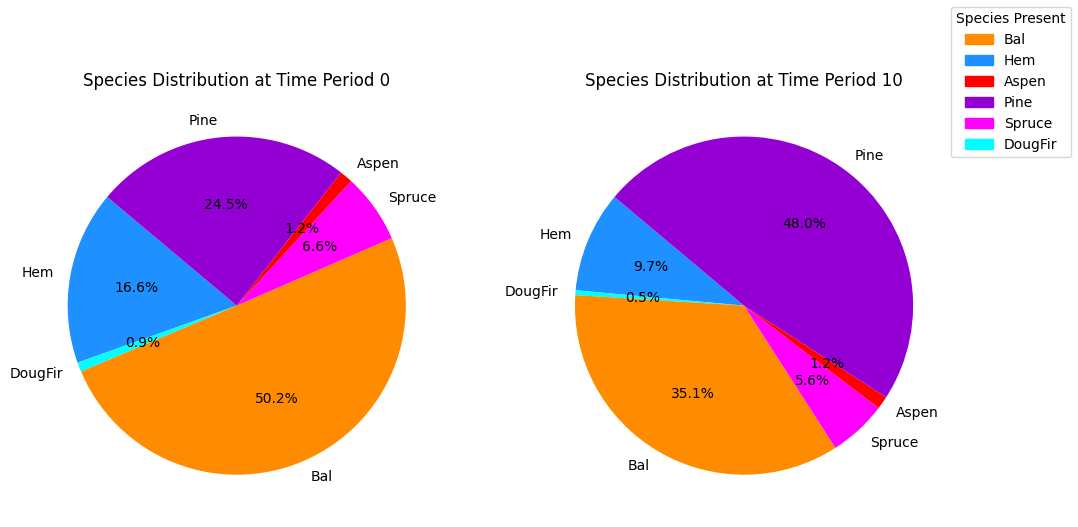

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


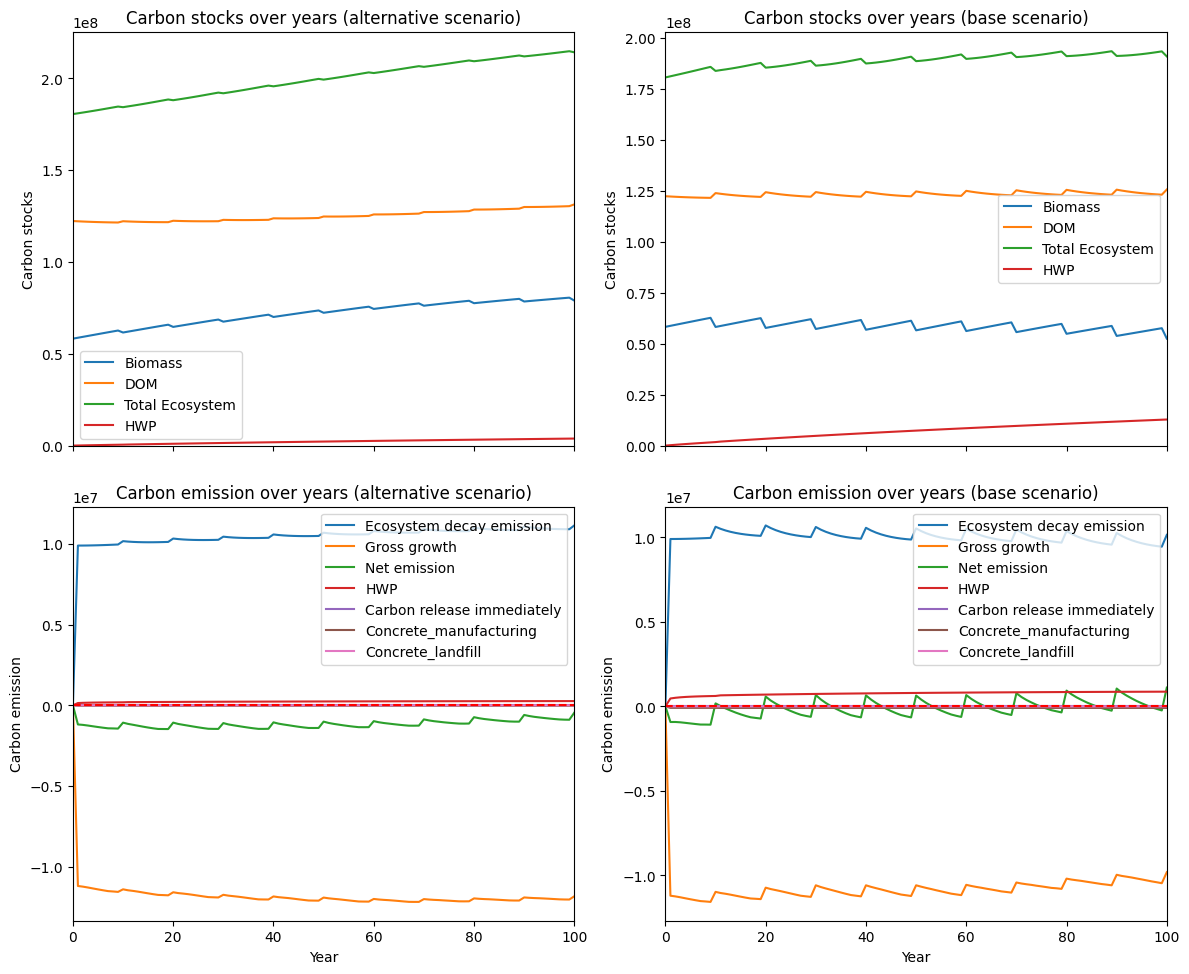

---------------------------------------------------------------------------------------
Net emission difference -19533702.109490752
Net emission base scenario -31256798.79463036
Net emission alternative scenario -11723096.685139613
dollar_per_ton is:  0.5119357274902511
Comparison of Old Growth Areas (Alternative - Base)
           0             10     Difference
Hem      0.0   18433.173254   18433.173254
DougFir  0.0     792.651020     792.651020
Bal      0.0   49408.115775   49408.115775
Spruce   0.0  110378.907147  110378.907147
Aspen    0.0   49998.805504   49998.805504
Pine     0.0   38145.689010   38145.689010

Overall, the old growth area has **increased** by 267157.34 hectares in the alternative scenario compared to the base scenario.


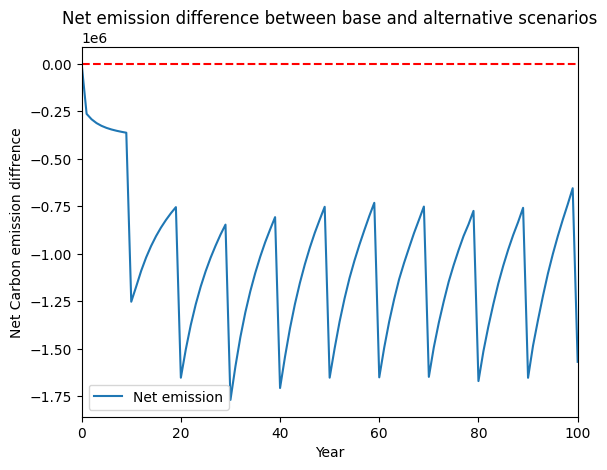

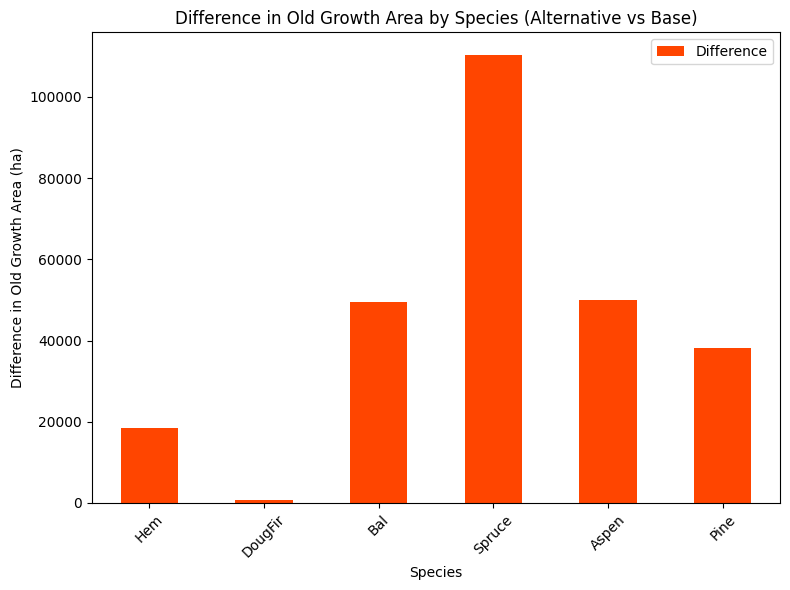

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


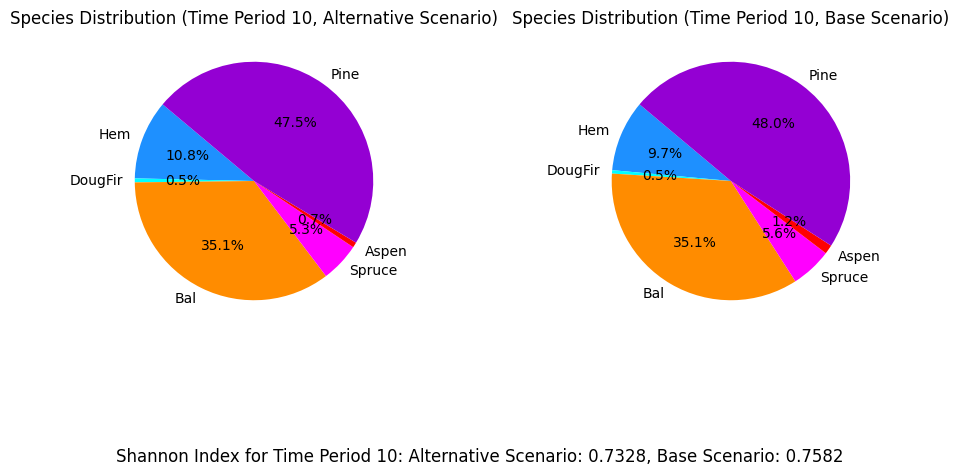

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_20%...
running the scenario for the Equity Silver mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xc00e0a85
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.31s
Presolved: 8375 r

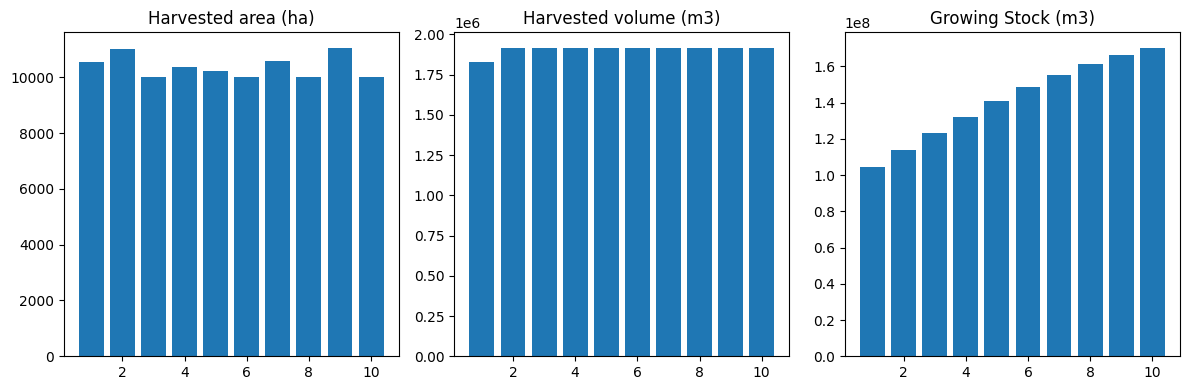

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_20%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  20168
The economic indicator (the provincial government revenues) is:  687786
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


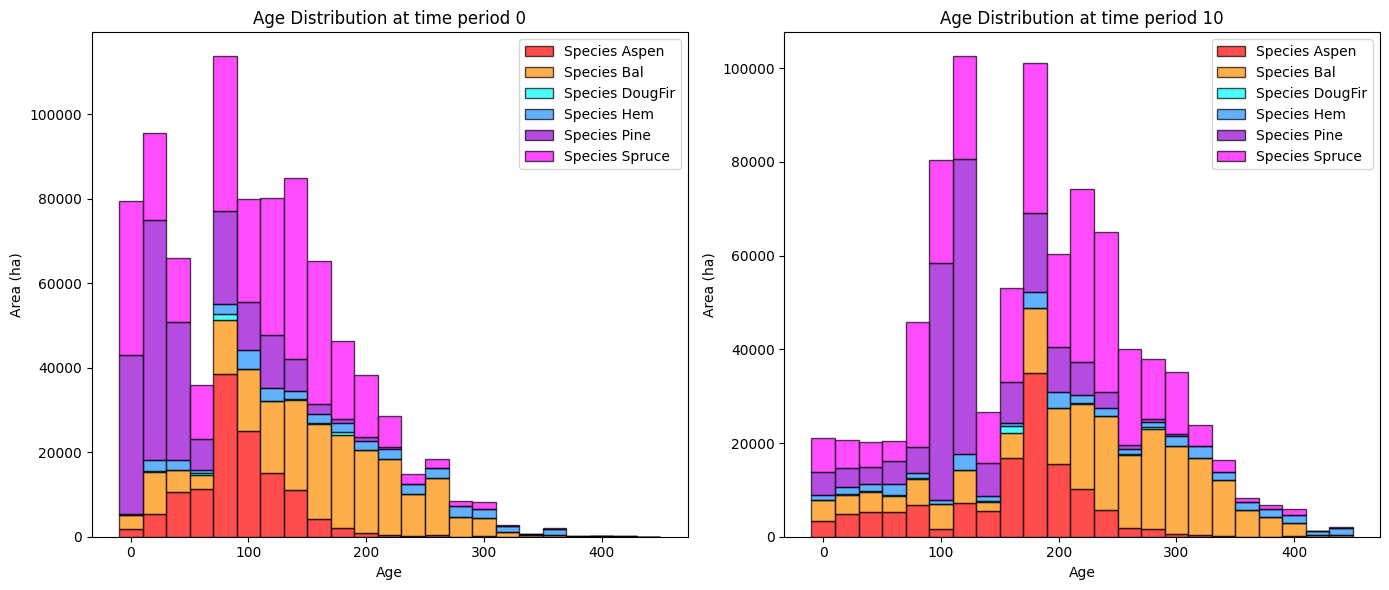

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   26264.307683    7112.180454
DougFir    947.047810    2089.366844    1142.319034
Bal      59315.970469  142468.238338   83152.267869
Spruce   36410.744598  176714.851676  140304.107078
Aspen    29632.731169   96500.182127   66867.450958
Pine      7432.733686   58606.075306   51173.341620

Overall diversity has **increased** by 349751.67 hectares from time period 0 to time period 10.


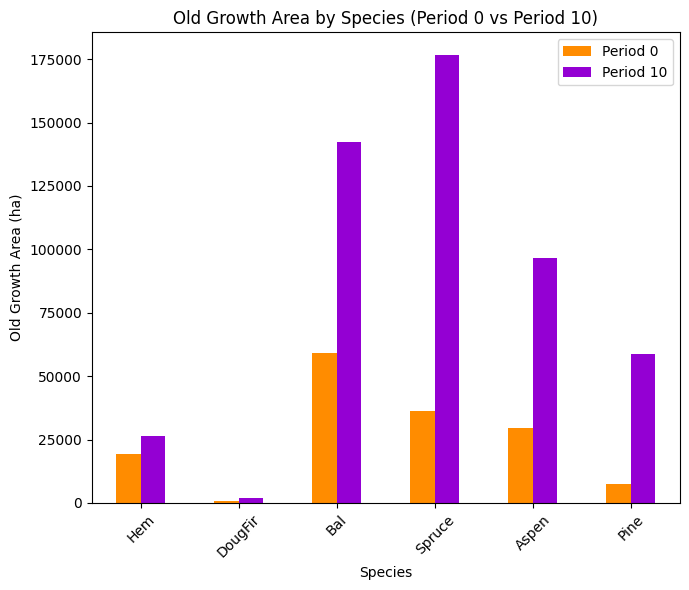

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_20%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7365

Diversity has **decreased** by 2.27% from time 0 to time 10.


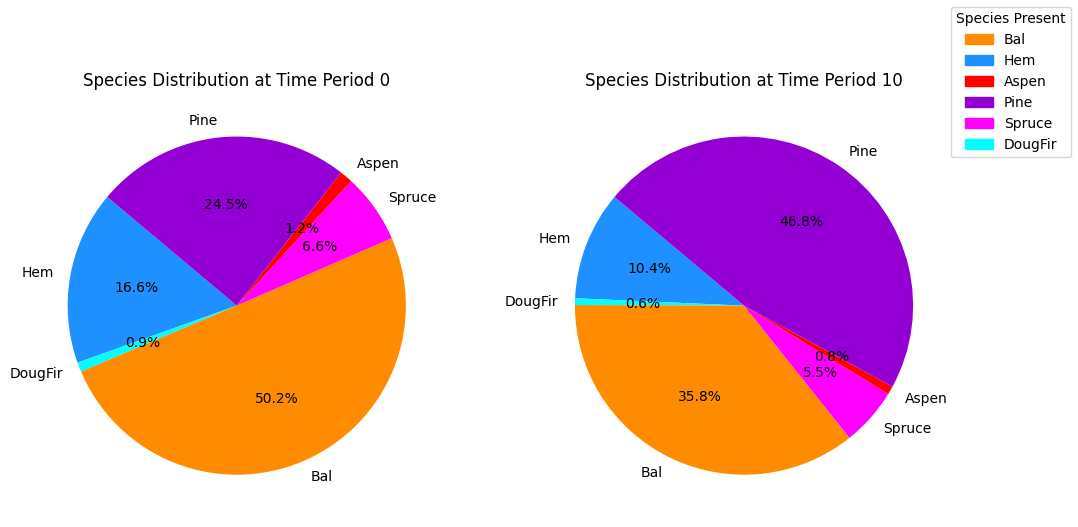

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_20%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.35s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

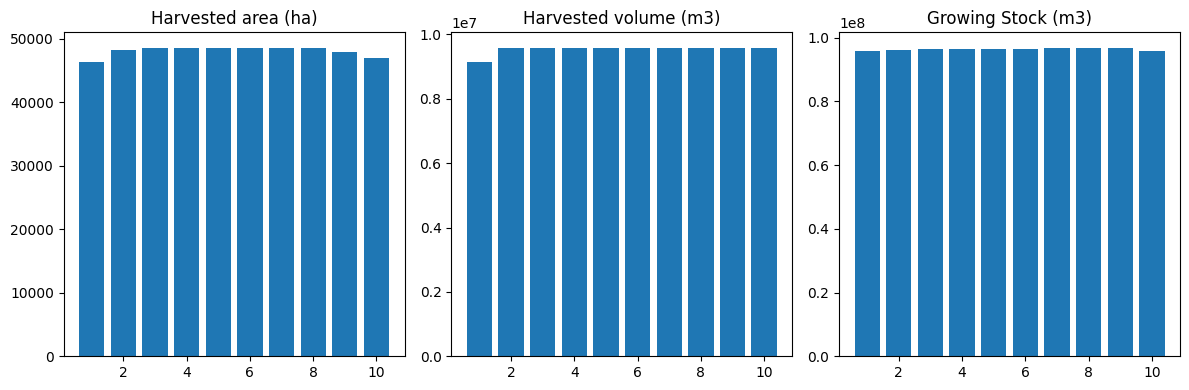

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


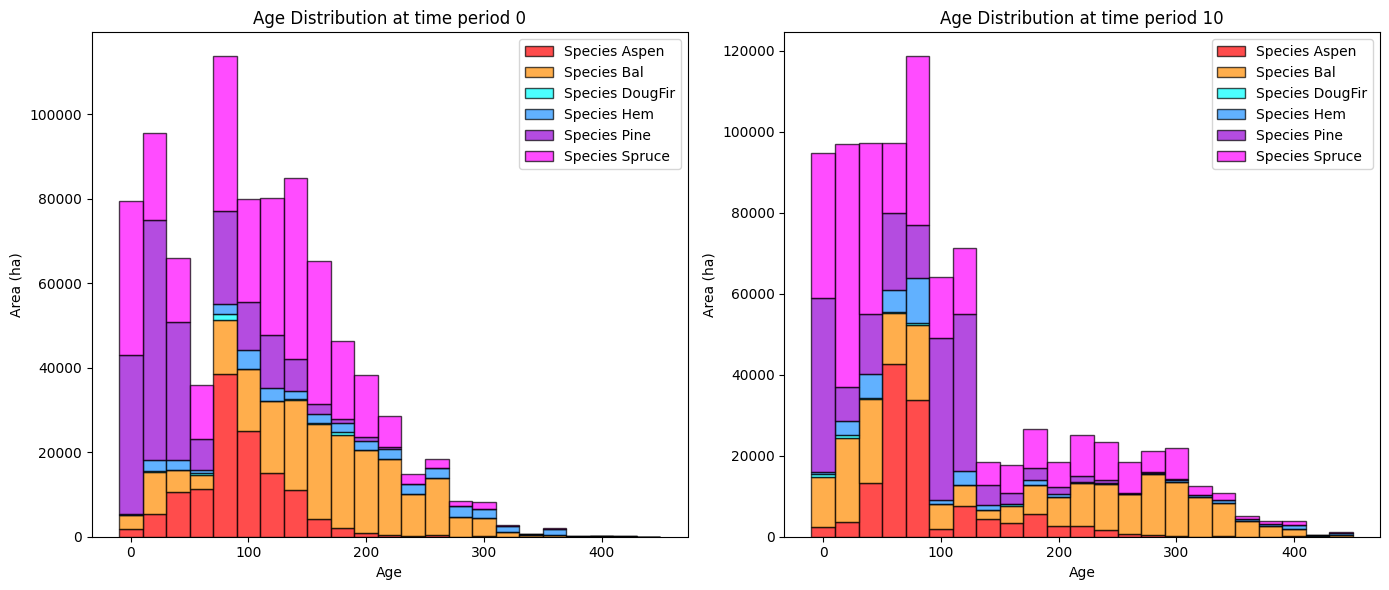

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7867.427610 -11284.699619
DougFir    947.047810    656.427461   -290.620349
Bal      59315.970469  85384.032361  26068.061892
Spruce   36410.744598  58541.140685  22130.396087
Aspen    29632.731169  25732.222254  -3900.508915
Pine      7432.733686  17416.131995   9983.398309

Overall diversity has **increased** by 42706.03 hectares from time period 0 to time period 10.


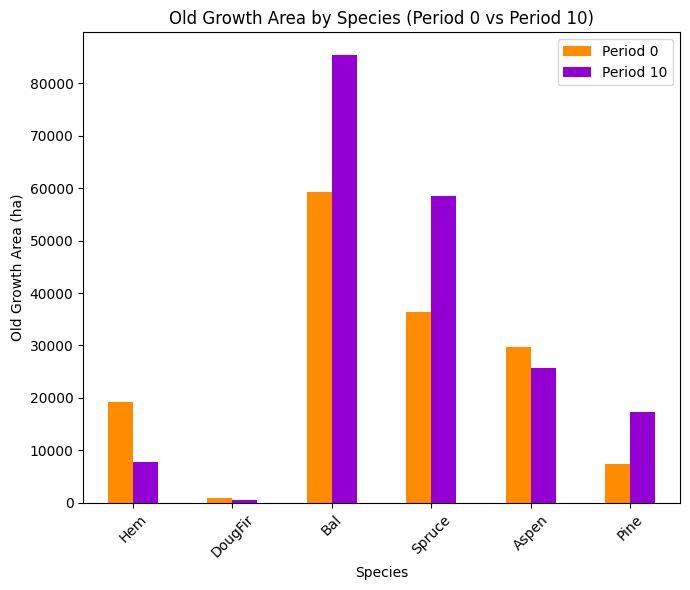

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7582

Diversity has **decreased** by 0.10% from time 0 to time 10.


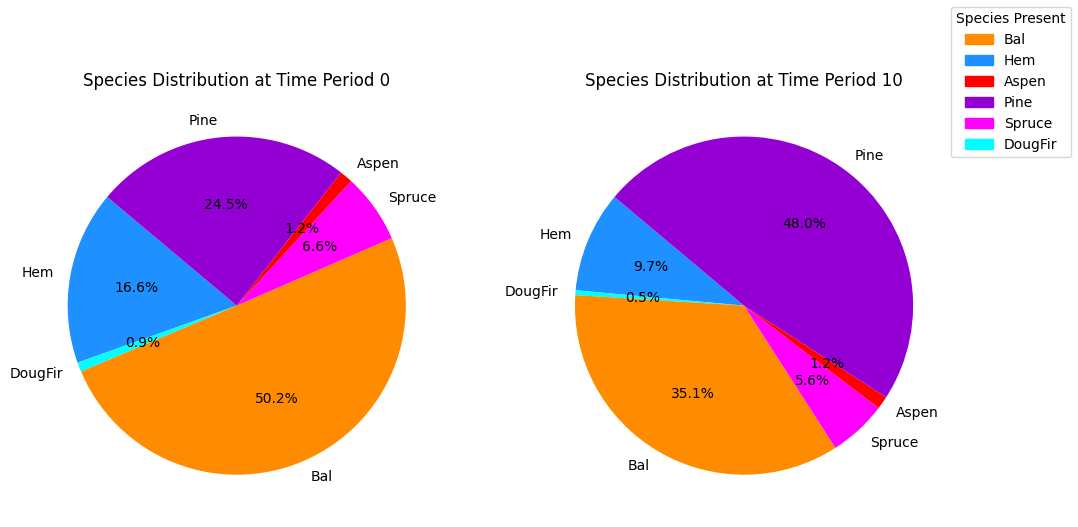

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


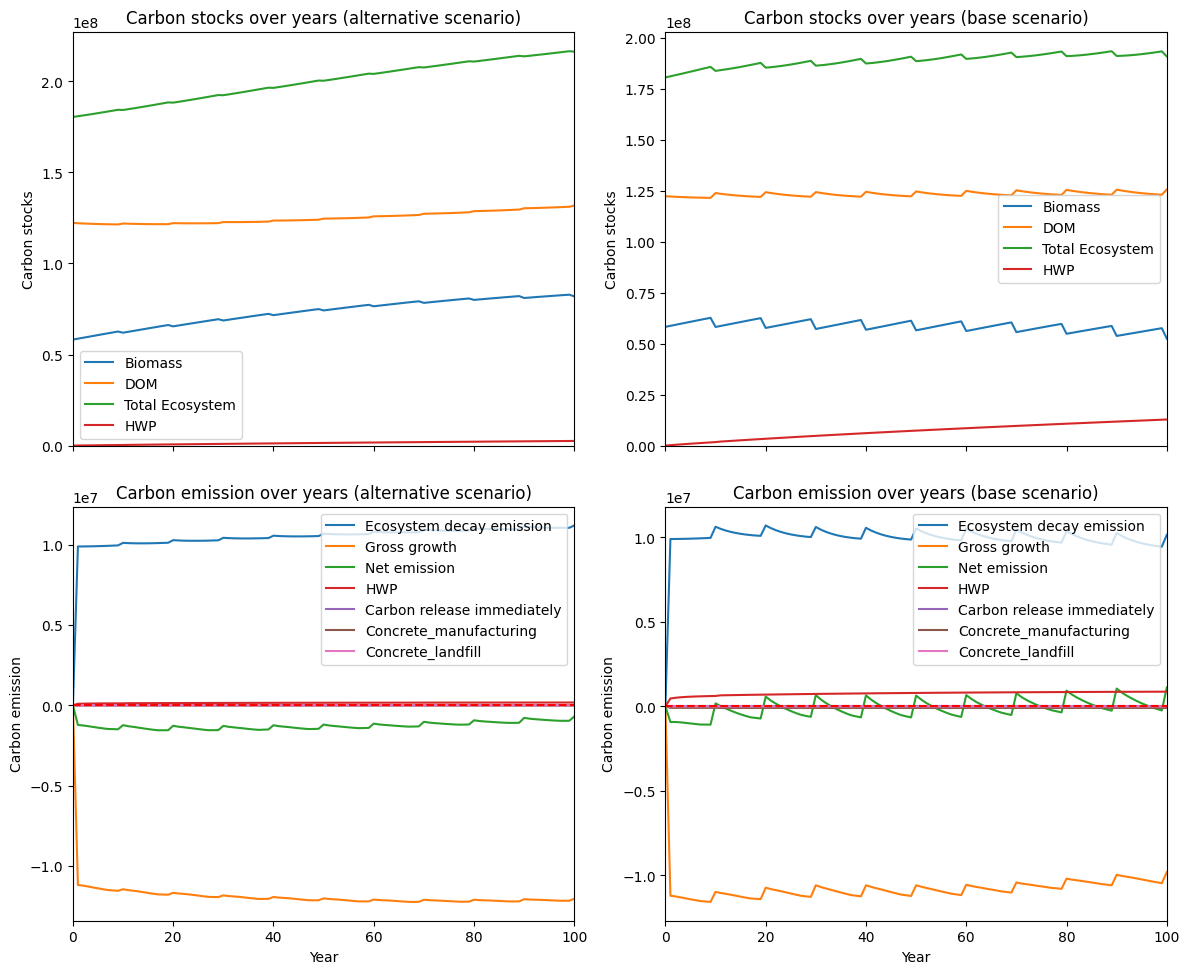

---------------------------------------------------------------------------------------
Net emission difference -21894292.761849266
Net emission base scenario -33617389.44698887
Net emission alternative scenario -11723096.685139613
dollar_per_ton is:  0.45674003306583016
Comparison of Old Growth Areas (Alternative - Base)
           0             10     Difference
Hem      0.0   18396.880073   18396.880073
DougFir  0.0    1432.939383    1432.939383
Bal      0.0   57084.205976   57084.205976
Spruce   0.0  118173.710991  118173.710991
Aspen    0.0   70767.959873   70767.959873
Pine     0.0   41189.943311   41189.943311

Overall, the old growth area has **increased** by 307045.64 hectares in the alternative scenario compared to the base scenario.


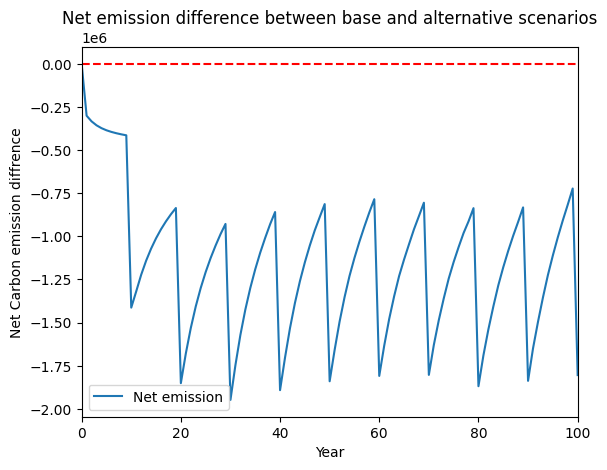

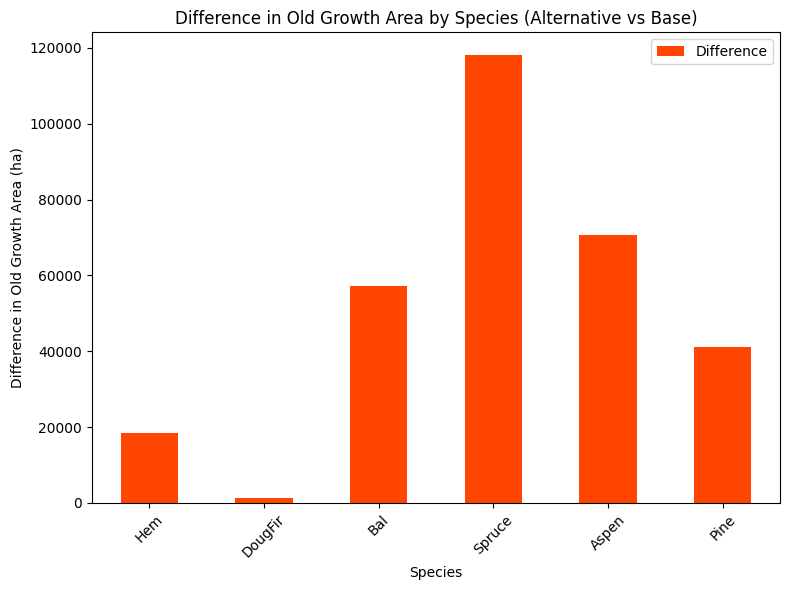

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


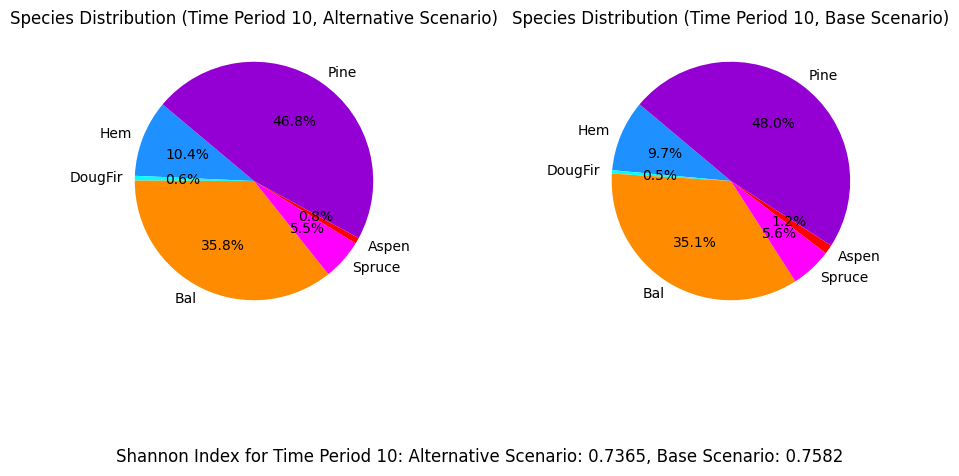

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_hv_eqtslvr_AAC_10%...
running the scenario for the Equity Silver mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x94f26dc1
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.32s
Presolved: 8375 r

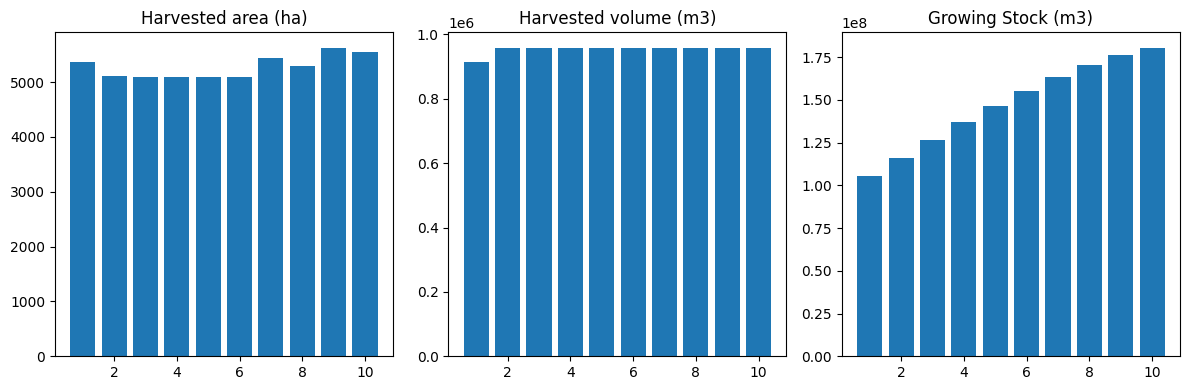

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_10%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10084
The economic indicator (the provincial government revenues) is:  343893
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


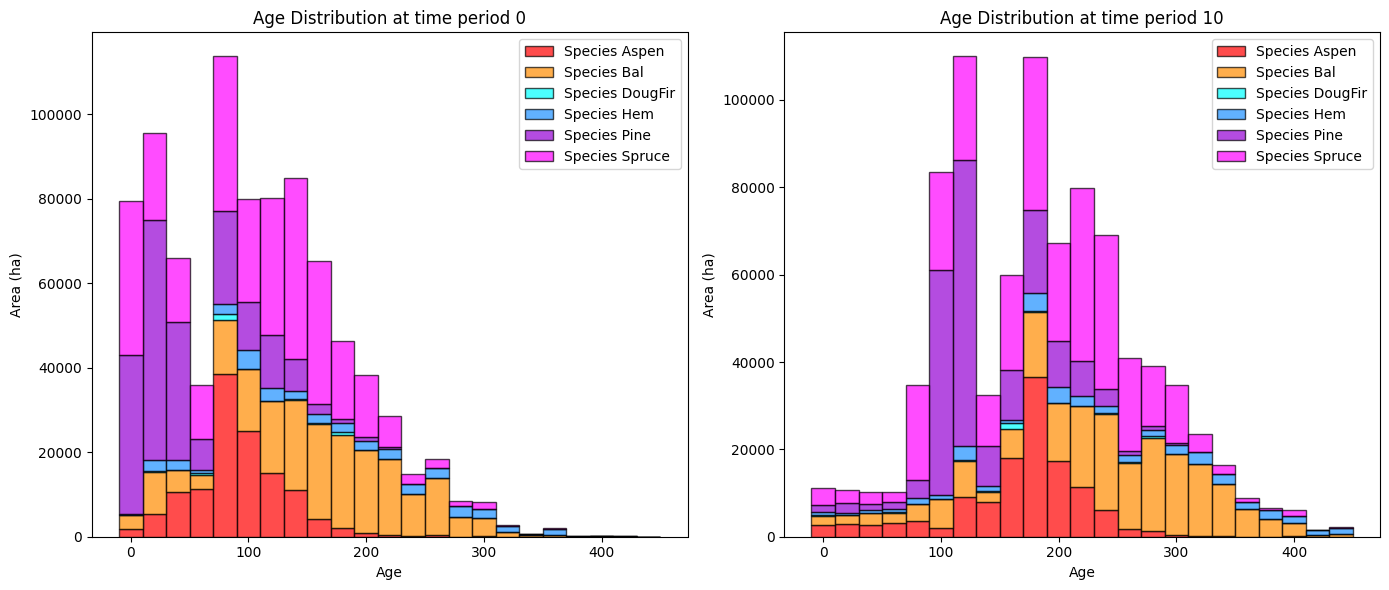

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   29359.198998   10207.071769
DougFir    947.047810    2139.635499    1192.587689
Bal      59315.970469  147692.423625   88376.453157
Spruce   36410.744598  186277.137959  149866.393361
Aspen    29632.731169  105231.710731   75598.979561
Pine      7432.733686   64762.950314   57330.216628

Overall diversity has **increased** by 382571.70 hectares from time period 0 to time period 10.


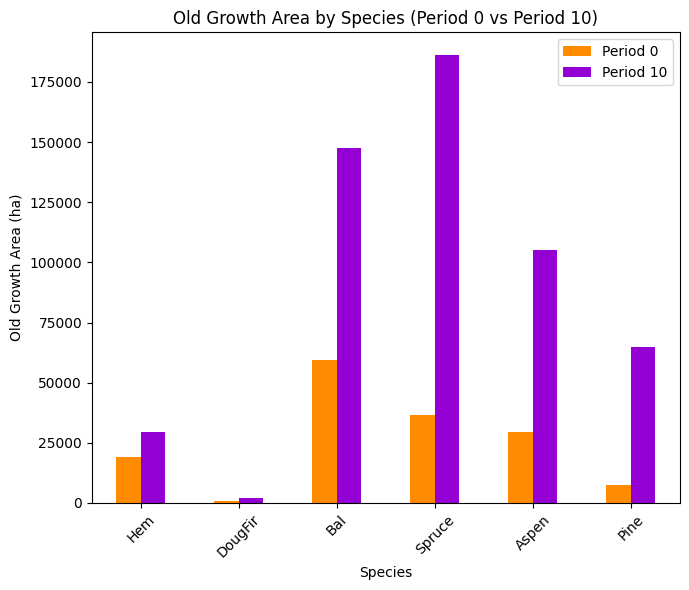

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7399

Diversity has **decreased** by 1.93% from time 0 to time 10.


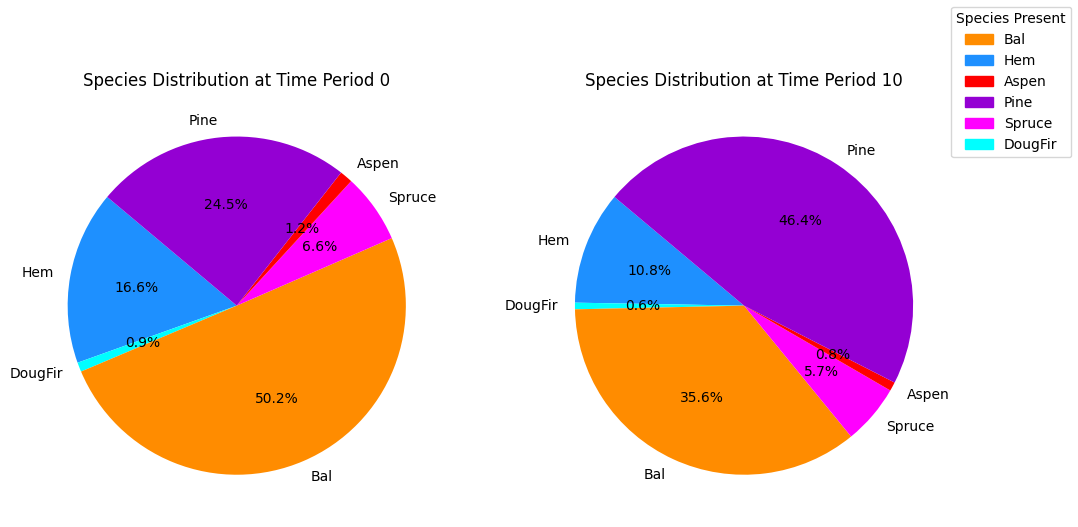

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_eqtslvr_AAC_10%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x738aa7be
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [1e-01, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8907 columns
Presolve time: 0.35s
Presolved: 8375 rows, 74352 columns, 536195 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

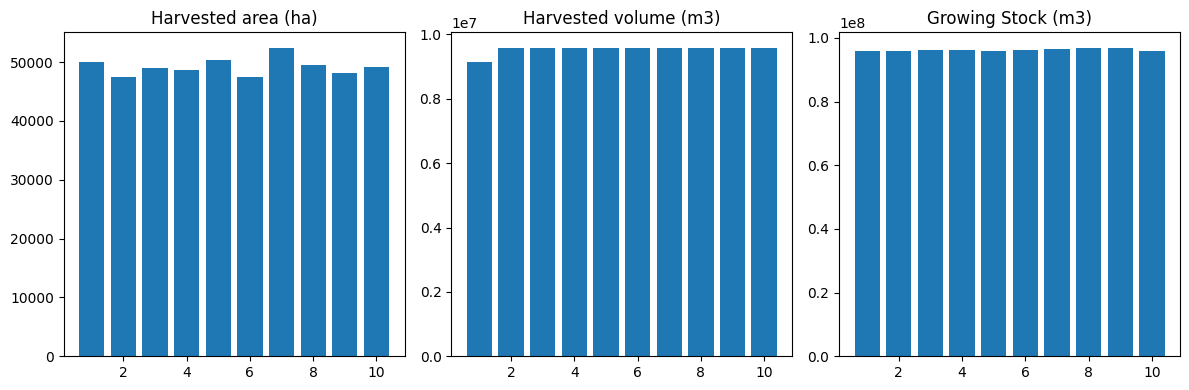

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  100842
The economic indicator (the provincial government revenues) is:  3438933
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


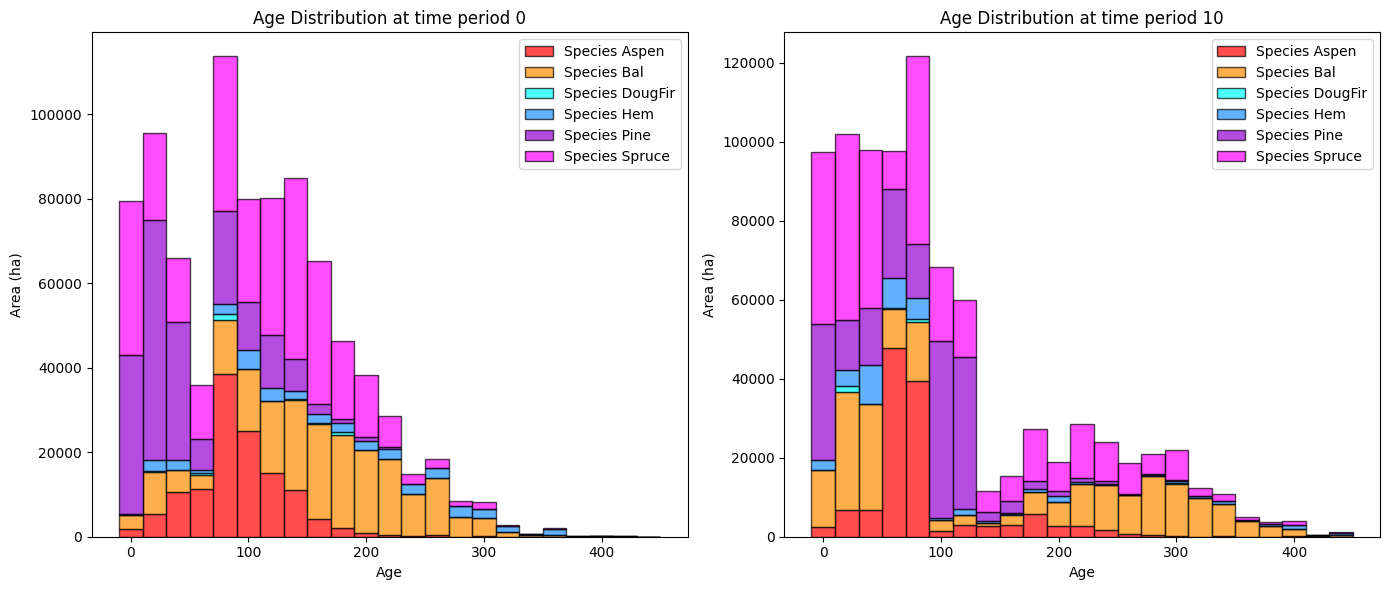

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0            10    Difference
Hem      19152.127229   7420.003864 -11732.123365
DougFir    947.047810    588.823746   -358.224064
Bal      59315.970469  83662.092085  24346.121617
Spruce   36410.744598  67222.186953  30811.442355
Aspen    29632.731169  21366.865973  -8265.865196
Pine      7432.733686  16124.525134   8691.791448

Overall diversity has **increased** by 43493.14 hectares from time period 0 to time period 10.


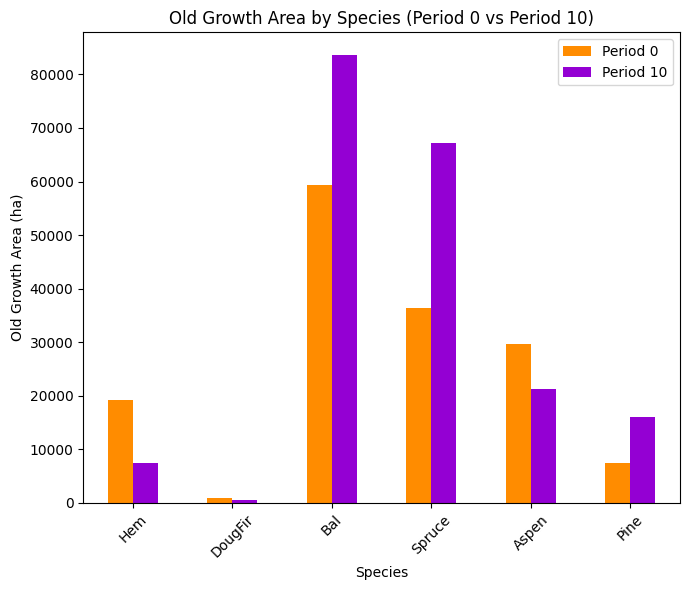

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7329

Diversity has **decreased** by 2.63% from time 0 to time 10.


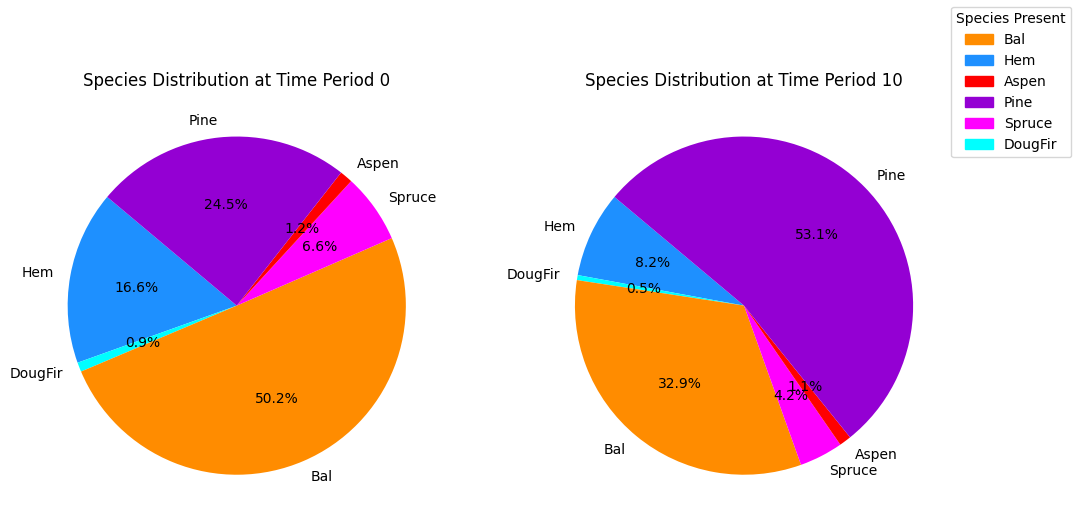

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_bau_eqtslvr_species_pie.pdf


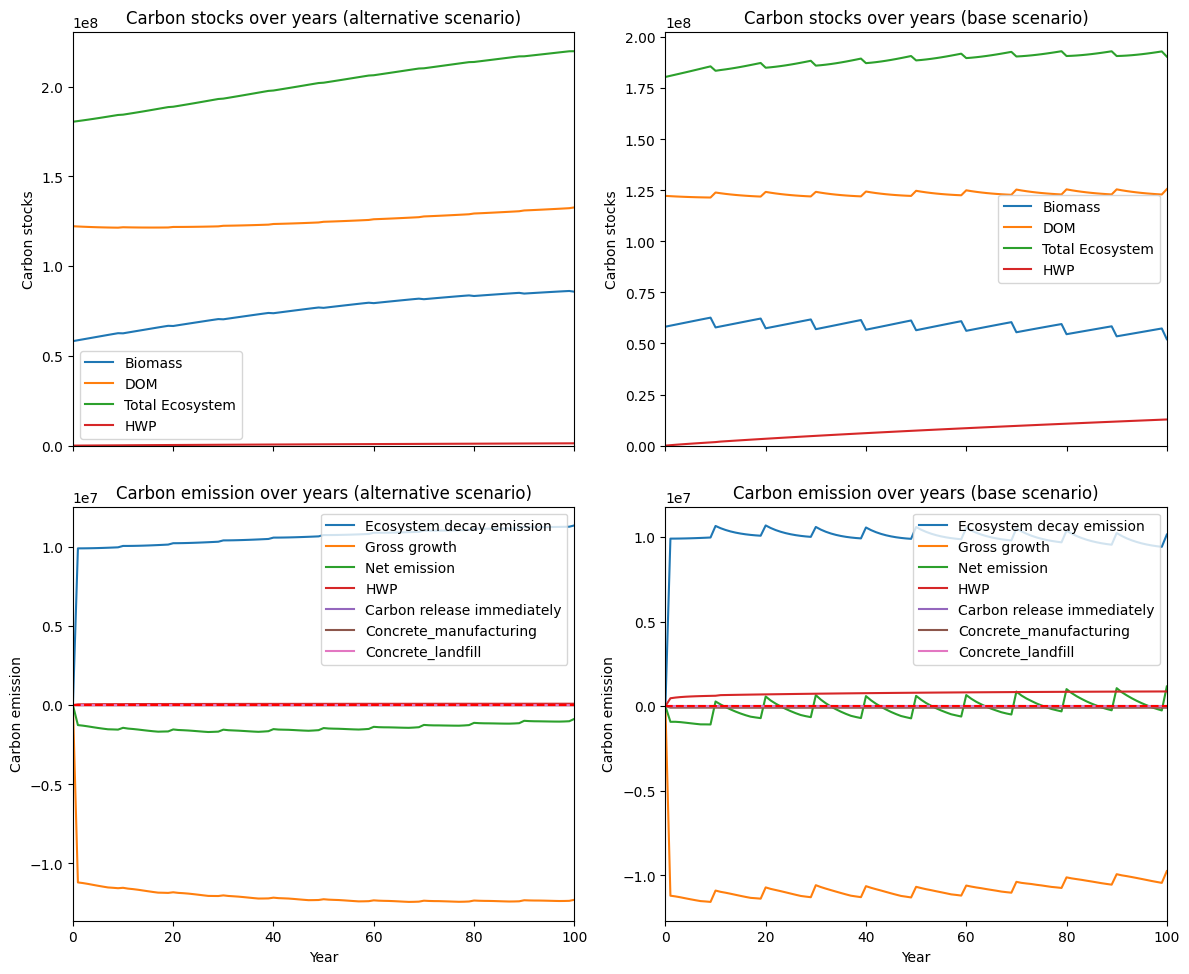

---------------------------------------------------------------------------------------
Net emission difference -25263304.933269896
Net emission base scenario -36590335.40095904
Net emission alternative scenario -11327030.467689143
dollar_per_ton is:  0.3958310294877826
Comparison of Old Growth Areas (Alternative - Base)
           0             10     Difference
Hem      0.0   21939.195134   21939.195134
DougFir  0.0    1550.811753    1550.811753
Bal      0.0   64030.331540   64030.331540
Spruce   0.0  119054.951006  119054.951006
Aspen    0.0   83864.844758   83864.844758
Pine     0.0   48638.425180   48638.425180

Overall, the old growth area has **increased** by 339078.56 hectares in the alternative scenario compared to the base scenario.


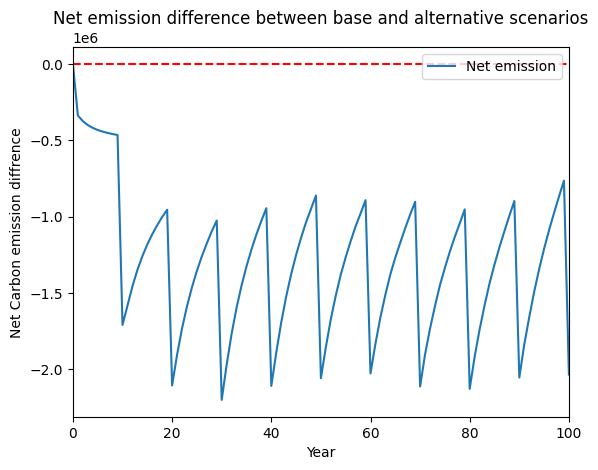

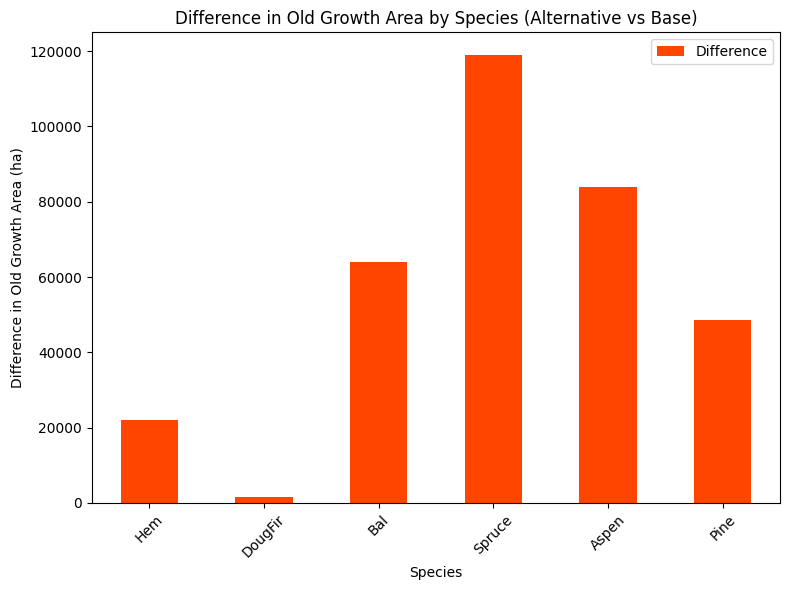

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_age_difference.pdf


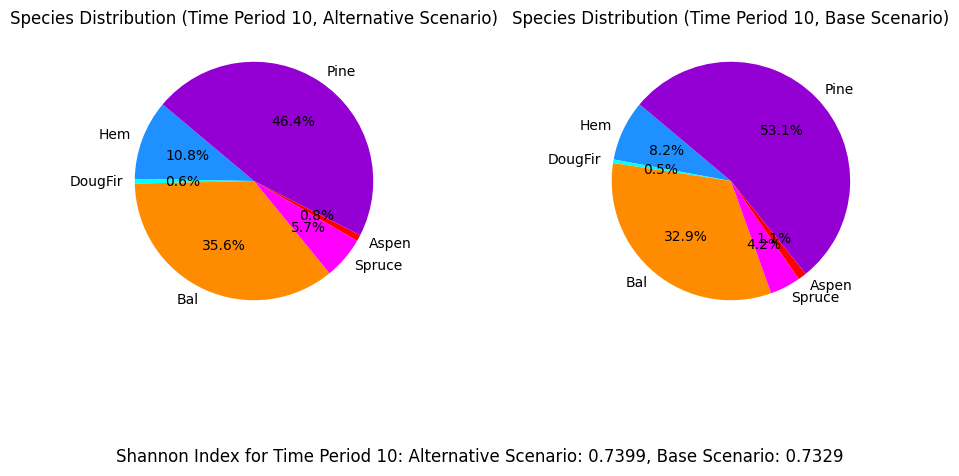

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 173.5 minutes to run all scenarios.


In [12]:
Start = time.time()
scenario_names = ['eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [13]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 173.5 minutes to run this script.
